# 0. Meta

## 0.1. Packages

In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from plz_plot.core import plot_plz_data
from plz_plot.io import get_plz_dataframe, load_plz_records
import matplotlib.pyplot as plt
from cartopy import feature
from cartopy import crs
from shapely.geometry import MultiPolygon, MultiLineString, box
from shapely.ops import unary_union
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import cartopy.io.shapereader as shpreader

## 0.2. Functions

In [332]:
# Funktion, um Werte in Float zu konvertieren und Fehler abzufangen
def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        print(f"Konvertierungsfehler bei: {value}")
        return None

# 1. Data import

In [333]:
file_path = r"C:\Sync\03_projects\data_science\projects\weddingsurvey\Hochzeitsgäste_im_Check.csv"

In [334]:
df = pd.read_csv(file_path)

In [335]:
df.head()

Teilnehmer            Startzeit              Endzeit         Quelle  \
0           1  05.08.2024 08:00:04  05.08.2024 08:03:20  Direkter Link   
1           2  05.08.2024 15:03:31  05.08.2024 15:06:48  Direkter Link   
2           3  06.08.2024 13:10:35  06.08.2024 13:16:05  Direkter Link   
3           4  06.08.2024 14:03:29  06.08.2024 14:08:22  Direkter Link   
4           5  06.08.2024 14:29:37  06.08.2024 14:38:57  Direkter Link   

  Wie alt bist du? Mit welchem Geschlecht identifizierst du dich?  \
0               57                                           Frau   
1               34                                           Mann   
2               30                                           Mann   
3               28                                           Frau   
4               31                                           Mann   

  In welchem Land bist du geboren?  \
0                              DE    
1                      Deutschland   
2                      Deutschland   
3                     Deutschland    
4                      Deutschland   

   Wie lautet die Postleitzahl (PLZ) deines Wohnortes?  \
0                                              67435     
1                                              67434     
2                                              20099     
3                                              64293     
4                                              64293     

  Wie ist dein Familienstand? Wie viele Kinder hast du?  ...  \
0                 Verheiratet                         5  ...   
1                      Liiert                         0  ...   
2                      Liiert                         0  ...   
3                 Verheiratet                         2  ...   
4                 Verheiratet                         2  ...   

  Wer fährt besser Fahrrad nach dem Biergartenbesuch? (Lucas)  \
0                                       übersprungen            
1                                                  1            
2                                                  0            
3                                                  1            
4                                                  1            

  Wer hat mehr Narben? (Lena) Wer hat mehr Narben? (Lucas)  \
0                           0                            1   
1                           1                            0   
2                           0                            1   
3                           0                            1   
4                           0                            1   

  Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lena)  \
0                                                  1                             
1                                                  1                             
2                                                  1                             
3                                                  1                             
4                                                  1                             

  Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lucas)  \
0                                                  1                              
1                                                  0                              
2                                                  0                              
3                                                  0                              
4                                                  0                              

  Welchen Nachnamen soll das Brautpaar wählen, wenn es nach dir geht?  \
0    Beide sollen ihren aktuellen Nachnamen behalten                    
1                                    Wallbert-Almann                    
2                                    Albert-Wallmann                    
3                                    Almann-Wallbert                    
4                                    Albert-Wallmann       

# 2. Offene Fragen

## Wie alt bist du?

In [336]:
df['Wie alt bist du? (float)'] = df['Wie alt bist du?'].apply(convert_to_float)
invalid_entries = df[df['Wie alt bist du? (float)'].isnull()]['Wie alt bist du?']
invalid_entries

Konvertierungsfehler bei: Too good to go
Konvertierungsfehler bei: 78 Jahre 


11    Too good to go
46         78 Jahre 
Name: Wie alt bist du?, dtype: object

In [337]:
# Ersetze den ersten ungültigen Eintrag mit NaN
df.loc[invalid_entries.index[0], 'Wie alt bist du?'] = np.nan

# Ersetze den zweiten ungültigen Eintrag mit 78
df.loc[invalid_entries.index[1], 'Wie alt bist du?'] = 78

In [338]:
# Konvertierung in float vornehmen
df['Wie alt bist du? (float)'] = df['Wie alt bist du?'].apply(convert_to_float)

# Überprüfen, ob die Änderungen korrekt sind
df[['Wie alt bist du?', 'Wie alt bist du? (float)']].loc[invalid_entries.index]

Wie alt bist du?  Wie alt bist du? (float)
11              NaN                       NaN
46               78                      78.0

In [339]:
# Berechnung der statistischen Kennzahlen für die Altersvariable
summary_stats = {
    'Min': df['Wie alt bist du? (float)'].min(),
    'Max': df['Wie alt bist du? (float)'].max(),
    'Mean': df['Wie alt bist du? (float)'].mean(),
    'SD': df['Wie alt bist du? (float)'].std()
}

print("Zusammenfassung der Altersdaten:")
summary_stats

Zusammenfassung der Altersdaten:


{'Min': np.float64(21.0),
 'Max': np.float64(80.0),
 'Mean': np.float64(36.224489795918366),
 'SD': np.float64(13.50503811256261)}

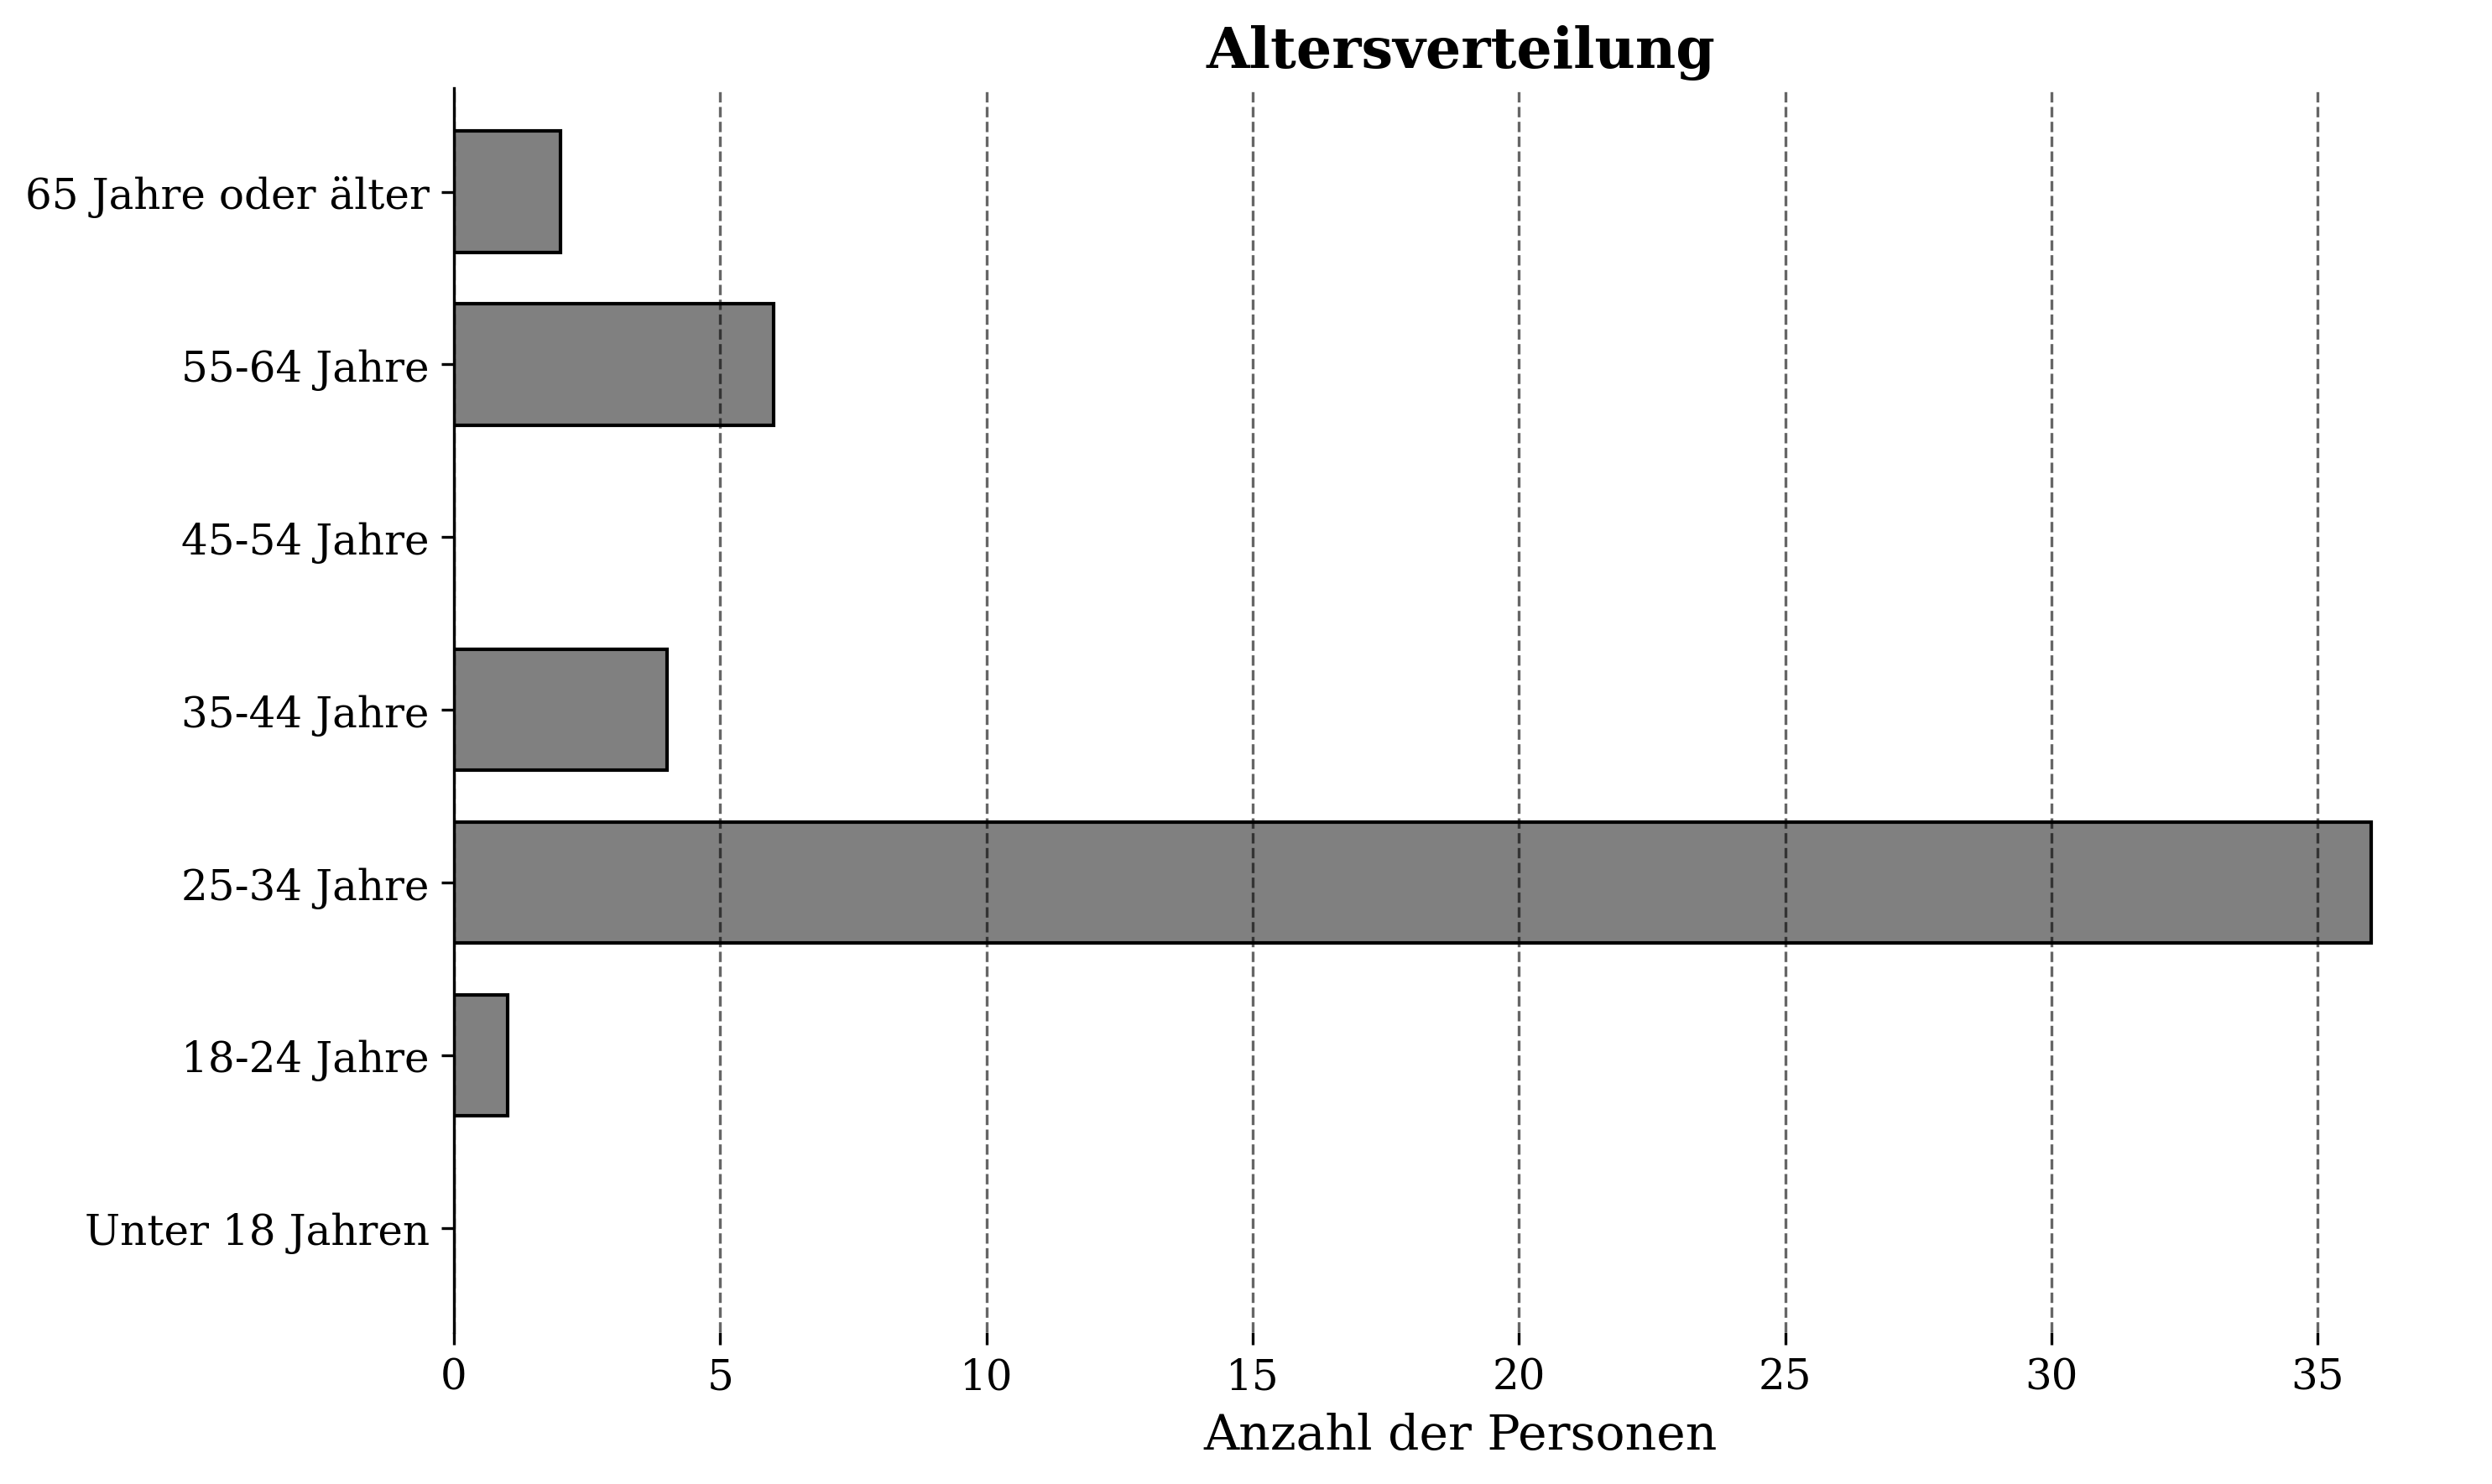

In [340]:
# Definiere die Bins und Labels für die Altersgruppen
bins = [0, 18, 25, 35, 45, 55, 65, float('inf')]
labels = ['Unter 18 Jahren', '18-24 Jahre', '25-34 Jahre', '35-44 Jahre', '45-54 Jahre', '55-64 Jahre', '65 Jahre oder älter']

# Verwende pd.cut, um die Altersgruppen ohne neue Spalte zu erstellen und direkt zu zählen
age_group_counts = pd.cut(df['Wie alt bist du? (float)'], bins=bins, labels=labels, right=False).value_counts(sort=False)

# Erstelle das horizontale Balkendiagramm der Altersgruppen
plt.figure(figsize=(10, 6), dpi=300)
age_group_counts = pd.cut(df['Wie alt bist du? (float)'], bins=bins, labels=labels, right=False).value_counts(sort=False)
age_group_counts.plot(kind='barh', color='gray', edgecolor='black', width=0.7)  # Verkleinere den Abstand zwischen den Balken durch Setzen der Breite
plt.title('Altersverteilung', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Anzahl der Personen', fontsize=14, family='serif')
plt.xticks(fontsize=12, family='serif')
plt.yticks(fontsize=12, family='serif')
plt.grid(axis='x', linestyle='--', alpha=0.6, color='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.ylabel('')  # Entfernt das y-Label
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()

## In welchem Land bist du geboren?

In [341]:
# Berechnung der Häufigkeit der Antworten auf die offene Frage
country_counts = df['In welchem Land bist du geboren?'].value_counts()

# Anzeigen der Einträge und ihrer Häufigkeiten
print(country_counts)

In welchem Land bist du geboren?
Deutschland     25
Deutschland     17
DE               1
Sauerland        1
Bangladesch      1
Pfalz            1
Russland         1
Afghanistan      1
Germany          1
DE               1
Name: count, dtype: int64


In [342]:
# Entferne führende und nachfolgende Leerzeichen in der Spalte
df['In welchem Land bist du geboren?'] = df['In welchem Land bist du geboren?'].str.strip()

# Definiere die Einträge, die zusammengeführt werden sollen
to_merge = ["Deutschland", "DE", "Sauerland", "Pfalz", "Germany"]

# Ersetze diese Einträge durch "Deutschland"
df['In welchem Land bist du geboren?'] = df['In welchem Land bist du geboren?'].replace(to_merge, "Deutschland")

# Überprüfe das Ergebnis der Zusammenführung
country_counts = df['In welchem Land bist du geboren?'].value_counts()
print(country_counts)

In welchem Land bist du geboren?
Deutschland    47
Bangladesch     1
Russland        1
Afghanistan     1
Name: count, dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\3119641532.py:35: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\3119641532.py:35: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\3119641532.py:35: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\3119641532.py:35: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS befor

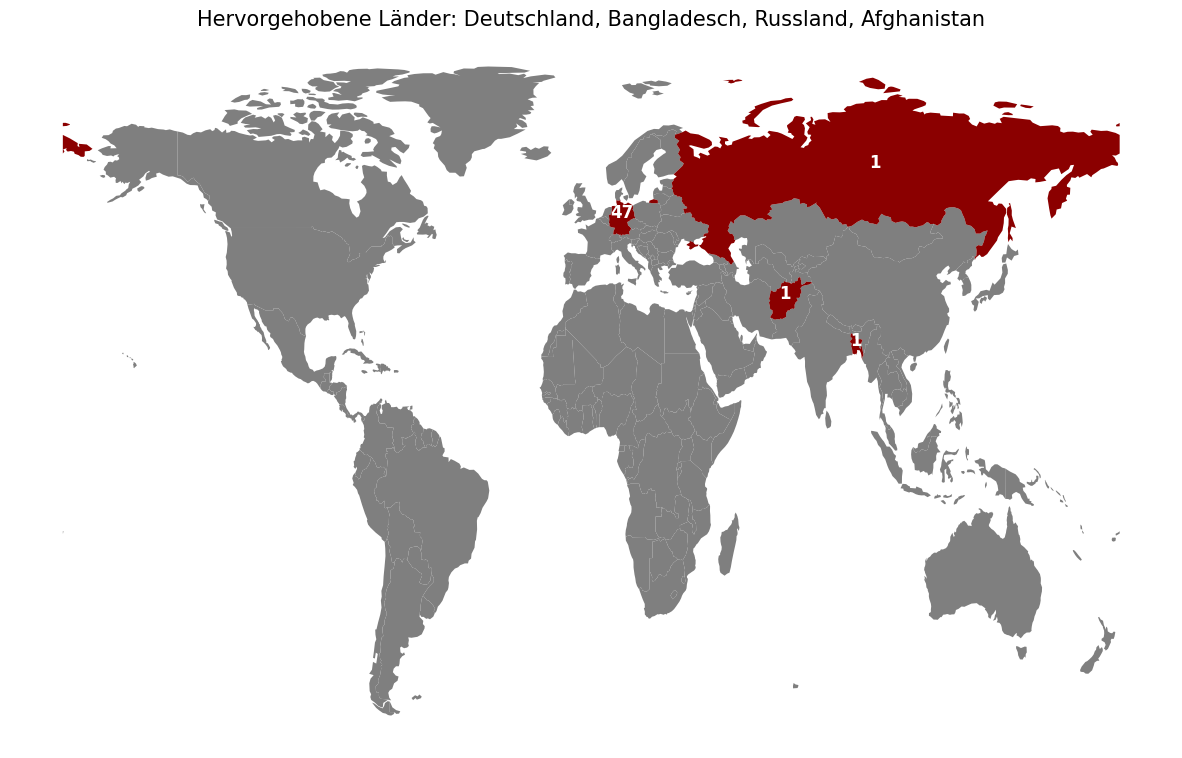

In [343]:
# Pfad zur heruntergeladenen und entpackten .shp Datei
shapefile_path = r"C:\Sync\03_projects\data_science\projects\weddingsurvey\geopandas_maps\ne_110m_admin_0_countries.shp"

# Weltkarte laden
world = gpd.read_file(shapefile_path)

# Entferne die Antarktis aus dem GeoDataFrame
world = world[world['NAME'] != 'Antarctica']

# Liste der Länder, die eingefärbt werden sollen, und ihre Zähler
highlight_countries = {
    'Germany': 47,
    'Bangladesh': 1,
    'Russia': 1,
    'Afghanistan': 1
}

# Erstelle eine Spalte, die festlegt, ob ein Land hervorgehoben wird
world['highlight'] = world['NAME'].apply(lambda x: 'Highlighted' if x in highlight_countries else 'Other')

# Plotten der Weltkarte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Andere Länder in einem dunkleren Grau einfärben
world[world['highlight'] == 'Other'].plot(ax=ax, color='#7f7f7f')  # Dunkleres Grau

# Hervorgehobene Länder einfärben
highlighted = world[world['highlight'] == 'Highlighted']
highlighted.plot(ax=ax, color='darkred')

# Länderzähler in Weiß hinzufügen
for country, count in highlight_countries.items():
    country_geometry = highlighted[highlighted['NAME'] == country].geometry
    if not country_geometry.empty:
        x, y = country_geometry.centroid.x.values[0], country_geometry.centroid.y.values[0]
        ax.annotate(text=str(count), xy=(x, y), color='white', fontsize=12, ha='center', weight='bold')

# Titel und Achsen entfernen für eine saubere Darstellung
ax.set_title('Hervorgehobene Länder: Deutschland, Bangladesch, Russland, Afghanistan', fontsize=15)
ax.set_axis_off()

plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\47677015.py:35: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\47677015.py:35: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\47677015.py:35: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\47677015.py:35: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this o

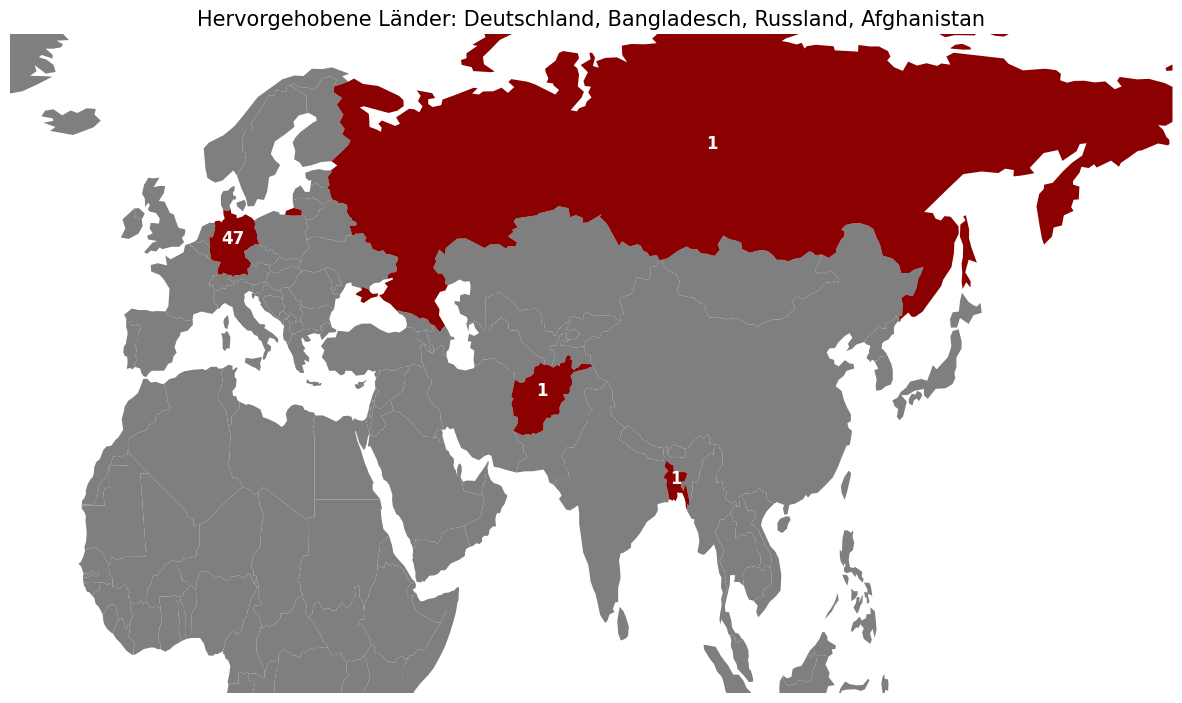

In [344]:
# Pfad zur heruntergeladenen und entpackten .shp Datei
shapefile_path = r"C:\Sync\03_projects\data_science\projects\weddingsurvey\geopandas_maps\ne_110m_admin_0_countries.shp"

# Weltkarte laden
world = gpd.read_file(shapefile_path)

# Entferne die Antarktis aus dem GeoDataFrame
world = world[world['NAME'] != 'Antarctica']

# Liste der Länder, die eingefärbt werden sollen, und ihre Zähler
highlight_countries = {
    'Germany': 47,
    'Bangladesh': 1,
    'Russia': 1,
    'Afghanistan': 1
}

# Erstelle eine Spalte, die festlegt, ob ein Land hervorgehoben wird
world['highlight'] = world['NAME'].apply(lambda x: 'Highlighted' if x in highlight_countries else 'Other')

# Plotten der Weltkarte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Andere Länder in einem dunkleren Grau einfärben
world[world['highlight'] == 'Other'].plot(ax=ax, color='#7f7f7f')  # Dunkleres Grau

# Hervorgehobene Länder einfärben
highlighted = world[world['highlight'] == 'Highlighted']
highlighted.plot(ax=ax, color='darkred')

# Länderzähler in Weiß hinzufügen
for country, count in highlight_countries.items():
    country_geometry = highlighted[highlighted['NAME'] == country].geometry
    if not country_geometry.empty:
        x, y = country_geometry.centroid.x.values[0], country_geometry.centroid.y.values[0]
        ax.annotate(text=str(count), xy=(x, y), color='white', fontsize=12, ha='center', weight='bold')

# Titel und Achsen entfernen für eine saubere Darstellung
ax.set_title('Hervorgehobene Länder: Deutschland, Bangladesch, Russland, Afghanistan', fontsize=15)
ax.set_axis_off()

# Setzen der Grenzen für den Fokus auf Europa und Umgebung
ax.set_xlim([-30, 180])  # Begrenzung für die x-Achse (links von Europa bis Asien)
ax.set_ylim([0, 75])    # Begrenzung für die y-Achse (oberhalb Afghanistans)

plt.show()

## Wie lautet die Postleitzahl (PLZ) deines Wohnortes?

In [345]:
# Überprüfe die Häufigkeit der Postleitzahleneinträge
plz_counts = df['Wie lautet die Postleitzahl (PLZ) deines Wohnortes?'].value_counts()

# Zeige die Einträge und deren Häufigkeit an
plz_counts

Wie lautet die Postleitzahl (PLZ) deines Wohnortes?
67435    3
64319    3
64293    2
67434    2
50354    2
50825    2
63762    2
22767    2
80805    2
67059    2
60318    2
86159    2
20099    1
55116    1
89077    1
27804    1
50679    1
65183    1
56203    1
67470    1
78467    1
38106    1
69120    1
81543    1
80935    1
69181    1
63071    1
80337    1
13088    1
71083    1
81549    1
86161    1
81677    1
86157    1
64625    1
18246    1
Name: count, dtype: int64

In [346]:
# Speichere den ursprünglichen Umfragedatensatz in einem separaten DataFrame
survey_df = df.copy()

# Lade die Postleitzahldaten
plz_df = get_plz_dataframe()

# Konvertiere die Postleitzahlen im Umfragedatensatz in Strings und normiere sie auf 5 Ziffern
survey_df['PLZ_norm'] = survey_df['Wie lautet die Postleitzahl (PLZ) deines Wohnortes?'].astype(str).str.zfill(5)

# Normiere die Postleitzahlen im PLZ-Datensatz ebenfalls auf 5 Ziffern
plz_df.index = plz_df.index.str.strip().str.zfill(5)

# Filtere erneut den DataFrame auf die normierten PLZ
plz_list = survey_df['PLZ_norm'].unique()
df_filtered = plz_df[plz_df.index.isin(plz_list)]

Erfolgreich übereinstimmende Postleitzahlen gefunden.


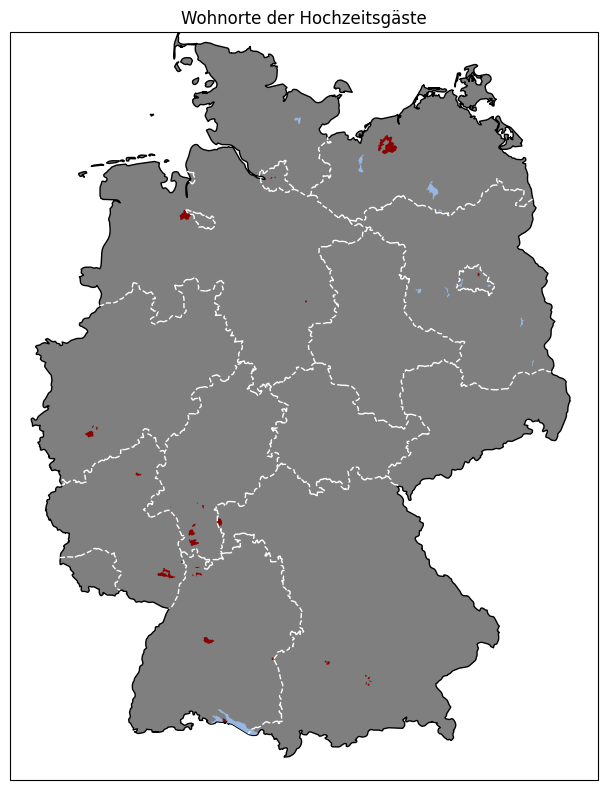

In [347]:
# Überprüfung, ob `df_filtered` jetzt Daten enthält
if df_filtered.empty:
    print("Warnung: Auch nach der Normierung stimmen keine Postleitzahlen überein.")
else:
    print("Erfolgreich übereinstimmende Postleitzahlen gefunden.")

# Wenn Übereinstimmungen gefunden werden, kannst du den Rest des Codes verwenden, um die Karte zu plotten
if not df_filtered.empty:

    # Filtere die Geometrien entsprechend den übereinstimmenden Postleitzahlen
    recs = load_plz_records()
    filtered_recs = [rec for rec in recs if rec.attributes['plz'] in df_filtered.index]

    # Plotten der Karte
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1, projection=crs.Mercator())

    # Engerer Zuschnitt um Deutschland
    ax.set_extent([5.5, 15.5, 47, 55], crs.PlateCarree())

    # Laden der Ländergrenzen
    shpfilename = shpreader.natural_earth(resolution='10m',
                                          category='cultural',
                                          name='admin_0_countries')

    reader = shpreader.Reader(shpfilename)
    countries = reader.records()

    # Färbe nur Deutschland
    germany_shape = None
    for country in countries:
        if country.attributes['NAME'] == 'Germany':  # Nur Deutschland färben
            germany_shape = country.geometry
            ax.add_geometries([country.geometry], crs.PlateCarree(),
                              edgecolor='k', facecolor='#7f7f7f', zorder=1)  # Füllung für Deutschland
        else:
            ax.add_geometries([country.geometry], crs.PlateCarree(),
                              edgecolor='none', facecolor='none', zorder=1)  # Keine Füllung für Nachbarländer

    # Shapefile für administrative Grenzen (Bundesländer) von Deutschland laden
    shpfilename = shpreader.natural_earth(resolution='10m',
                                          category='cultural',
                                          name='admin_1_states_provinces_lines')

    reader = shpreader.Reader(shpfilename)
    states = reader.records()

    # Nur Grenzen innerhalb von Deutschland plotten
    for state in states:
        if state.attributes['ADM0_NAME'] == 'Germany':  # Verwende 'ADM0_NAME' um Deutschland zu filtern
            ax.add_geometries([state.geometry], crs.PlateCarree(),
                              edgecolor='white', facecolor='none',
                              linestyle='--', linewidth=1, zorder=3)

    # Seen innerhalb Deutschlands hinzufügen
    shpfilename = shpreader.natural_earth(resolution='10m',
                                          category='physical',
                                          name='lakes')

    reader = shpreader.Reader(shpfilename)
    lakes = reader.records()

    for lake in lakes:
        if germany_shape.intersects(lake.geometry):  # Nur Seen innerhalb Deutschlands
            # Schnitt der Geometrie des Sees mit der Geometrie Deutschlands
            intersection = germany_shape.intersection(lake.geometry)
            ax.add_geometries([intersection], crs.PlateCarree(),
                              edgecolor='none', facecolor=feature.COLORS['water'], zorder=2)

    # Funktion zur Anpassung von MultiPolygon-Objekten für die Plot-Daten
    def build_patch_collection_fixed(filtered_recs):
        patches = []
        repeat = np.zeros(len(filtered_recs), dtype=int)
        for i, rec in enumerate(filtered_recs):
            if rec.geometry.geom_type == 'Polygon':
                iterable_geo = [rec.geometry]
            elif rec.geometry.geom_type == 'MultiPolygon':
                iterable_geo = rec.geometry.geoms
            else:
                iterable_geo = [rec.geometry]

            for geom in iterable_geo:
                repeat[i] += 1

                if isinstance(geom.boundary, MultiLineString):
                    for line in geom.boundary.geoms:
                        xy = np.array(line.xy).T
                        patches.append(Polygon(xy, closed=True))
                else:
                    xy = np.array(geom.boundary.xy).T
                    patches.append(Polygon(xy, closed=True))

        collection = PatchCollection(patches, transform=crs.Mercator.GOOGLE, zorder=2)
        collection.set_facecolor('darkred')  # Setze die Füllfarbe für alle Polygone auf ein knalliges Rot
        collection.set_edgecolor('none')  # Entferne die Konturfarbe

        return collection, repeat

    # Anpassung des Builds der Patch Collection
    col, _ = build_patch_collection_fixed(filtered_recs)

    ax.add_collection(col)

    ax.set_title('Wohnorte der Hochzeitsgäste')

    fig.tight_layout()
    plt.show()


# 3. Nur eine Antwort möglich

## Mit welchem Geschlecht identifizierst du dich?

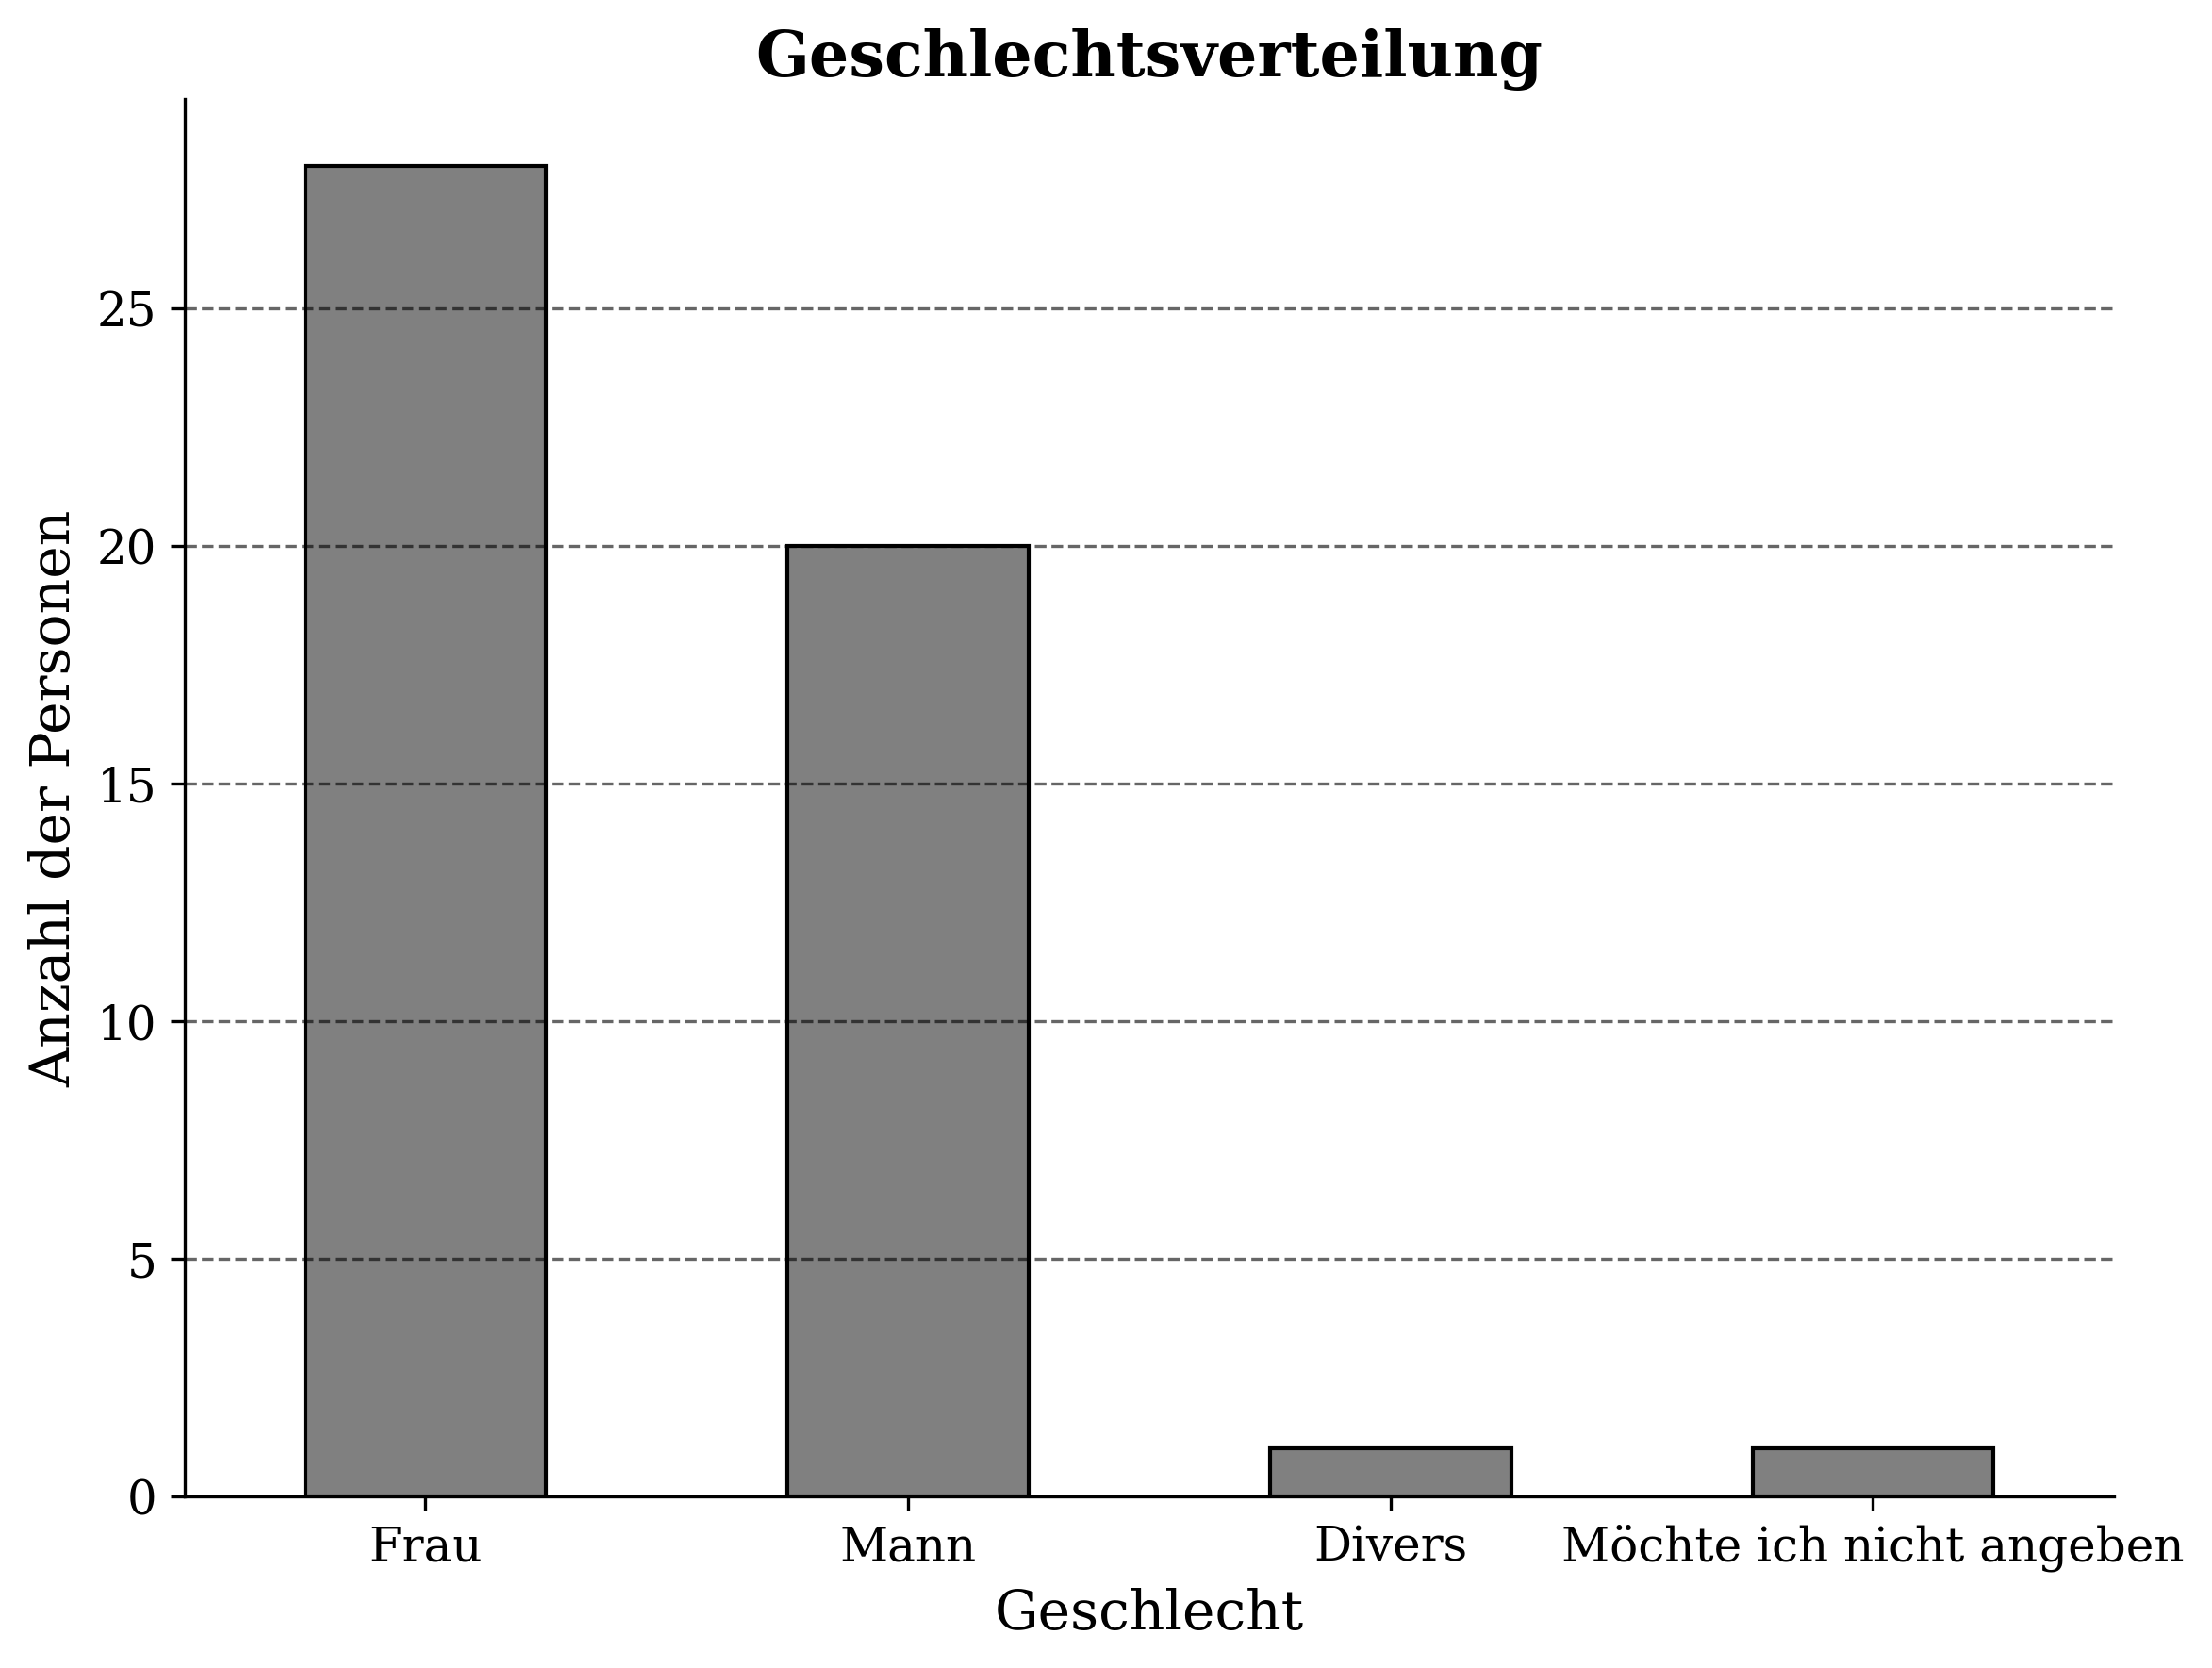

In [348]:
# Berechne die Häufigkeit der Antworten
gender_counts = df['Mit welchem Geschlecht identifizierst du dich?'].value_counts()

# Erstelle ein Balkendiagramm der Geschlechtsverteilung
plt.figure(figsize=(8, 6), dpi=300)
gender_counts.plot(kind='bar', color='gray', edgecolor='black')
plt.title('Geschlechtsverteilung', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Geschlecht', fontsize=14, family='serif')
plt.ylabel('Anzahl der Personen', fontsize=14, family='serif')
plt.xticks(rotation=0, fontsize=12, family='serif')
plt.yticks(fontsize=12, family='serif')
plt.grid(axis='y', linestyle='--', alpha=0.6, color='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()

## Wie ist dein Familienstand?

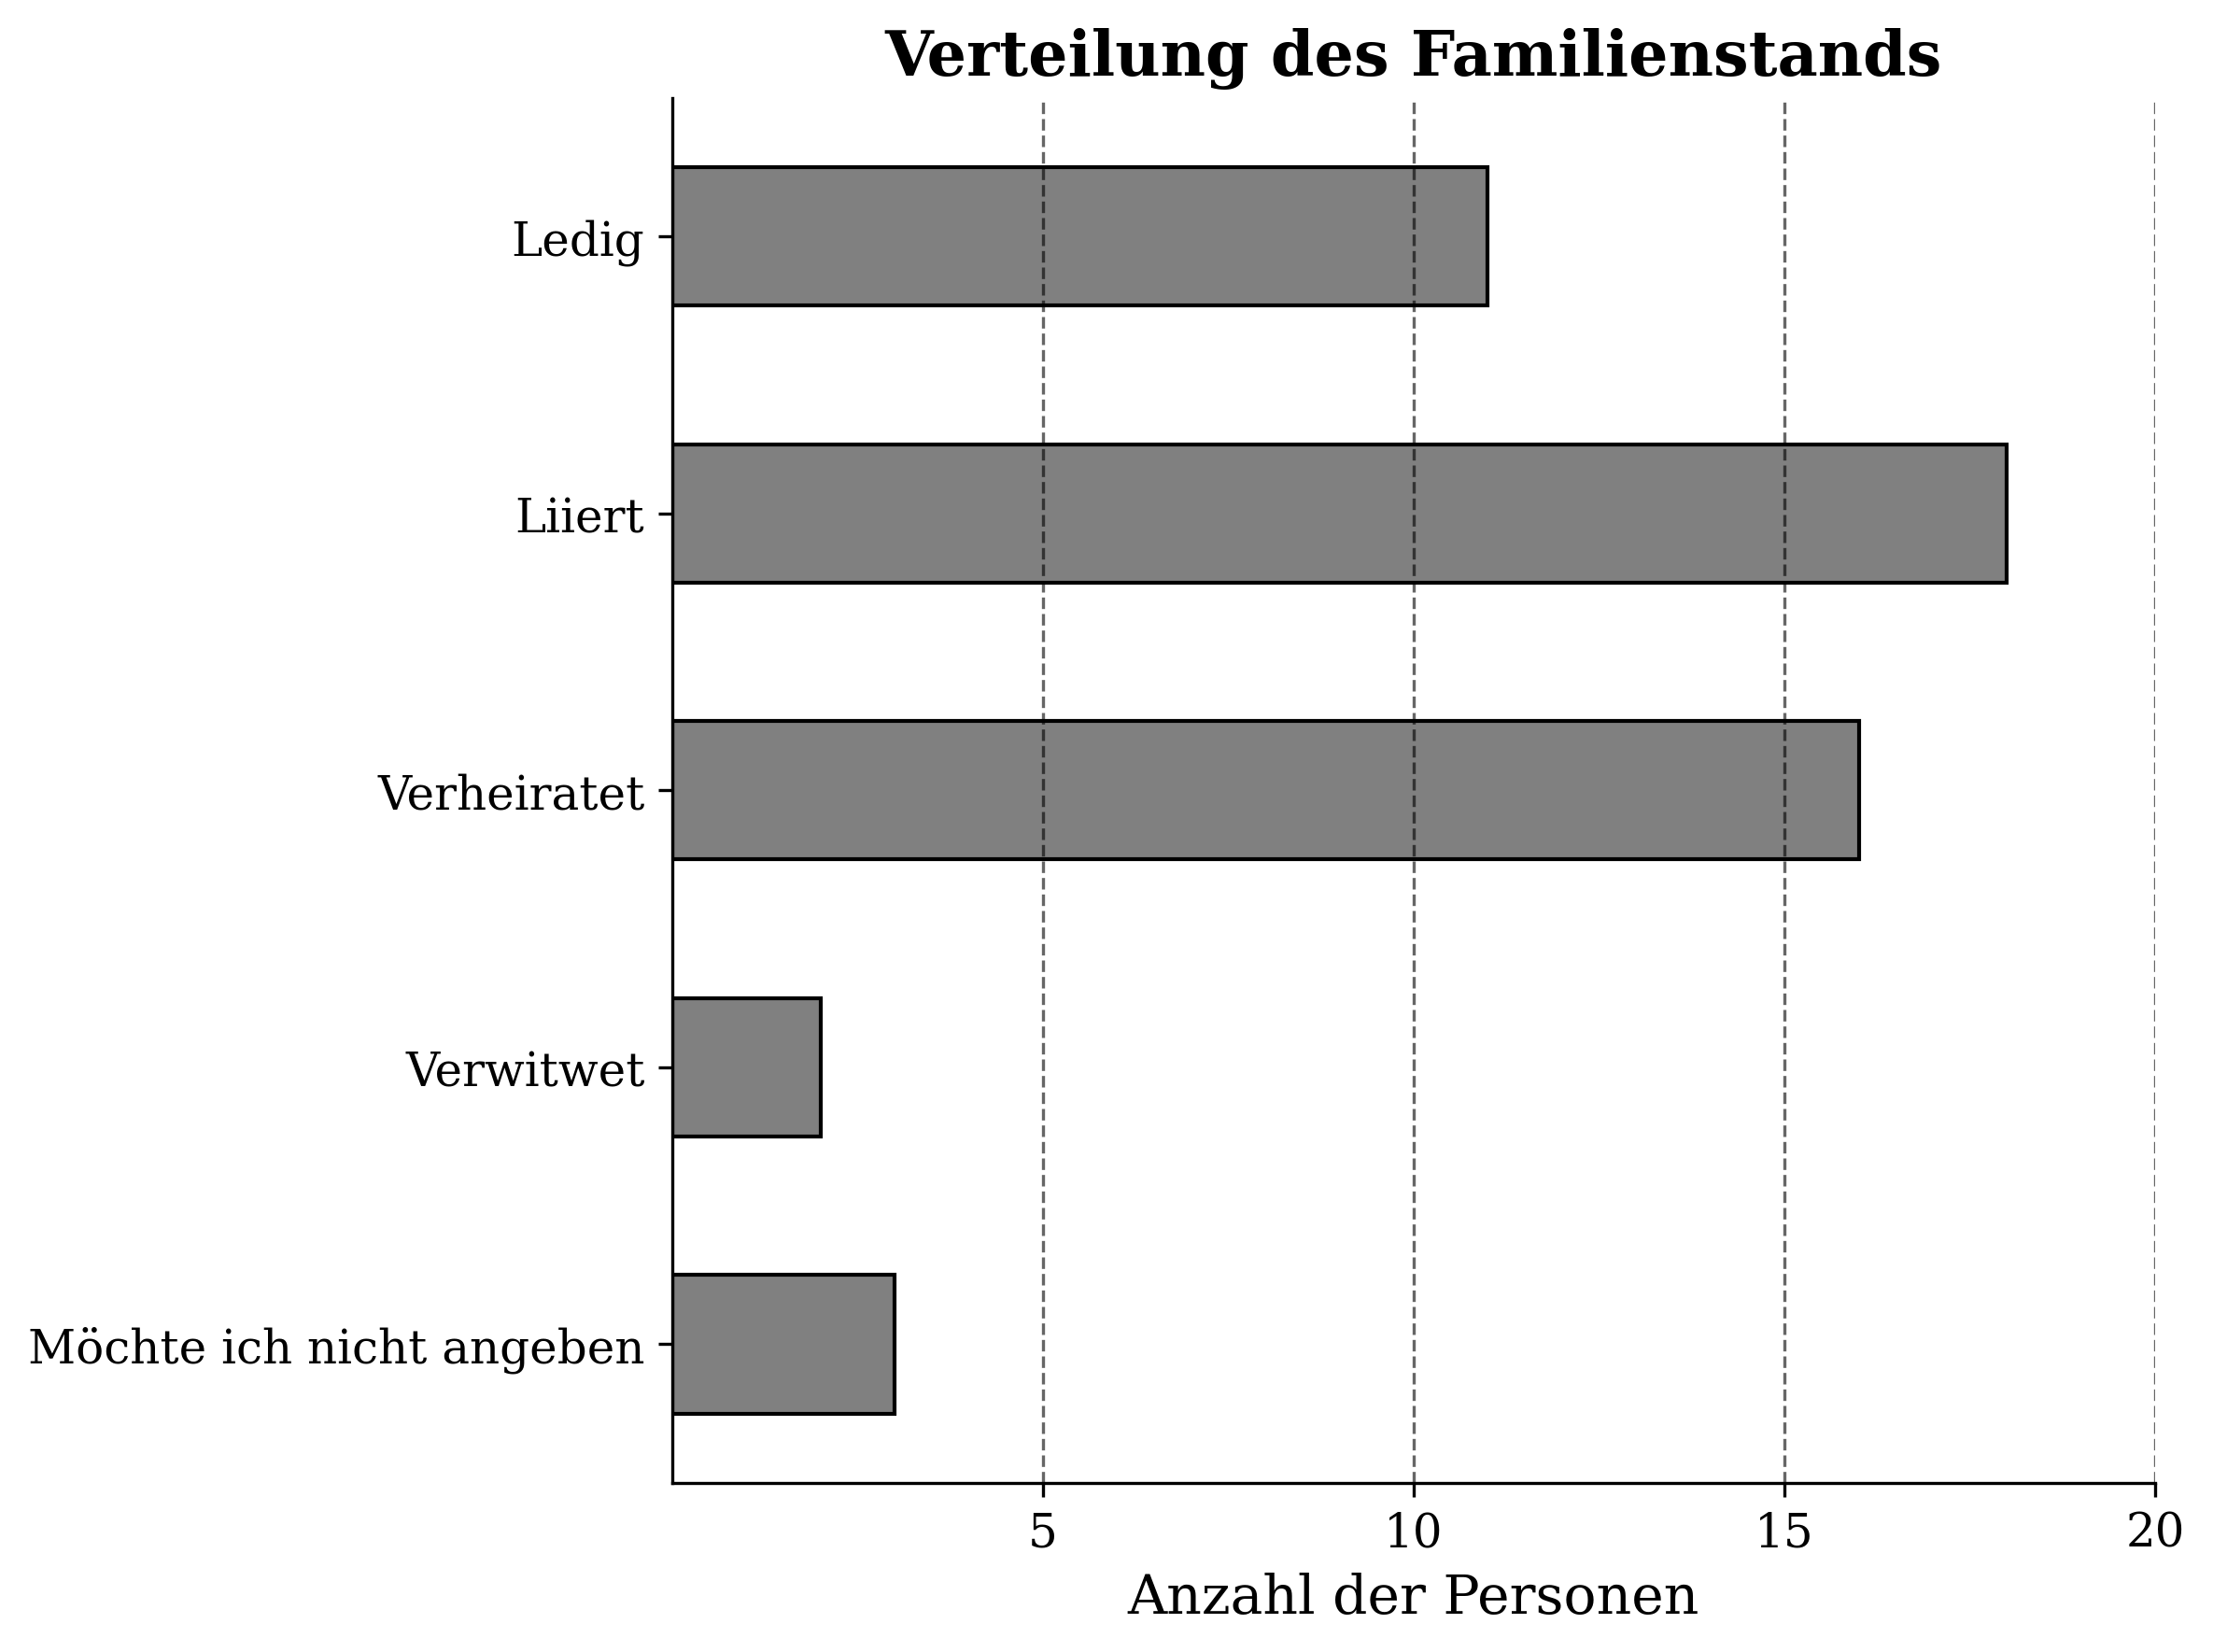

In [349]:
# Definiere die gewünschte Reihenfolge der Kategorien, umgekehrt
reihenfolge = ['Möchte ich nicht angeben', 'Verwitwet', 'Verheiratet', 'Liiert', 'Ledig']

# Berechne die Häufigkeit der Antworten und ordne sie nach der umgekehrten Reihenfolge
familienstand_counts = df['Wie ist dein Familienstand?'].value_counts().reindex(reihenfolge)

# Erstelle ein Balkendiagramm der Familienstandsverteilung mit invertierten Achsen und der spezifischen Reihenfolge
plt.figure(figsize=(8, 6), dpi=300)
familienstand_counts.plot(kind='barh', color='gray', edgecolor='black')  # 'barh' für horizontales Balkendiagramm
plt.title('Verteilung des Familienstands', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Anzahl der Personen', fontsize=14, family='serif')
plt.ylabel('')  # Entfernt den Y-Achsentitel
plt.xticks([5, 10, 15, 20], fontsize=12, family='serif')  # Setzt die X-Achsen-Ticks auf 5, 10, 15, 20
plt.yticks(fontsize=12, family='serif')
plt.grid(axis='x', linestyle='--', alpha=0.6, color='black')  # Gitterlinien entlang der X-Achse
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()


## Wie ist dein Familienstand?

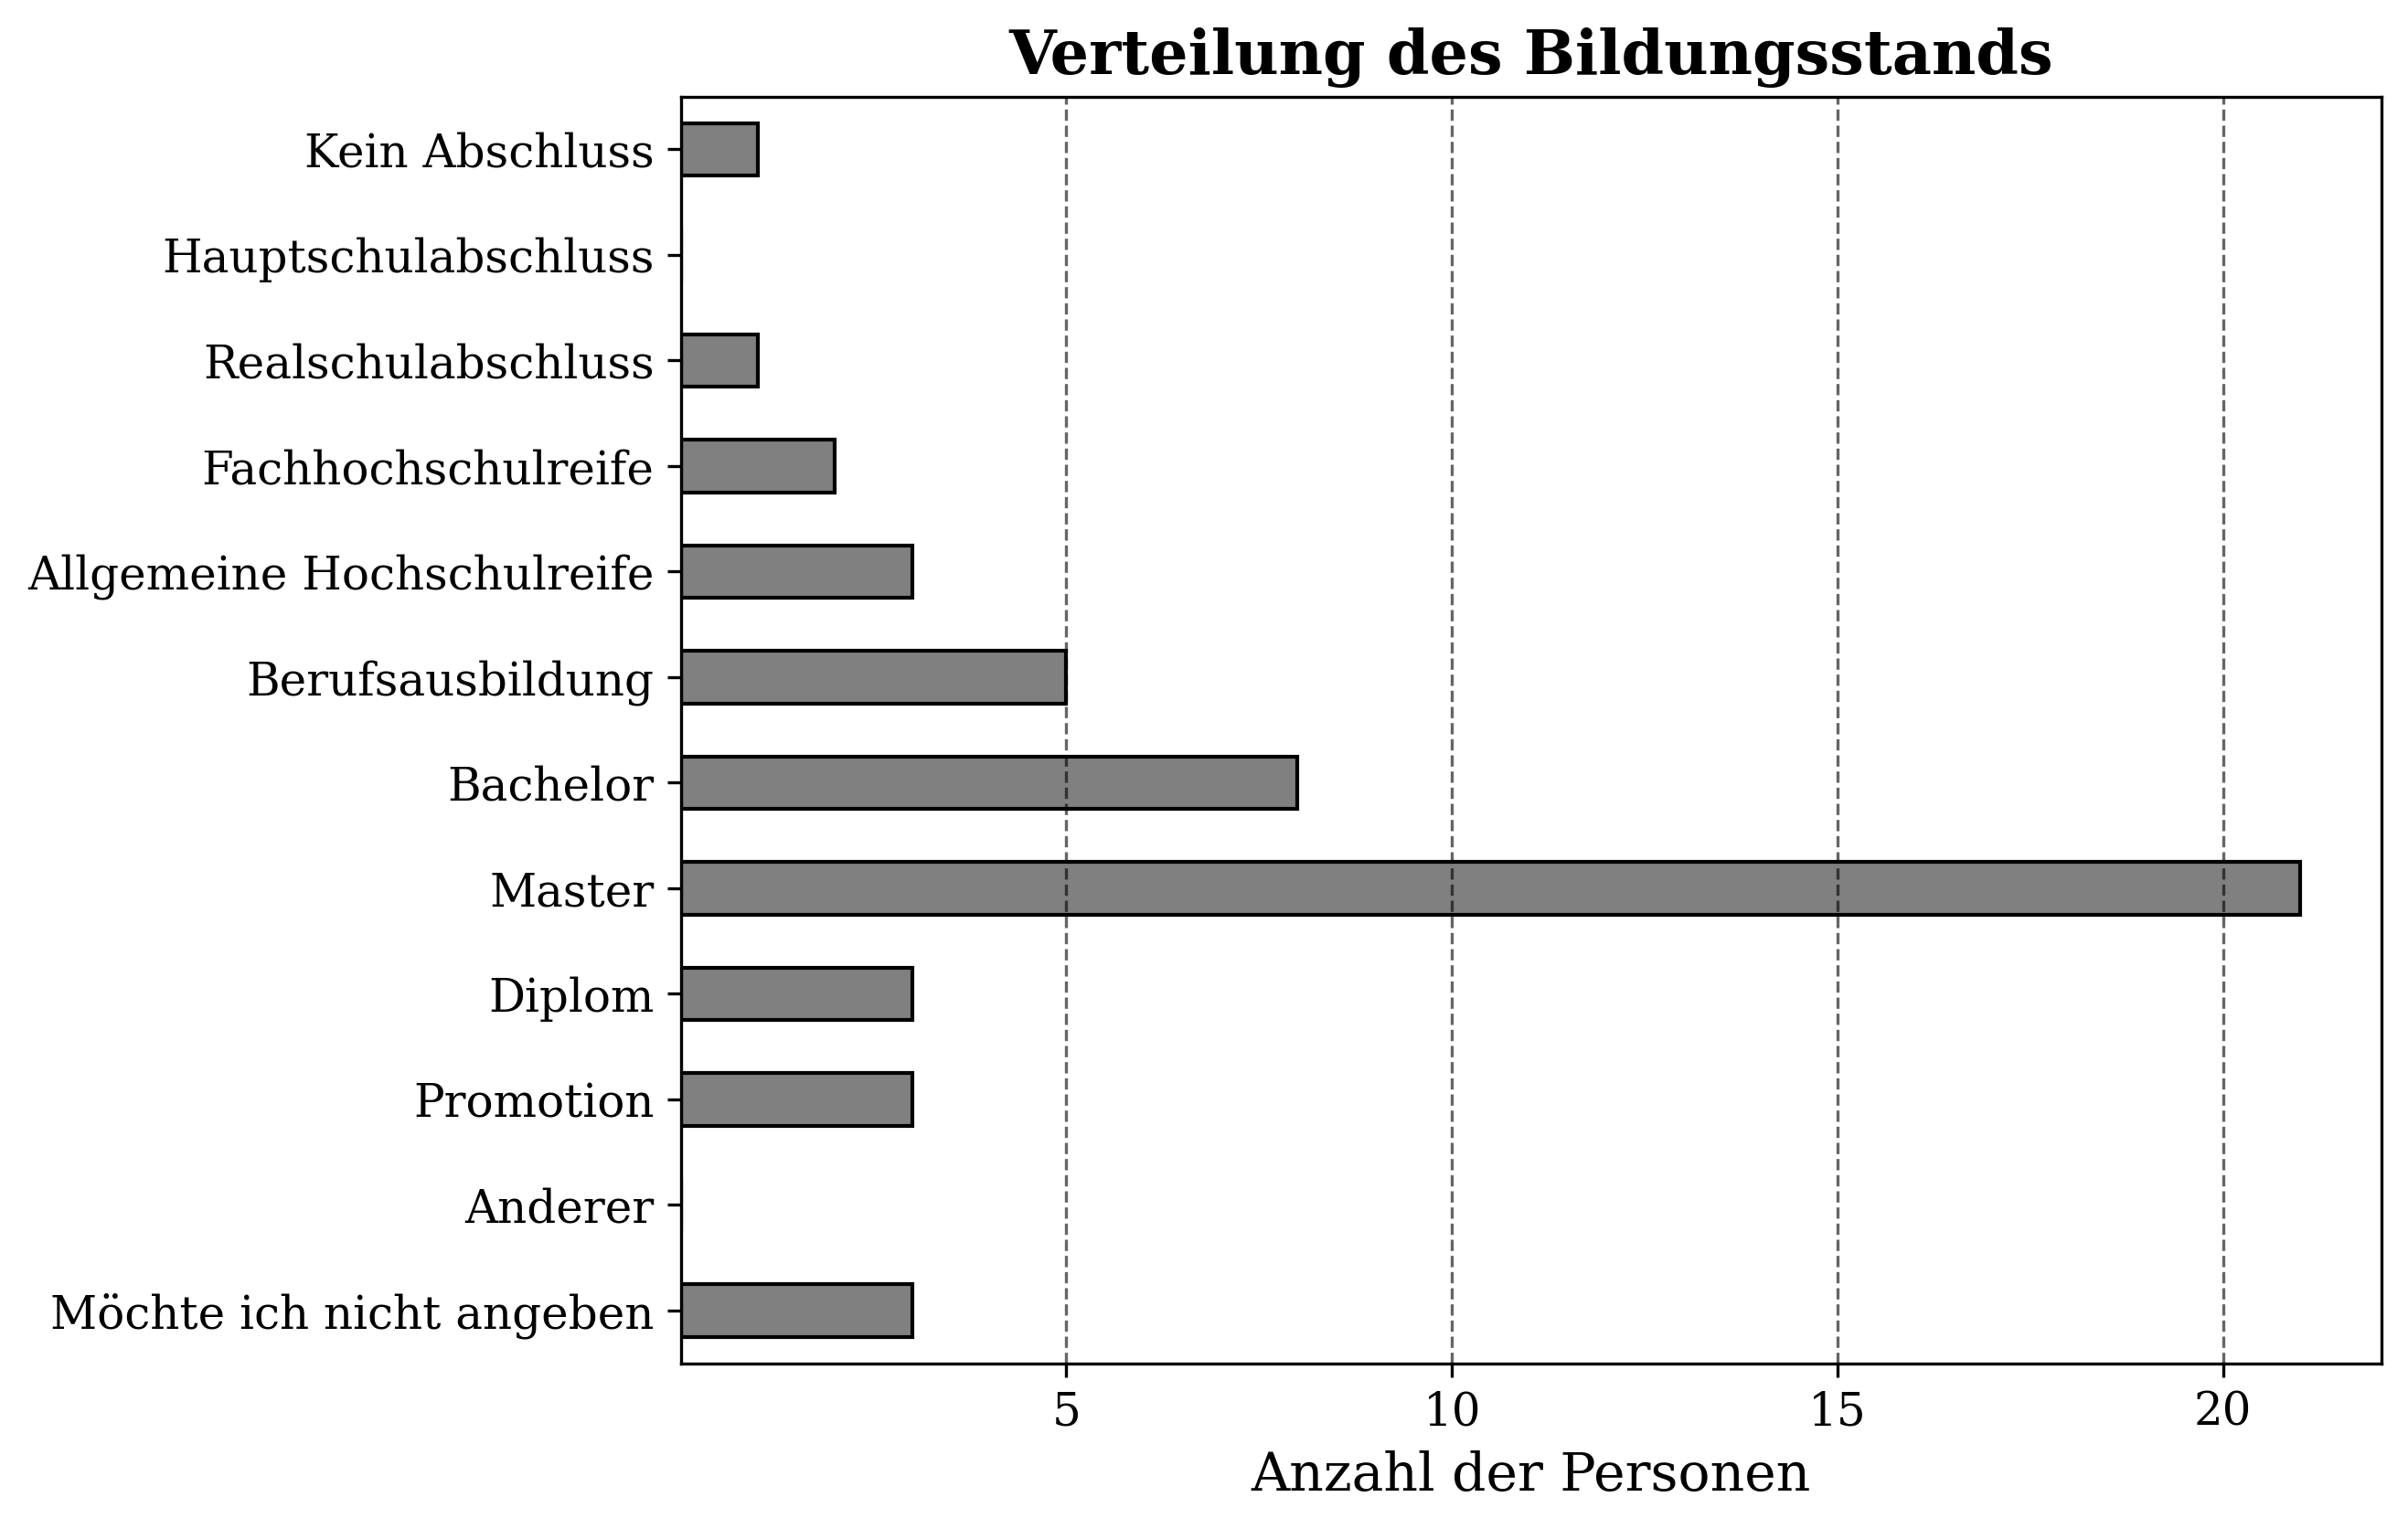

In [350]:
# Definiere die umgekehrte Reihenfolge der Kategorien für den Bildungsstand
reihenfolge_bildungsstand = [
    'Möchte ich nicht angeben',
    'Anderer',
    'Promotion',
    'Diplom',
    'Master',
    'Bachelor',
    'Berufsausbildung',
    'Allgemeine Hochschulreife',
    'Fachhochschulreife',
    'Realschulabschluss',
    'Hauptschulabschluss',
    'Kein Abschluss'
]

# Berechne die Häufigkeit der Antworten und ordne sie nach der umgekehrten Reihenfolge
bildungsstand_counts = df['Welchen höchsten Bildungsstand hast du erreicht?'].value_counts().reindex(reihenfolge_bildungsstand)

# Erstelle ein Balkendiagramm der Bildungsstandsverteilung mit invertierten Achsen und der spezifischen Reihenfolge
plt.figure(figsize=(8, 6), dpi=300)
bildungsstand_counts.plot(kind='barh', color='gray', edgecolor='black')  # 'barh' für horizontales Balkendiagramm
plt.title('Verteilung des Bildungsstands', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Anzahl der Personen', fontsize=14, family='serif')
plt.ylabel('')  # Entfernt den Y-Achsentitel
plt.xticks([5, 10, 15, 20], fontsize=12, family='serif')  # Setzt die X-Achsen-Ticks auf 5, 10, 15, 20
plt.yticks(fontsize=12, family='serif')
plt.grid(axis='x', linestyle='--', alpha=0.6, color='black')  # Gitterlinien entlang der X-Achse


## In welcher Branche arbeitest du?

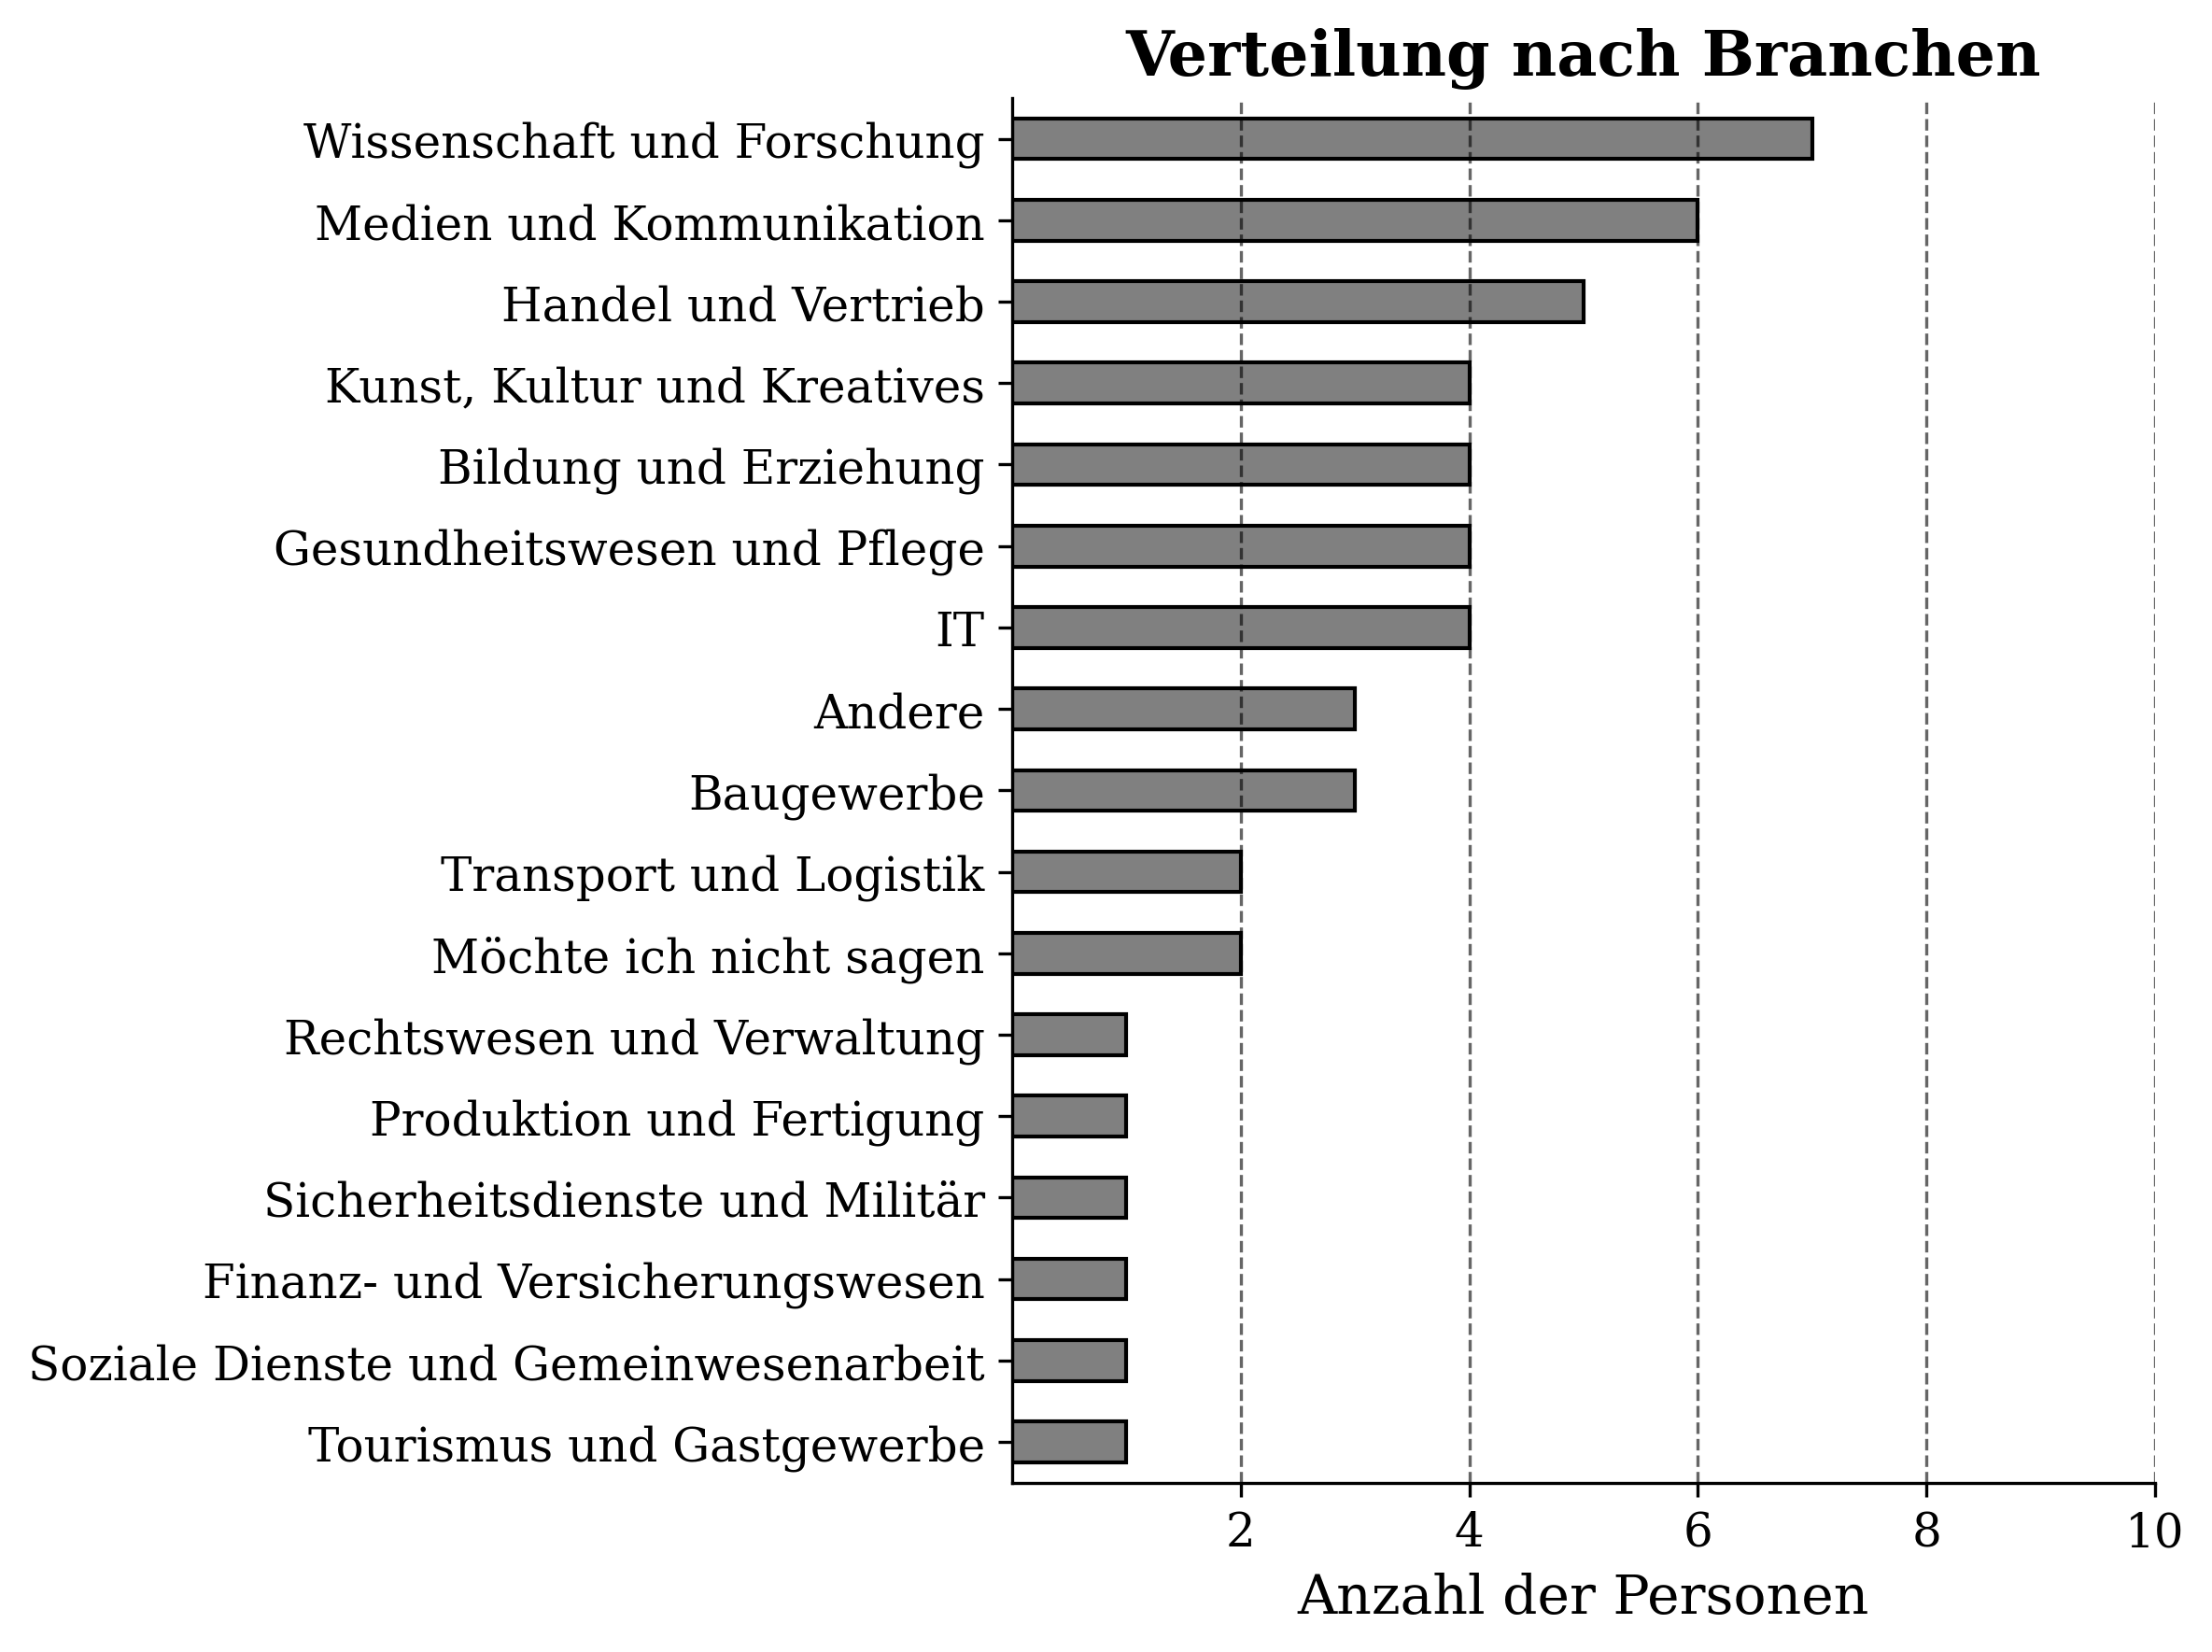

In [351]:
# Berechne die Häufigkeit der Antworten und sortiere sie in aufsteigender Reihenfolge
branche_counts = df['In welcher Branche arbeitest du?'].value_counts(ascending=True)

# Ersetze das Label "Informations- und Kommunikationstechnologie (IT)" durch "IT" im Plot
branche_counts.index = branche_counts.index.str.replace(
    'Informations- und Kommunikationstechnologie (IT)', 'IT')

# Erstelle ein Balkendiagramm der Branchenverteilung mit invertierten Achsen und aufsteigender Sortierung
plt.figure(figsize=(8, 6), dpi=300)
branche_counts.plot(kind='barh', color='gray', edgecolor='black')  # 'barh' für horizontales Balkendiagramm
plt.title('Verteilung nach Branchen', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Anzahl der Personen', fontsize=14, family='serif')
plt.ylabel('')  # Entfernt den Y-Achsentitel
plt.xticks([2, 4, 6, 8, 10], fontsize=12, family='serif')  # Setzt die X-Achsen-Ticks auf 2, 4, 6, 8, 10
plt.yticks(fontsize=12, family='serif')
plt.grid(axis='x', linestyle='--', alpha=0.6, color='black')  # Gitterlinien entlang der X-Achse
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()


## Was ist deine aktuelle Haupttätigkeit (trifft am ehesten zu)?

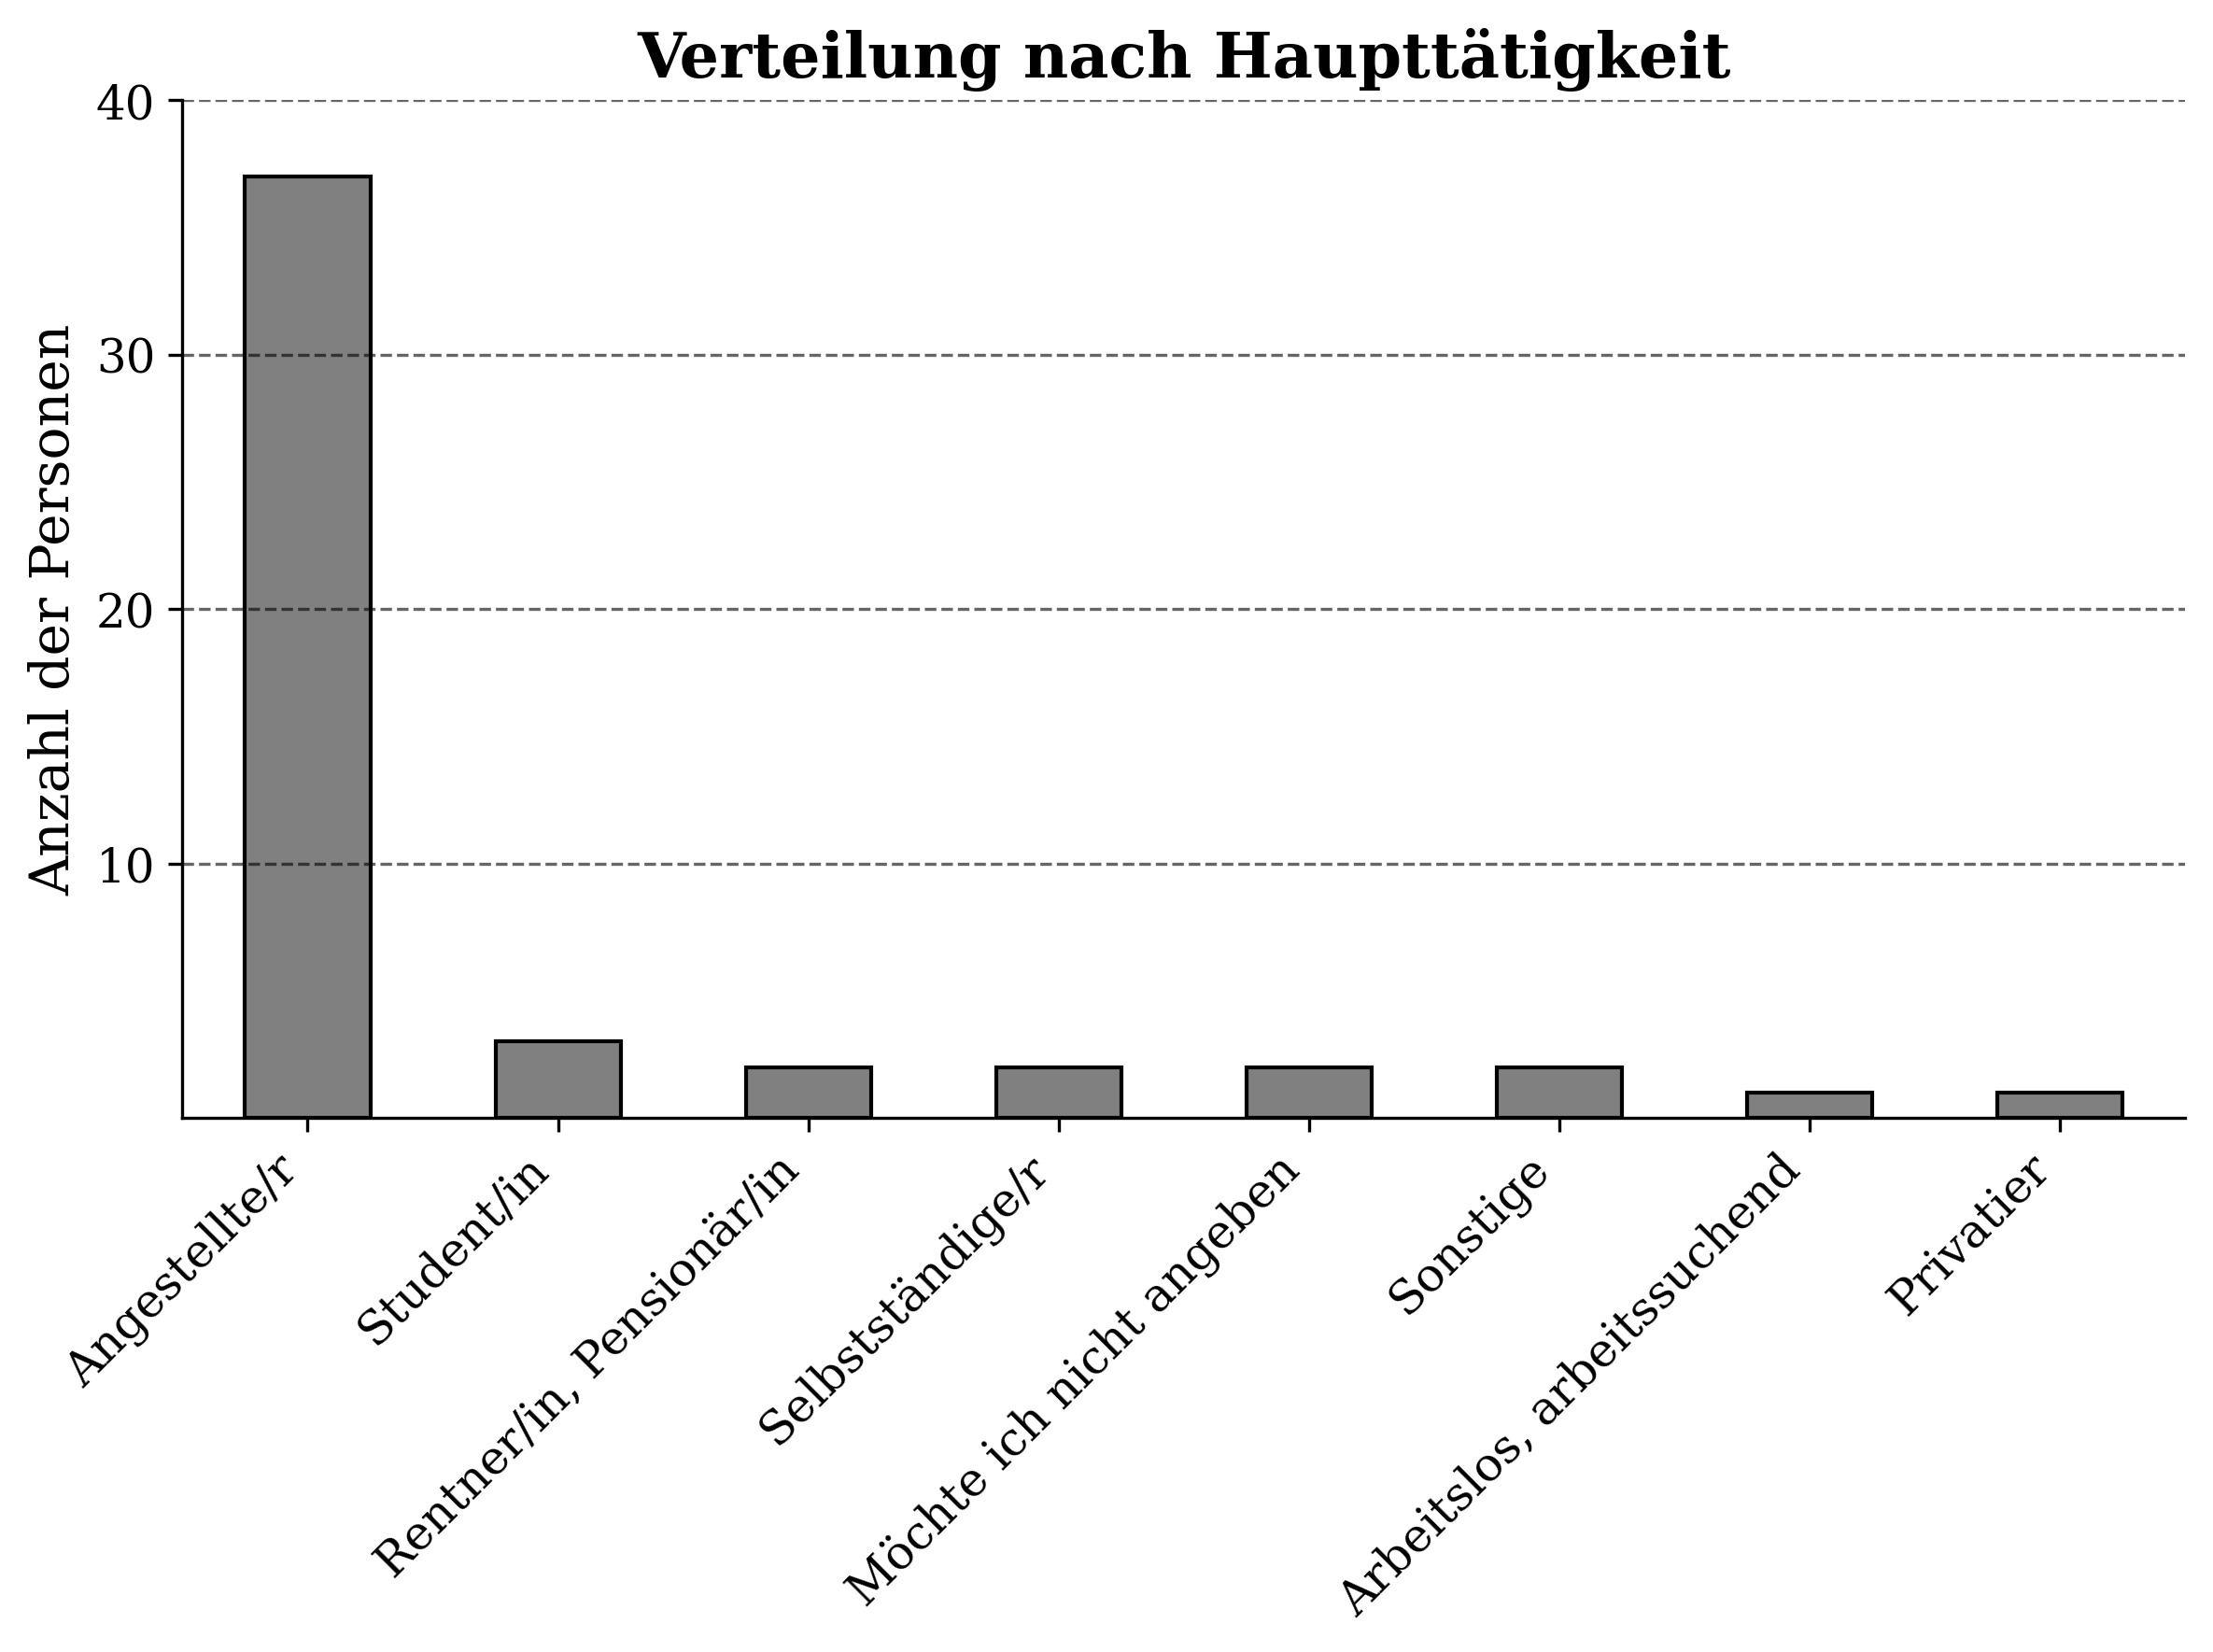

In [352]:
# Berechne die Häufigkeit der Antworten und ersetze im Plot das Label
haupttaetigkeit_counts = df['Was ist deine aktuelle Haupttätigkeit (trifft am ehesten zu)?'].value_counts(ascending=False)

# Ersetze das Label "Ich lebe von Einkünften aus Kapitalvermögen/Vermietungen/Verpachtungen" durch "Privatier"
haupttaetigkeit_counts.index = haupttaetigkeit_counts.index.str.replace(
    'Ich lebe von Einkünften aus Kapitalvermögen/Vermietungen/Verpachtungen', 'Privatier')

# Erstelle ein Balkendiagramm der Haupttätigkeitsverteilung ohne invertierte Achsen
plt.figure(figsize=(8, 6), dpi=300)
haupttaetigkeit_counts.plot(kind='bar', color='gray', edgecolor='black')  # 'bar' für vertikales Balkendiagramm
plt.title('Verteilung nach Haupttätigkeit', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('', fontsize=14, family='serif')
plt.ylabel('Anzahl der Personen', fontsize=14, family='serif')
plt.xticks(rotation=45, ha='right', fontsize=12, family='serif')  # Rotiert die X-Achsen-Beschriftungen
plt.yticks([10, 20, 30, 40], fontsize=12, family='serif')  # Setzt die Y-Achsen-Ticks auf 5, 10, 15, 20
plt.grid(axis='y', linestyle='--', alpha=0.6, color='black')  # Gitterlinien entlang der Y-Achse
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()


## Wie wohnst du

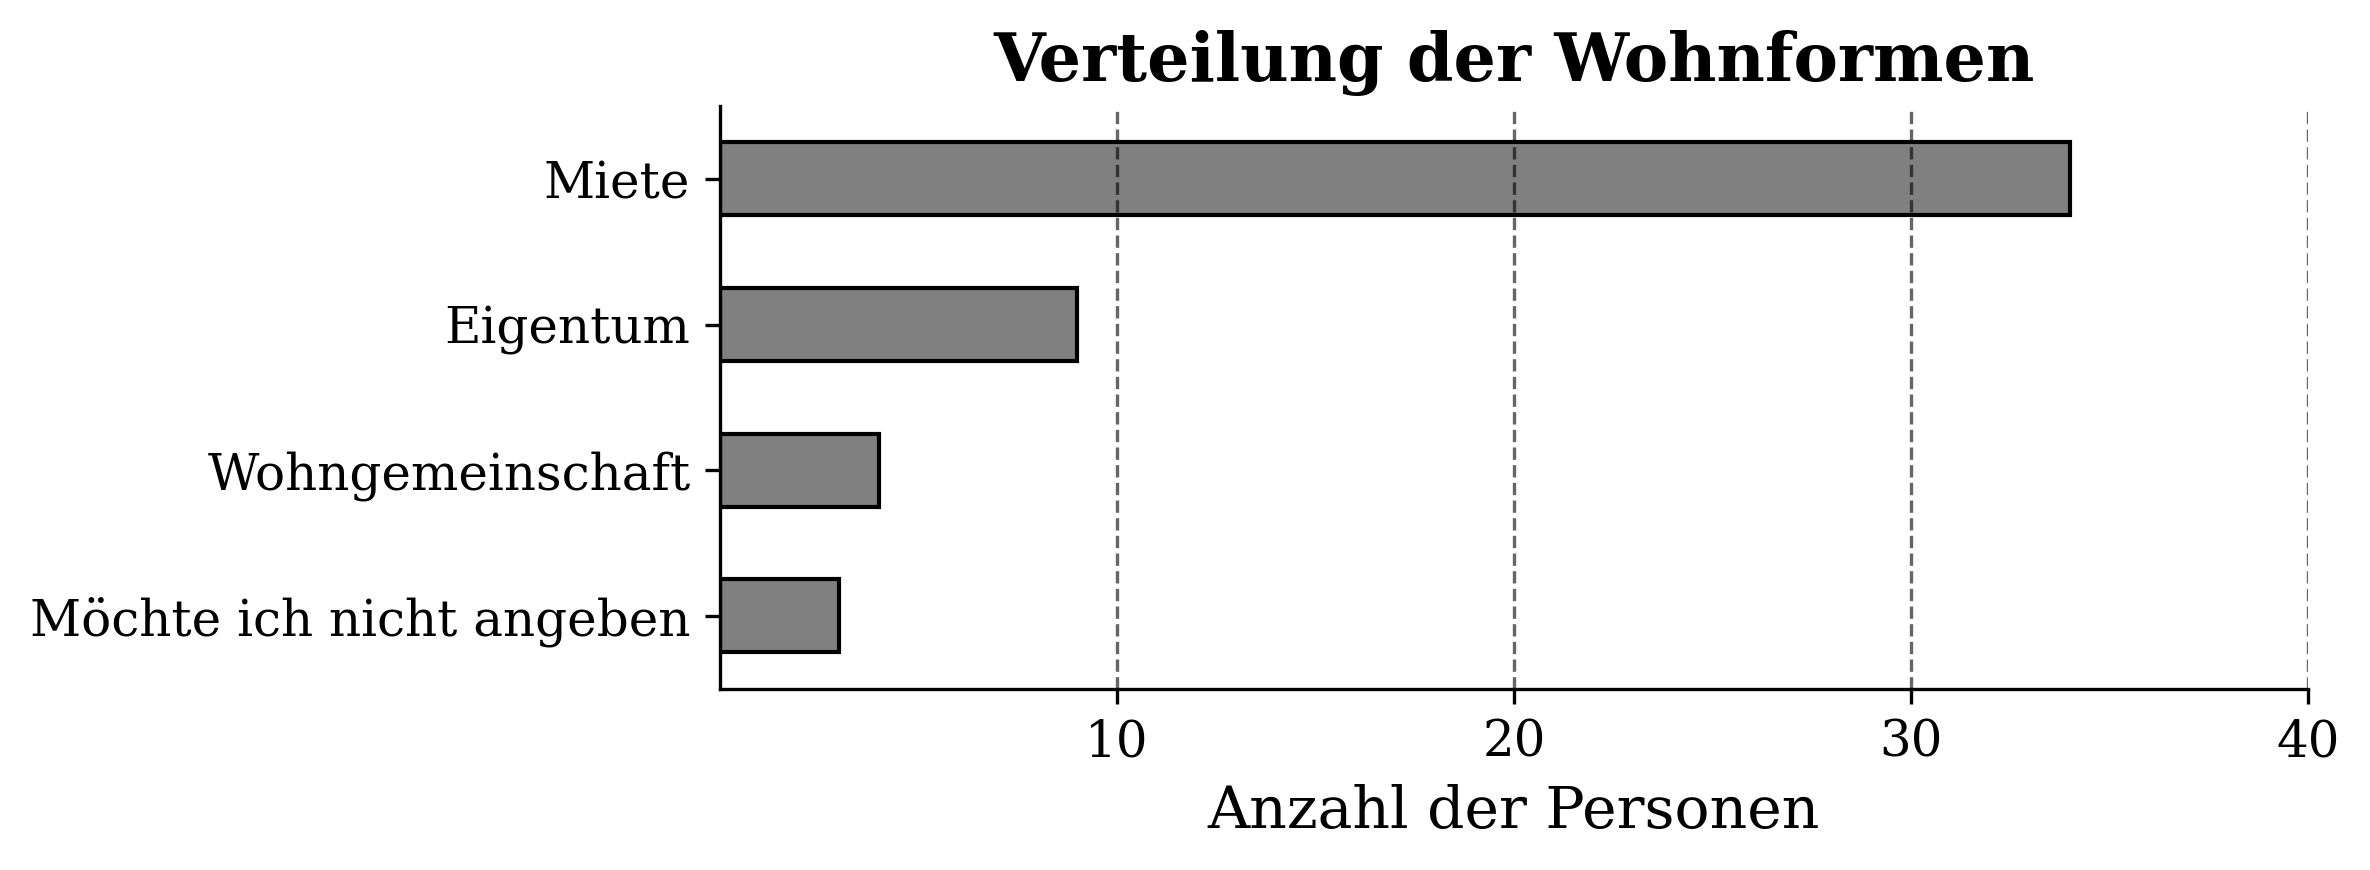

In [353]:
# Berechne die Häufigkeit der Antworten und sortiere sie in absteigender Reihenfolge
wohnform_counts = df['Wie wohnst du?'].value_counts(ascending=True)

# Erstelle ein Balkendiagramm der Wohnformenverteilung mit invertierten Achsen und absteigender Sortierung
plt.figure(figsize=(8, 3), dpi=300)
wohnform_counts.plot(kind='barh', color='gray', edgecolor='black')  # 'barh' für horizontales Balkendiagramm
plt.title('Verteilung der Wohnformen', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Anzahl der Personen', fontsize=14, family='serif')
plt.ylabel('')  # Entfernt den Y-Achsentitel
plt.xticks([10, 20, 30, 40], fontsize=12, family='serif')  # Setzt die X-Achsen-Ticks auf 10, 20, 30, 40
plt.yticks(fontsize=12, family='serif')
plt.grid(axis='x', linestyle='--', alpha=0.6, color='black')  # Gitterlinien entlang der X-Achse
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()


## Wo wohnst du?

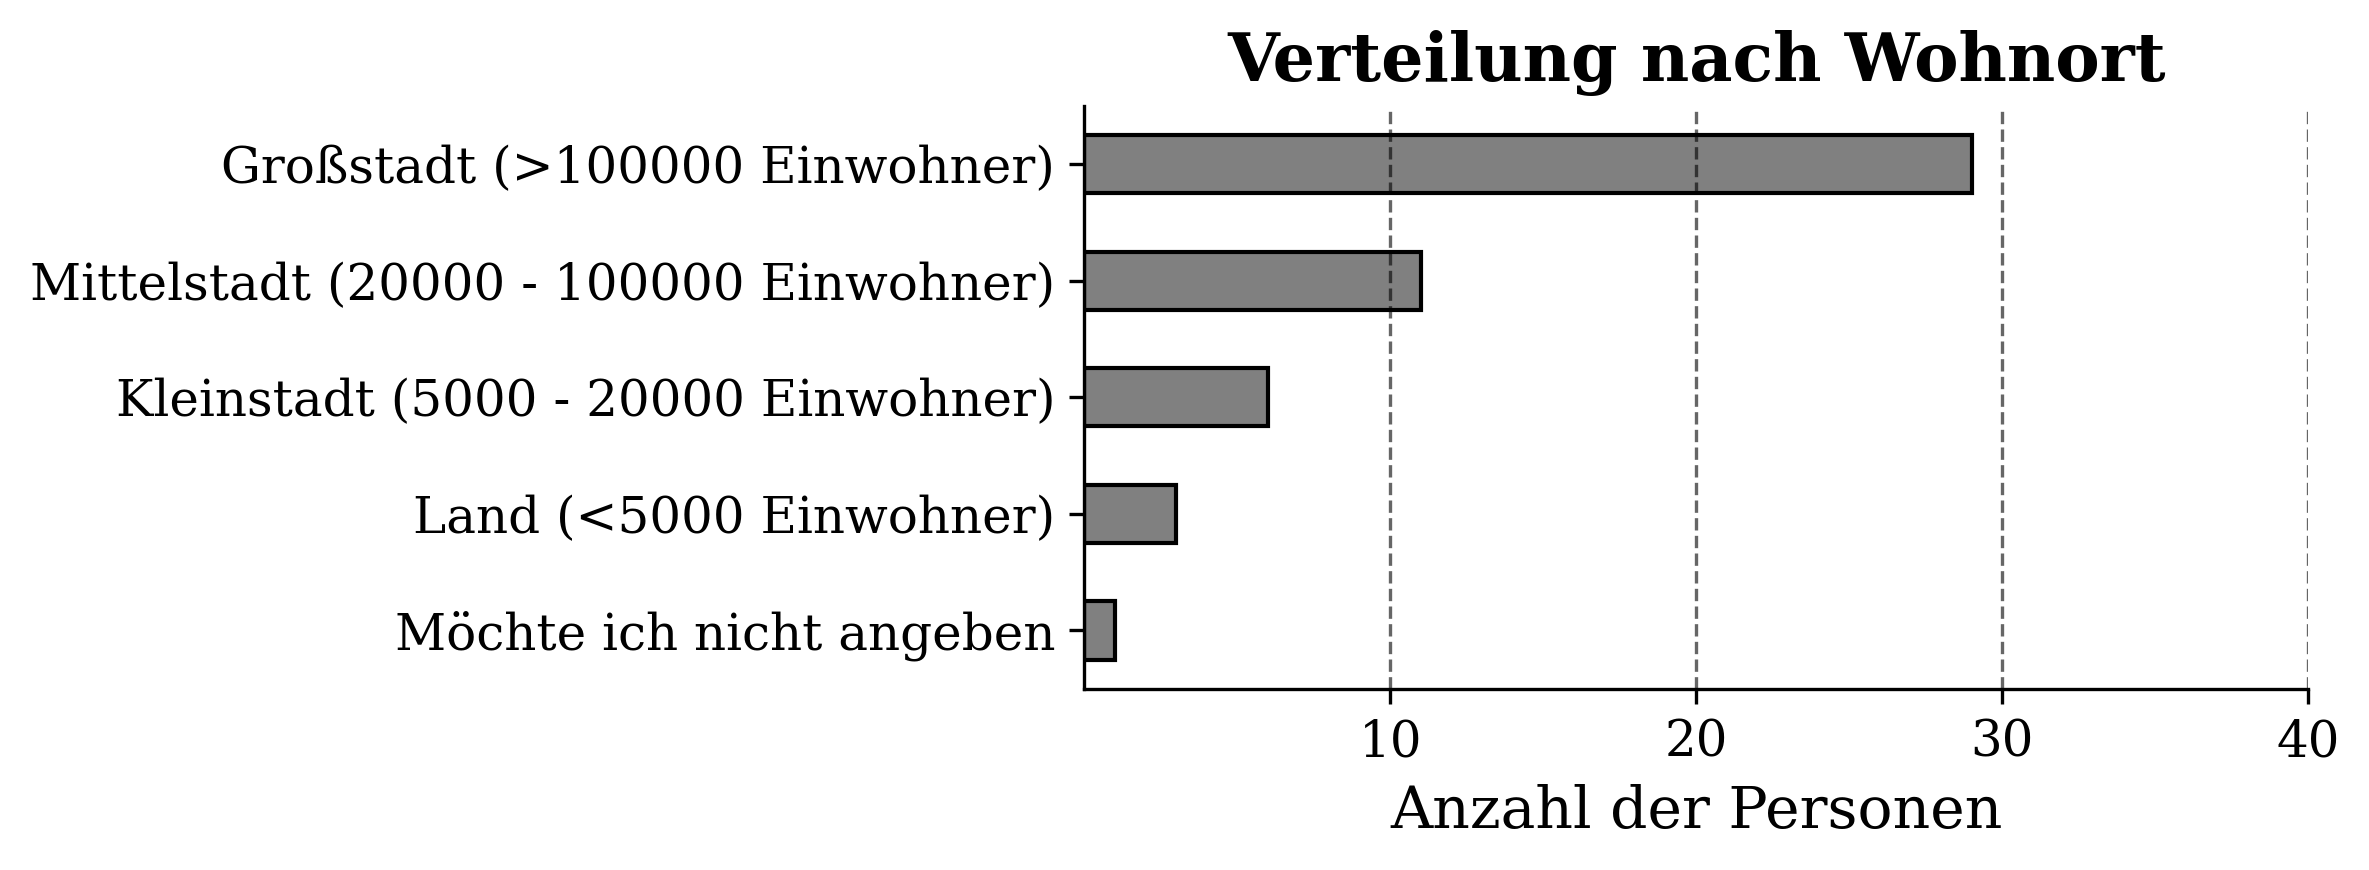

In [354]:
# Berechne die Häufigkeit der Antworten und sortiere sie in absteigender Reihenfolge
wohnort_counts = df['Wo wohnst du?'].value_counts(ascending=True)

# Erstelle ein Balkendiagramm der Wohnortverteilung mit invertierten Achsen und absteigender Sortierung
plt.figure(figsize=(8, 3), dpi=300)
wohnort_counts.plot(kind='barh', color='gray', edgecolor='black')  # 'barh' für horizontales Balkendiagramm
plt.title('Verteilung nach Wohnort', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Anzahl der Personen', fontsize=14, family='serif')
plt.ylabel('')  # Entfernt den Y-Achsentitel
plt.xticks([10, 20, 30, 40], fontsize=12, family='serif')  # Setzt die X-Achsen-Ticks auf 10, 20, 30, 40
plt.yticks(fontsize=12, family='serif')
plt.grid(axis='x', linestyle='--', alpha=0.6, color='black')  # Gitterlinien entlang der X-Achse
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()


## Welche Religion hast du?

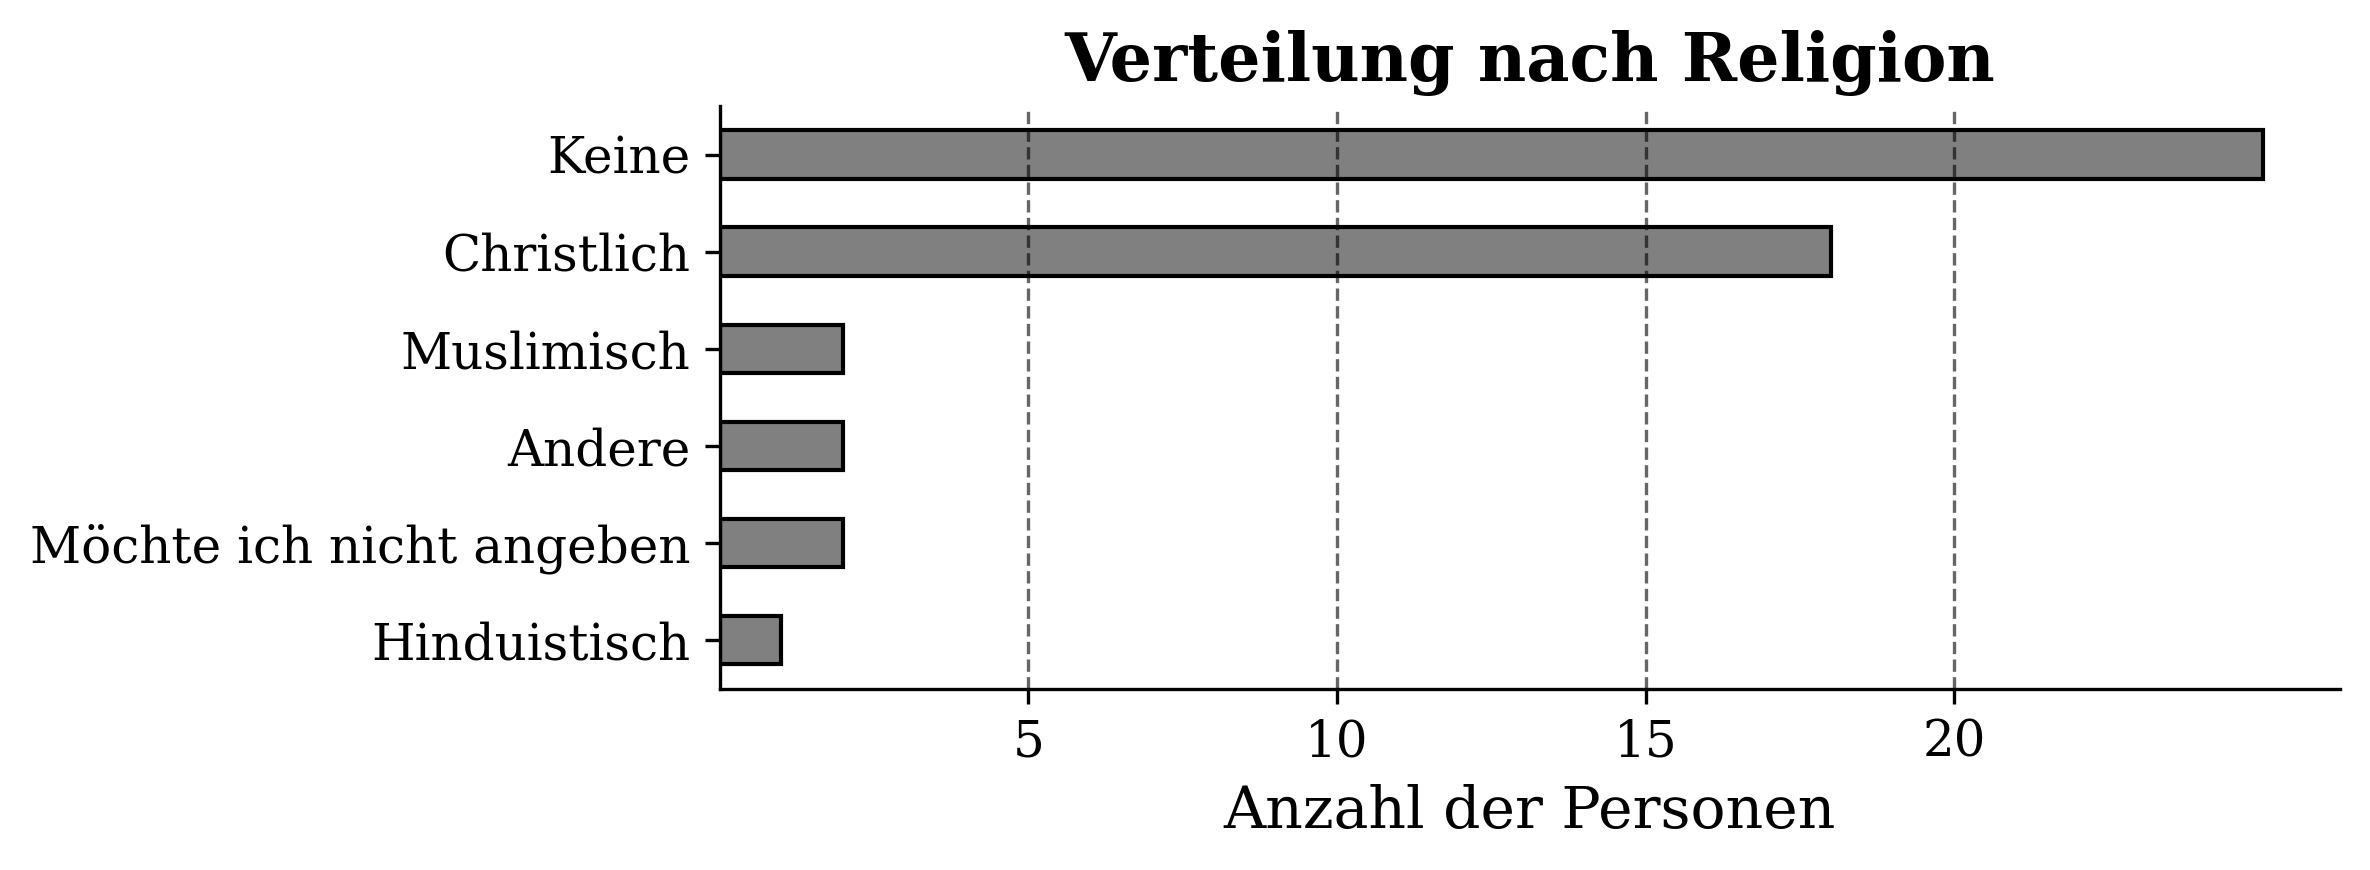

In [355]:
# Berechne die Häufigkeit der Antworten und sortiere sie in absteigender Reihenfolge
religion_counts = df['Welche Religion hast du?'].value_counts(ascending=True)

# Erstelle ein Balkendiagramm der Religionsverteilung mit invertierten Achsen und absteigender Sortierung
plt.figure(figsize=(8, 3), dpi=300)
religion_counts.plot(kind='barh', color='gray', edgecolor='black')  # 'barh' für horizontales Balkendiagramm
plt.title('Verteilung nach Religion', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Anzahl der Personen', fontsize=14, family='serif')
plt.ylabel('')  # Entfernt den Y-Achsentitel
plt.xticks([5, 10, 15, 20], fontsize=12, family='serif')  # Setzt die X-Achsen-Ticks auf 5, 10, 15, 20
plt.yticks(fontsize=12, family='serif')
plt.grid(axis='x', linestyle='--', alpha=0.6, color='black')  # Gitterlinien entlang der X-Achse
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()


## Viele Leute verwenden die Begriffe 'links' und 'rechts', wenn es darum geht, unterschiedliche politische Einstellungen zu kennzeichnen. Wenn du an deine eigenen politischen Ansichten denkst, wo würdest du diese Ansichten auf dieser Skala (0 ="links", 10 ="rechts") einstufen?

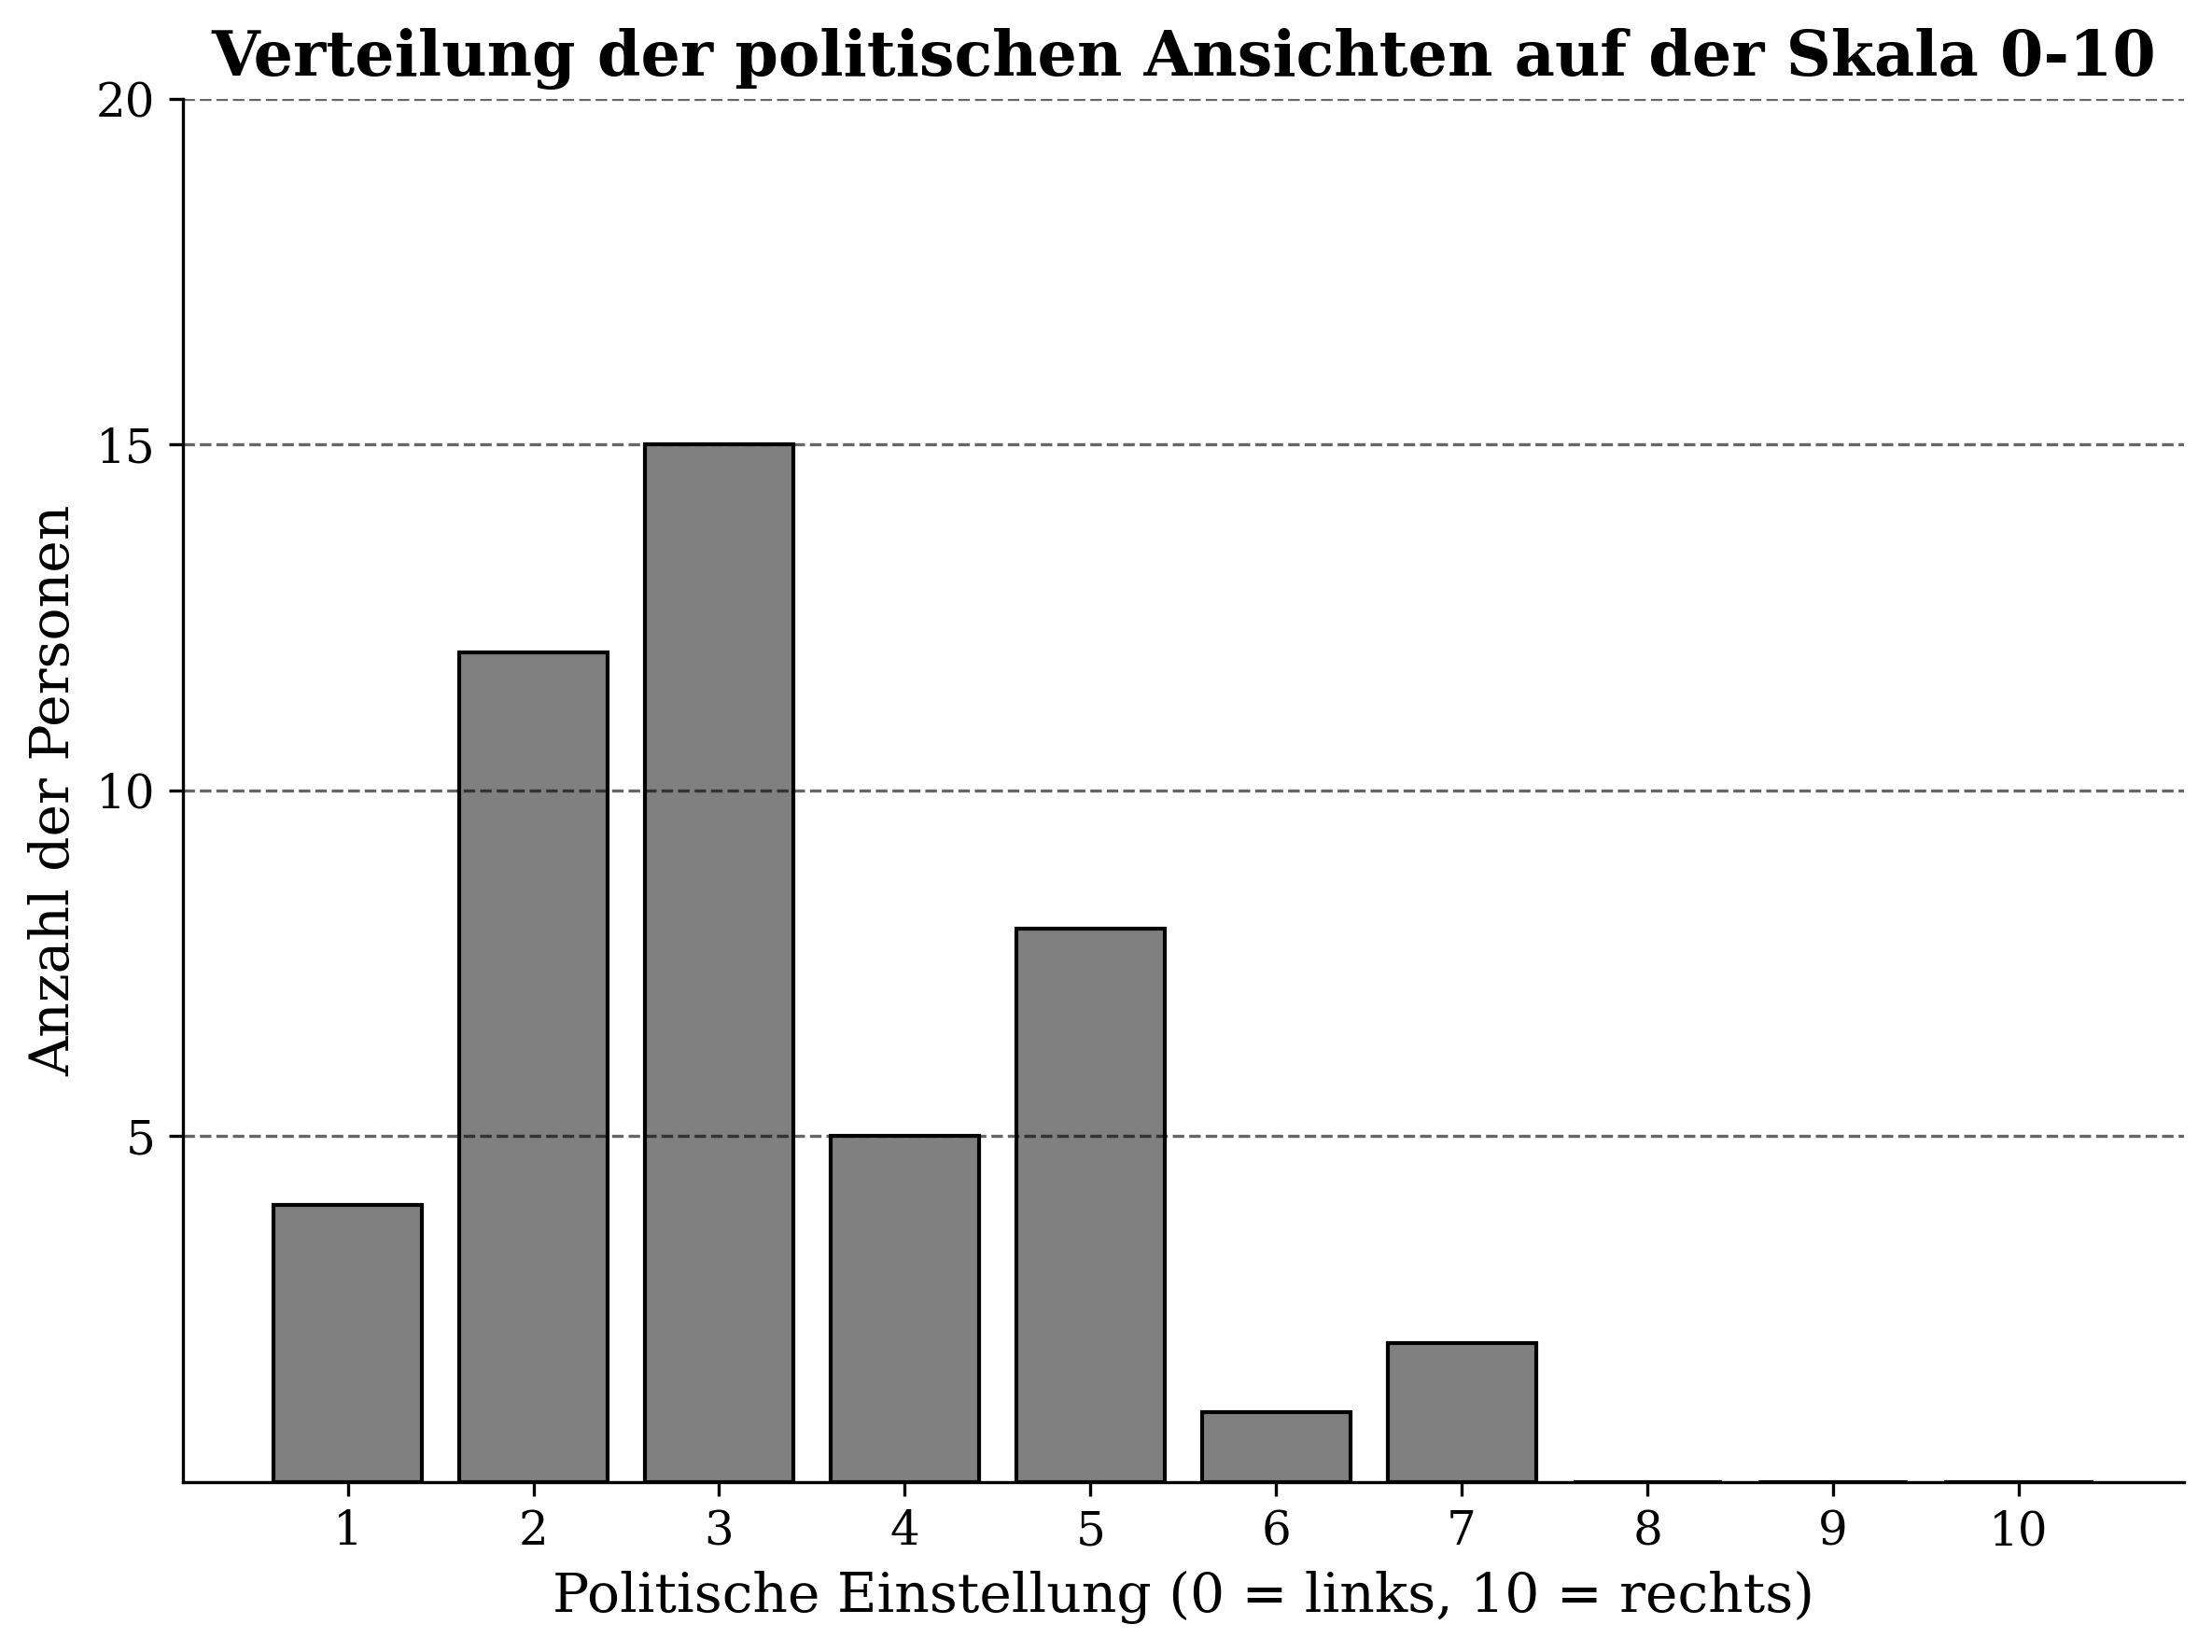

In [356]:
# Filtere die Antworten, um "Übersprungen" zu entfernen
politische_ansichten_filtered = df['Viele Leute verwenden die Begriffe \'links\' und \'rechts\', wenn es darum geht, unterschiedliche politische Einstellungen zu kennzeichnen. Wenn du an deine eigenen politischen Ansichten denkst, wo würdest du diese Ansichten auf dieser Skala (0 ="links", 10 ="rechts") einstufen?'].replace("übersprungen", pd.NA).dropna()

# Berechne die Häufigkeit der gefilterten Antworten und sortiere sie in aufsteigender Reihenfolge der Skala
politische_ansichten_counts = politische_ansichten_filtered.value_counts().sort_index()

politische_ansichten_counts
# Wandel die Series politische_ansichten_counts in ein DataFrame um
# Wandel die Series politische_ansichten_counts in ein DataFrame um
politische_ansichten_df = politische_ansichten_counts.reset_index()

# Benenne die Spalten des DataFrames
politische_ansichten_df.columns = ['Skala', 'Anzahl']

# Stelle sicher, dass die 'Skala'-Spalte den Typ int hat
politische_ansichten_df['Skala'] = politische_ansichten_df['Skala'].astype(int)

# Erstelle einen DataFrame mit den fehlenden Skalenwerten und einer Anzahl von 0
missing_values_df = pd.DataFrame({
    'Skala': [8, 9, 10],
    'Anzahl': [0, 0, 0]
})

# Füge die fehlenden Werte zum bestehenden DataFrame hinzu
politische_ansichten_df = pd.concat([politische_ansichten_df, missing_values_df]).sort_values(by='Skala').reset_index(drop=True)

# Ausgabe des erweiterten DataFrames
politische_ansichten_df

plt.figure(figsize=(8, 6), dpi=300)
plt.bar(politische_ansichten_df['Skala'], politische_ansichten_df['Anzahl'], color='gray', edgecolor='black')
plt.title('Verteilung der politischen Ansichten auf der Skala 0-10', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Politische Einstellung (0 = links, 10 = rechts)', fontsize=14, family='serif')
plt.ylabel('Anzahl der Personen', fontsize=14, family='serif')
plt.xticks([1,2,3,4,5,6,7,8,9,10], rotation=0, fontsize=12, family='serif')  # Keine Rotation für bessere Lesbarkeit
plt.yticks([5, 10, 15, 20], fontsize=12, family='serif')  # Setzt die Y-Achsen-Ticks auf 5, 10, 15, 20
plt.grid(axis='y', linestyle='--', alpha=0.6, color='black')  # Gitterlinien entlang der Y-Achse
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()

## Welche Partei würdest du wählen, wenn am kommenden Sonntag Bundestagswahl wäre?

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\4263169748.py:19: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



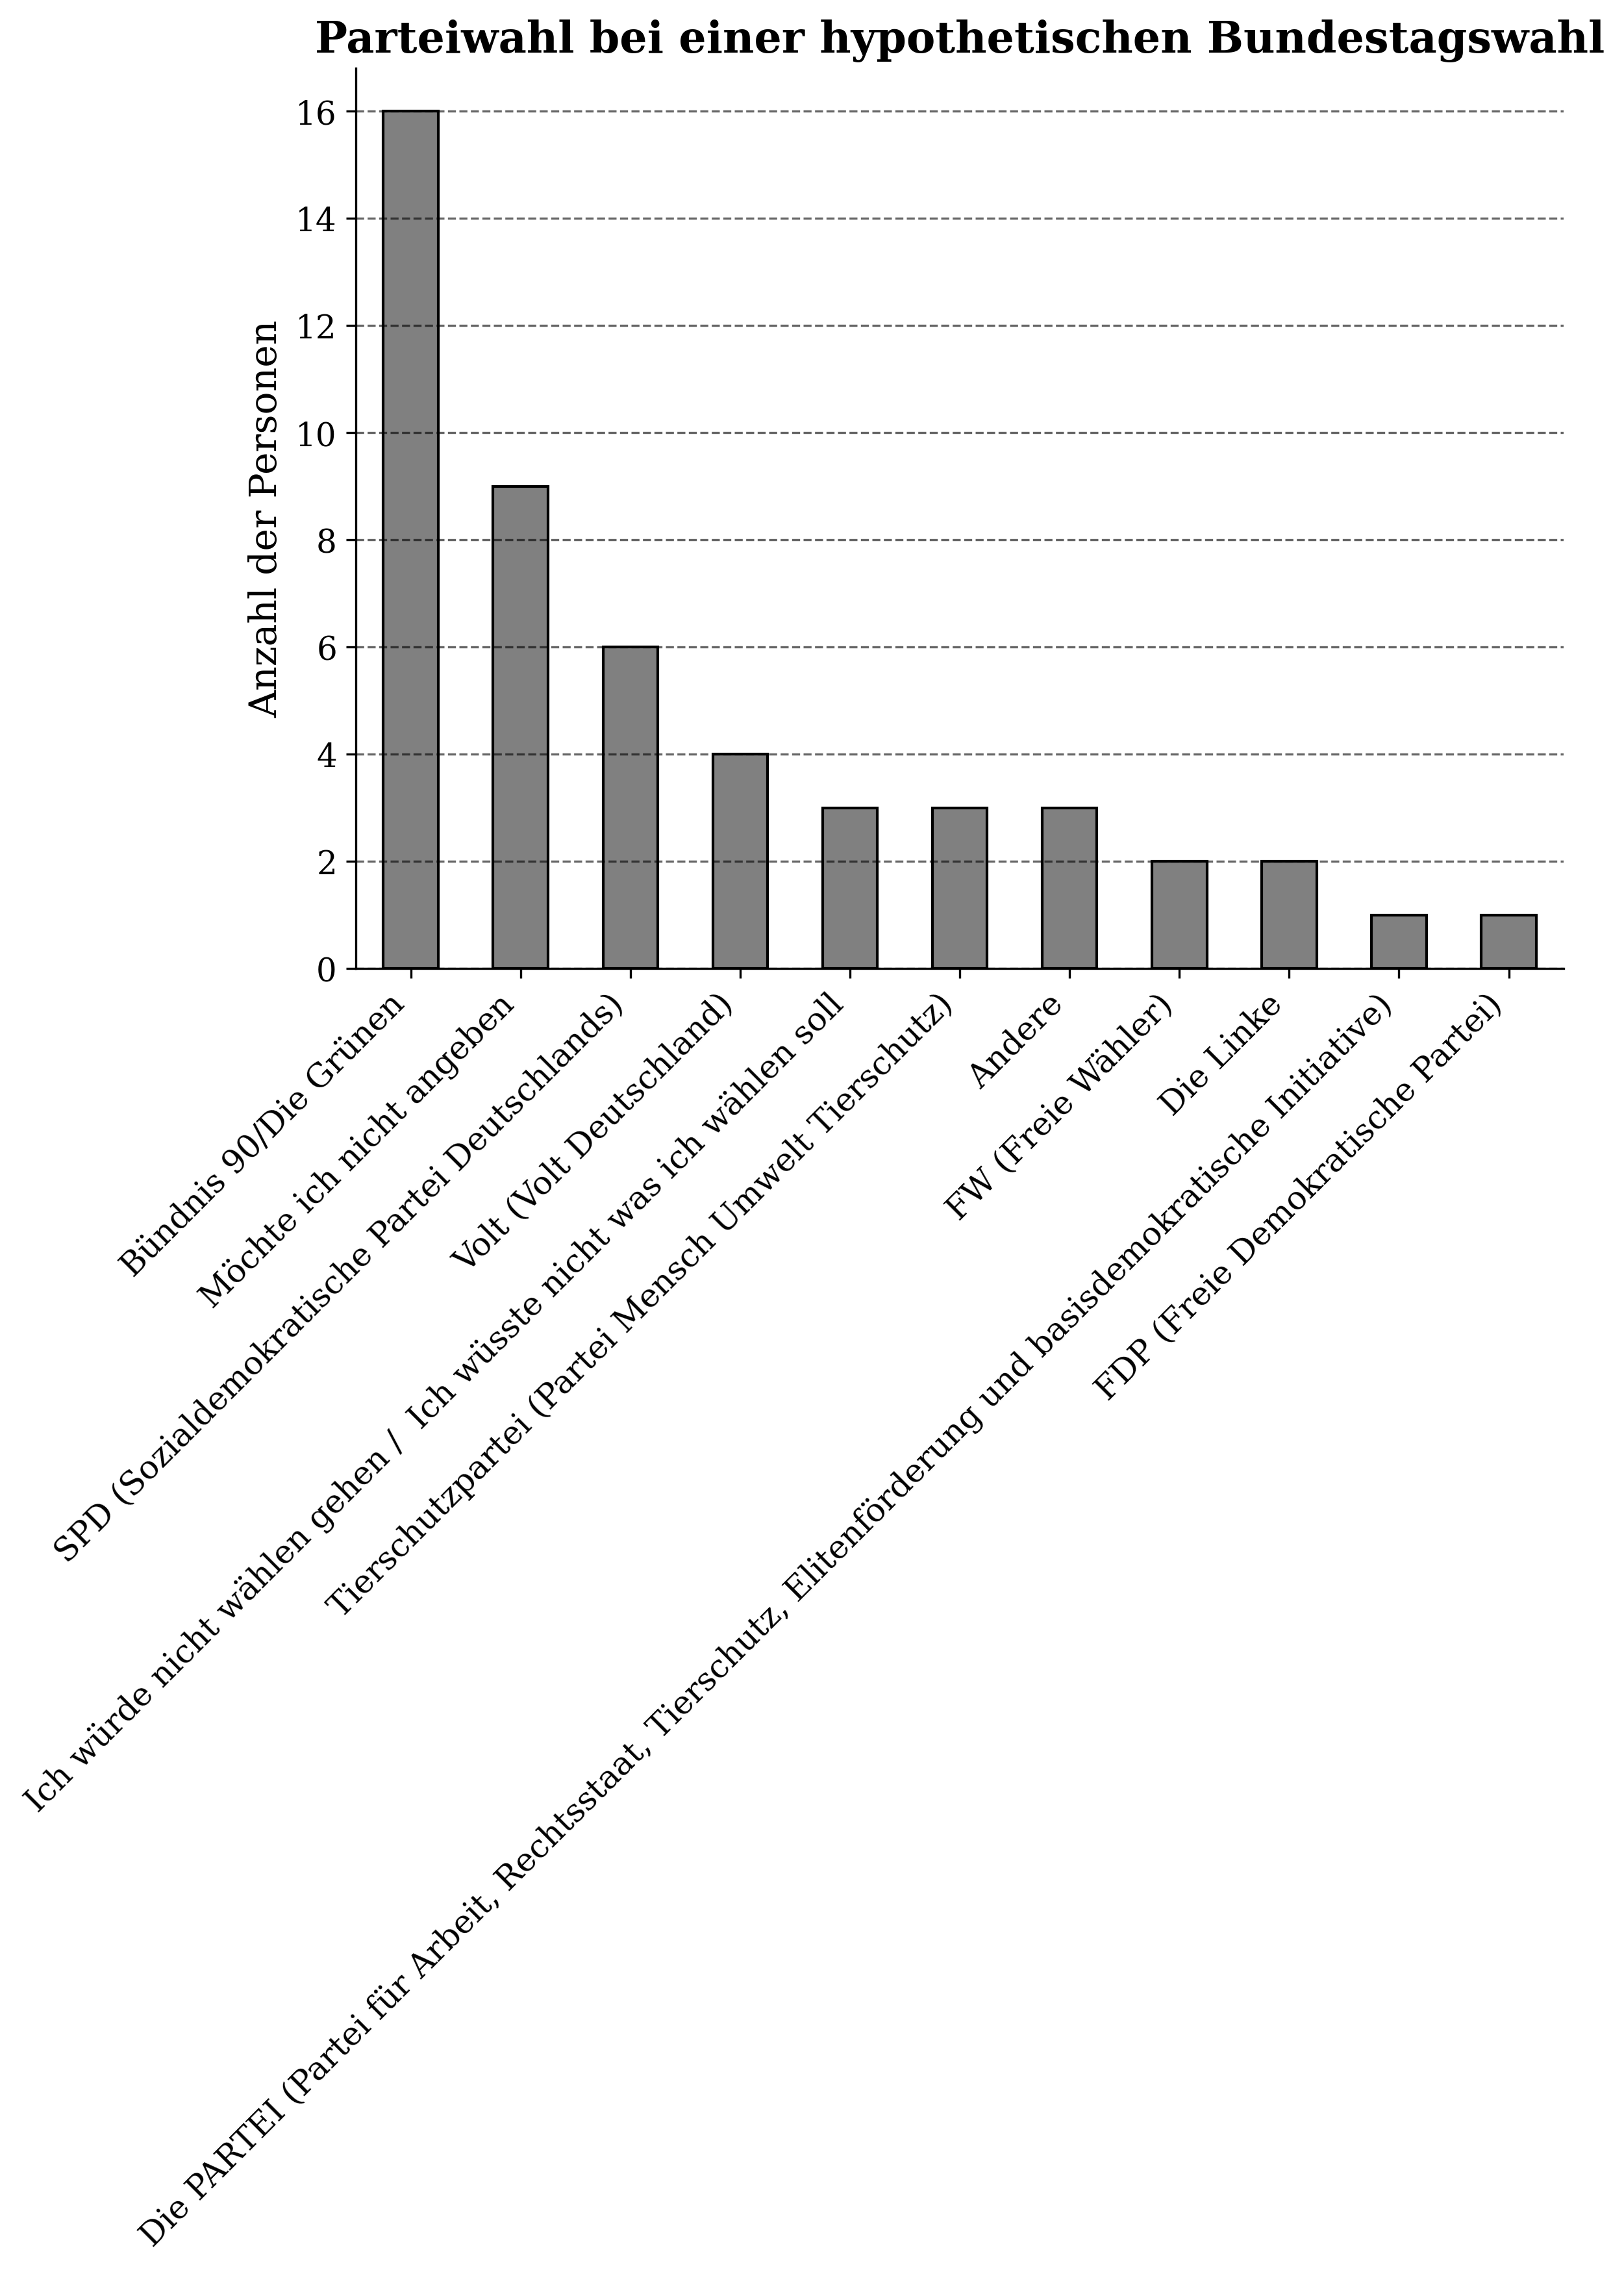

In [357]:
# Berechne die Häufigkeit der Antworten und ersetze im Plot das Label
partei_counts = df['Welche Partei würdest du wählen, wenn am kommenden Sonntag Bundestagswahl wäre?'].value_counts(ascending=False)

# Beispielhafte Ersetzung eines Labels (falls erforderlich)
partei_counts.index = partei_counts.index.str.replace(
    'Die Partei, die du ersetzen möchtest', 'Neues Label')

# Erstelle ein Balkendiagramm der Parteiwahlverteilung ohne invertierte Achsen
plt.figure(figsize=(8, 6), dpi=300)
partei_counts.plot(kind='bar', color='gray', edgecolor='black')  # 'bar' für vertikales Balkendiagramm
plt.title('Parteiwahl bei einer hypothetischen Bundestagswahl', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('', fontsize=14, family='serif')
plt.ylabel('Anzahl der Personen', fontsize=14, family='serif')
plt.xticks(rotation=45, ha='right', fontsize=12, family='serif')  # Rotiert die X-Achsen-Beschriftungen
plt.yticks(fontsize=12, family='serif')  # Y-Achsen-Ticks
plt.grid(axis='y', linestyle='--', alpha=0.6, color='black')  # Gitterlinien entlang der Y-Achse
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\1302032577.py:22: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



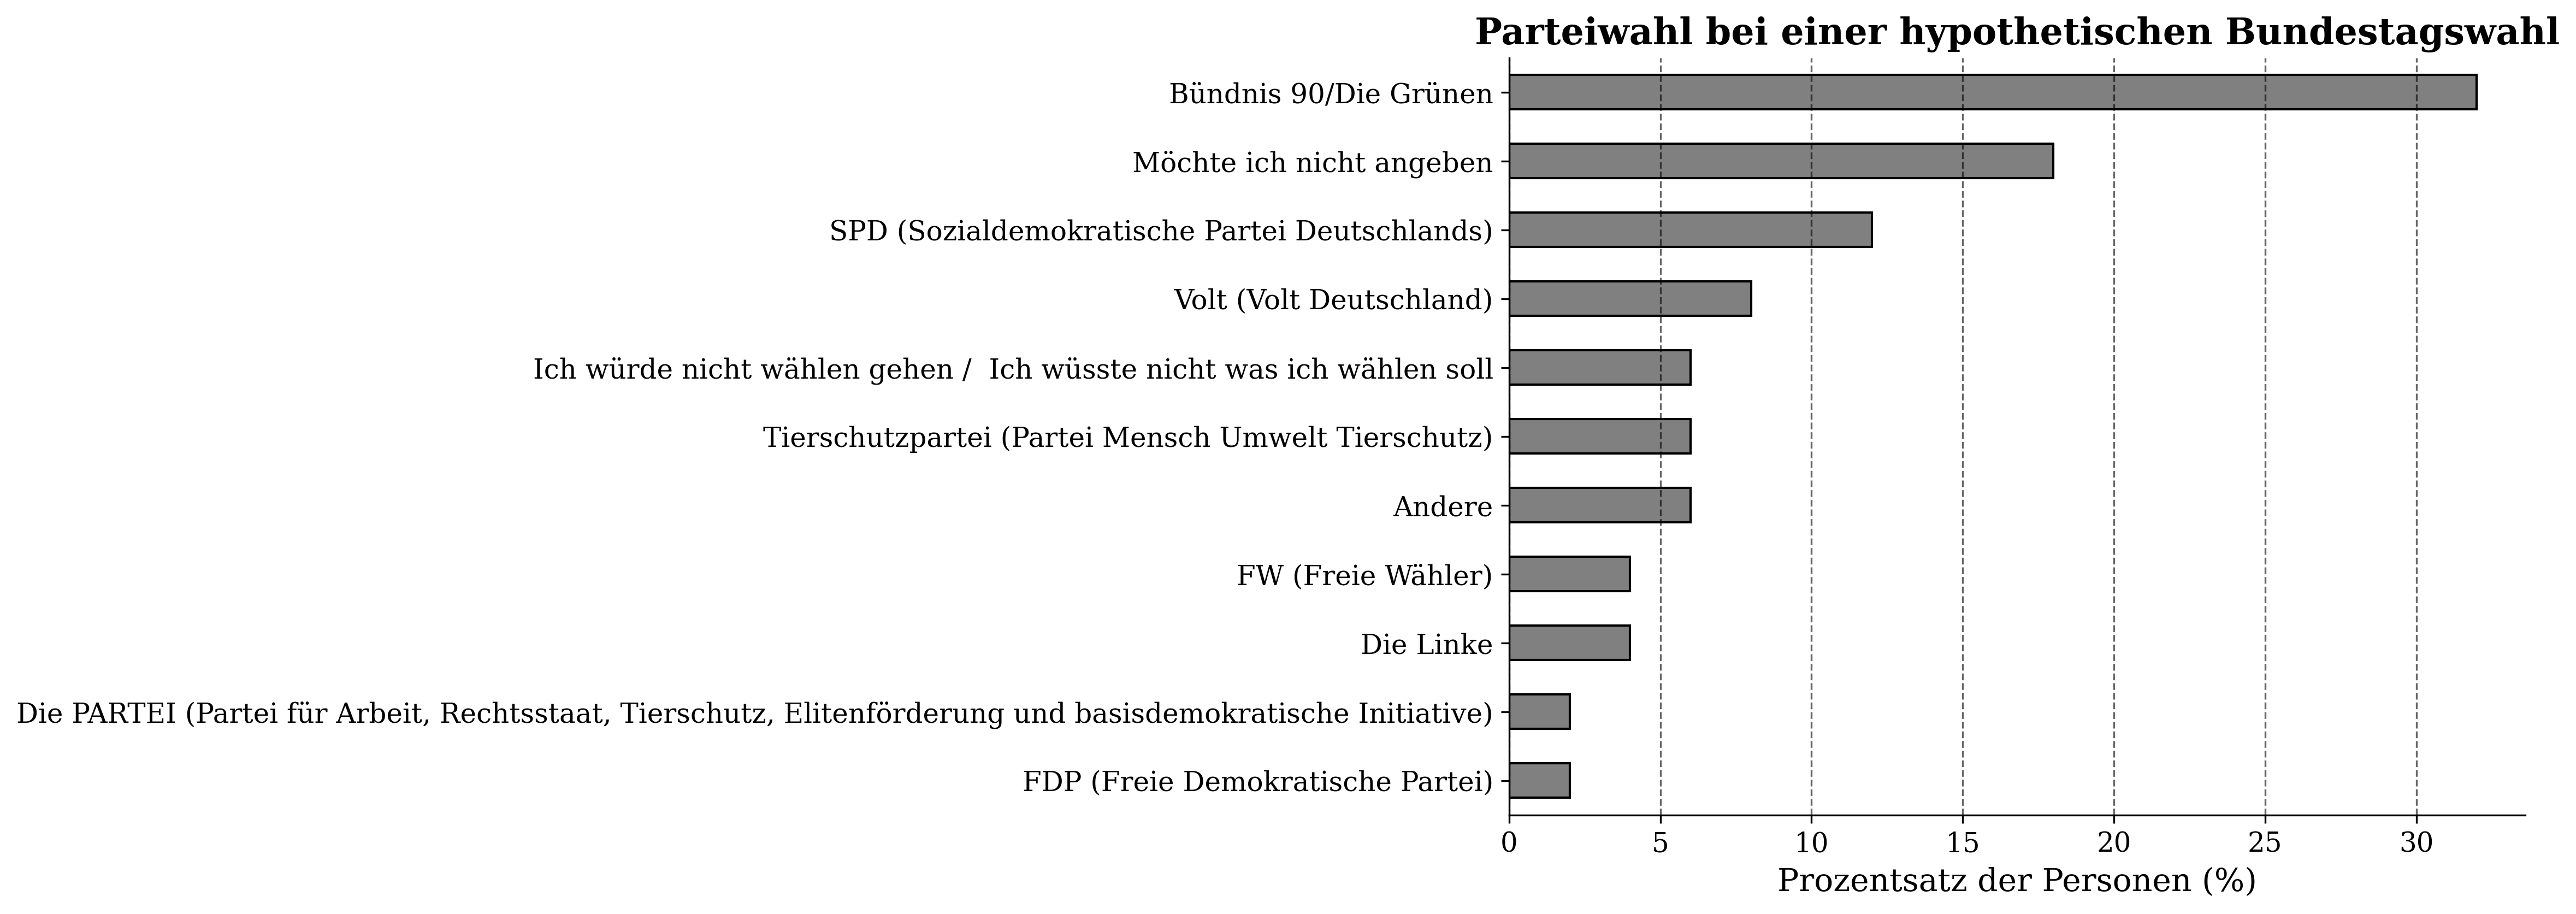

In [358]:
# Berechne die Häufigkeit der Antworten in Prozent und ersetze im Plot das Label
partei_counts = df['Welche Partei würdest du wählen, wenn am kommenden Sonntag Bundestagswahl wäre?'].value_counts(normalize=True) * 100

# Beispielhafte Ersetzung eines Labels (falls erforderlich)
partei_counts.index = partei_counts.index.str.replace(
    'Die Partei, die du ersetzen möchtest', 'Neues Label')

# Kehre die Reihenfolge um
partei_counts = partei_counts.iloc[::-1]

# Erstelle ein Balkendiagramm der Parteiwahlverteilung in Prozent mit invertierten Achsen und umgekehrter Reihenfolge
plt.figure(figsize=(8, 6), dpi=300)
partei_counts.plot(kind='barh', color='gray', edgecolor='black')  # 'barh' für horizontales Balkendiagramm
plt.title('Parteiwahl bei einer hypothetischen Bundestagswahl', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Prozentsatz der Personen (%)', fontsize=14, family='serif')
plt.ylabel('', fontsize=14, family='serif')
plt.xticks(fontsize=12, family='serif')  # X-Achsen-Ticks
plt.yticks(fontsize=12, family='serif')  # Y-Achsen-Beschriftungen
plt.grid(axis='x', linestyle='--', alpha=0.6, color='black')  # Gitterlinien entlang der X-Achse
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()


In [359]:
partei_counts

Welche Partei würdest du wählen, wenn am kommenden Sonntag Bundestagswahl wäre?
FDP (Freie Demokratische Partei)                                                                               2.0
Die PARTEI (Partei für Arbeit, Rechtsstaat, Tierschutz, Elitenförderung und basisdemokratische Initiative)     2.0
Die Linke                                                                                                      4.0
FW (Freie Wähler)                                                                                              4.0
Andere                                                                                                         6.0
Tierschutzpartei (Partei Mensch Umwelt Tierschutz)                                                             6.0
Ich würde nicht wählen gehen /  Ich wüsste nicht was ich wählen soll                                           6.0
Volt (Volt Deutschland)                                                                                        8.0


In [360]:
# Berechne die Häufigkeit der Antworten in Prozent
partei_counts = df['Welche Partei würdest du wählen, wenn am kommenden Sonntag Bundestagswahl wäre?'].value_counts(normalize=True) * 100

# Entferne die spezifischen Kategorien 'Möchte ich nicht angeben' und 'Ich würde nicht wählen gehen / Ich wüsste nicht was ich wählen soll'
partei_counts_filtered = partei_counts.drop([
    'Möchte ich nicht angeben',
    'Ich würde nicht wählen gehen /  Ich wüsste nicht was ich wählen soll'
])

# Identifiziere Parteien mit einem Prozentsatz kleiner als 5%
kleinere_parteien = partei_counts_filtered[partei_counts_filtered < 5]

# Summiere die Prozente der Parteien mit weniger als 5%
andere_summe = kleinere_parteien.sum()

# Entferne diese kleinen Parteien aus dem DataFrame
partei_counts_filtered = partei_counts_filtered[partei_counts_filtered >= 5]

# Füge die summierten Prozente zu 'Andere' hinzu
if 'Andere' in partei_counts_filtered.index:
    partei_counts_filtered['Andere'] += andere_summe
else:
    partei_counts_filtered['Andere'] = andere_summe

# Optional: Um die Reihenfolge zu kehren, falls benötigt
partei_counts_filtered = partei_counts_filtered.iloc[::-1]

# Teile alle Werte durch die Summe aller Werte und multipliziere mit 100, um die Prozente zu normalisieren
partei_counts_filtered = (partei_counts_filtered / partei_counts_filtered.sum()) * 100

# Benenne 'Andere' in 'Sonstige' um
partei_counts_filtered.rename(index={'Andere': 'Sonstige'}, inplace=True)

# Anzeigen des aktualisierten DataFrames
partei_counts_filtered


Welche Partei würdest du wählen, wenn am kommenden Sonntag Bundestagswahl wäre?
Sonstige                                              23.684211
Tierschutzpartei (Partei Mensch Umwelt Tierschutz)     7.894737
Volt (Volt Deutschland)                               10.526316
SPD (Sozialdemokratische Partei Deutschlands)         15.789474
Bündnis 90/Die Grünen                                 42.105263
Name: proportion, dtype: float64

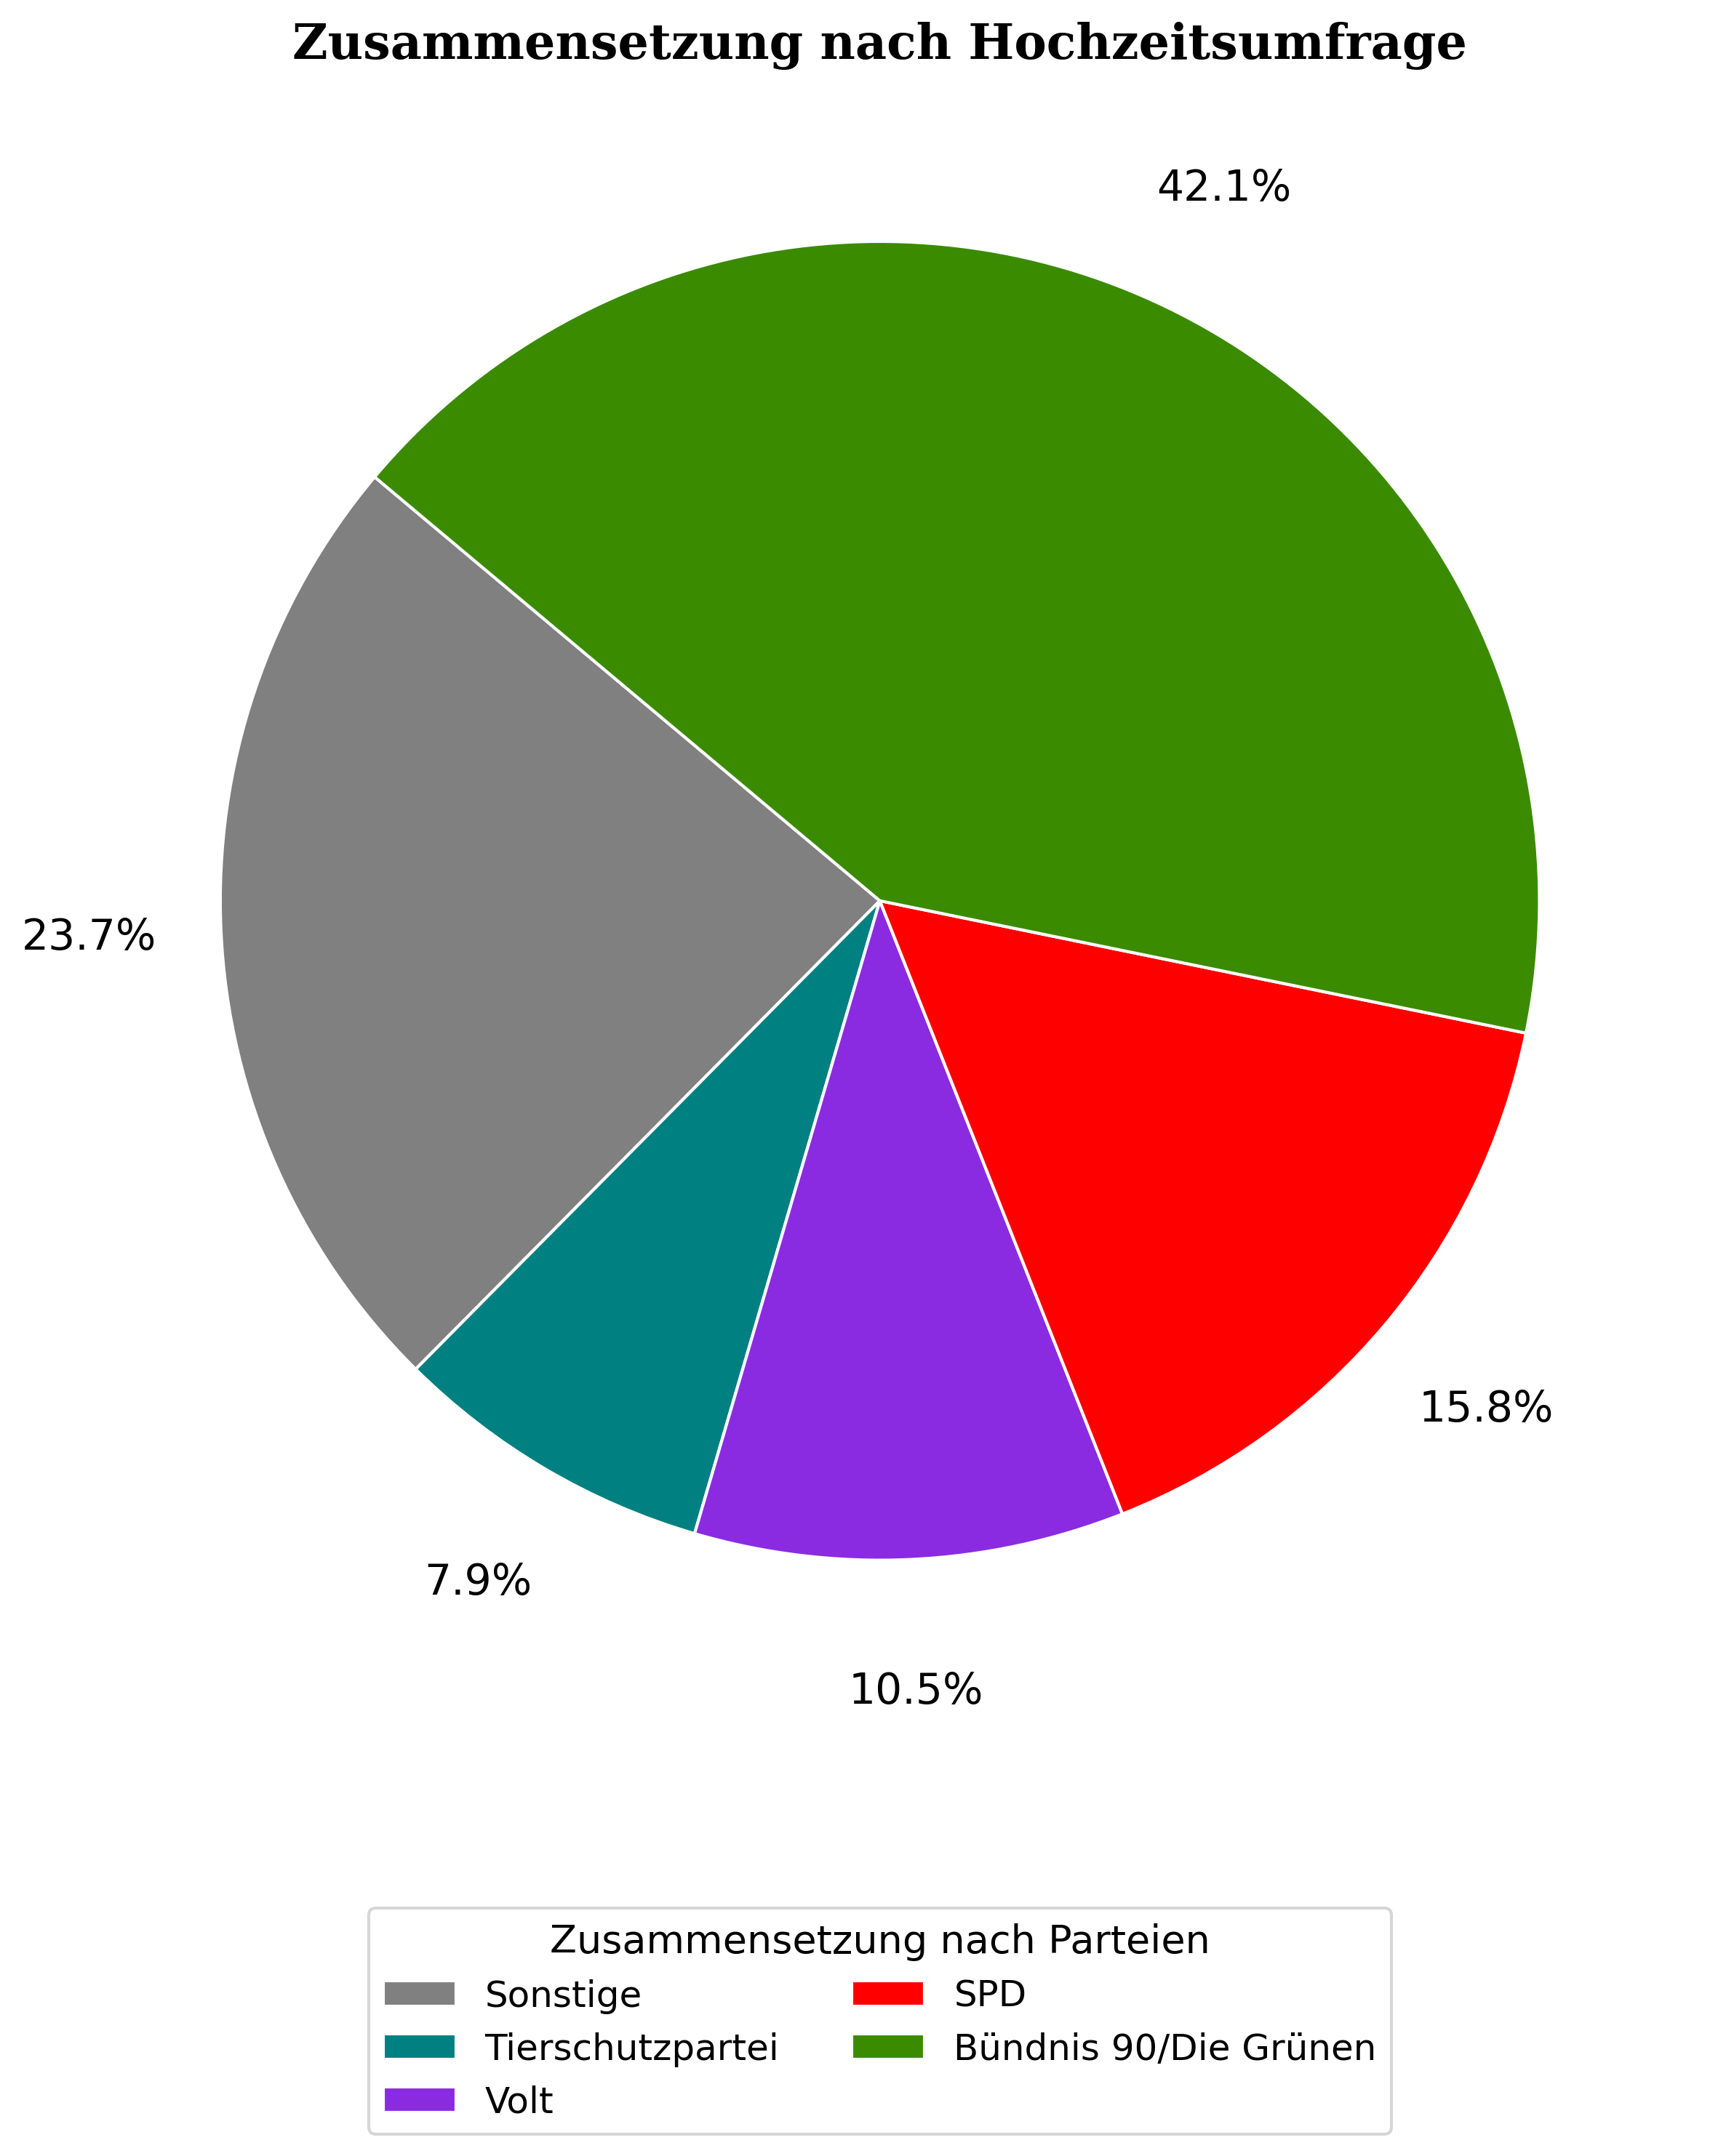

In [361]:
# Farben für die spezifischen Parteien
colors = {
    'Tierschutzpartei': '#008080',  # Petrolgrün
    'Volt': '#8A2BE2',  # Violett
    'SPD': '#FF0000',  # Rot
    'Bündnis 90/Die Grünen': '#3A8B00',  # Grün (HKS 60)
    'Sonstige': 'grey'
}

# Zuerst benennen wir die Elemente im Datensatz um
partei_counts_filtered.rename(index={
    'Tierschutzpartei (Partei Mensch Umwelt Tierschutz)': 'Tierschutzpartei',
    'Volt (Volt Deutschland)': 'Volt',
    'SPD (Sozialdemokratische Partei Deutschlands)': 'SPD',
    'Bündnis 90/Die Grünen': 'Bündnis 90/Die Grünen',
    'Sonstige': 'Sonstige'
}, inplace=True)

# Filtere nur die Parteien, die in colors definiert sind
partei_counts_filtered = partei_counts_filtered[partei_counts_filtered.index.isin(colors.keys())]

# Erstelle ein Tortendiagramm
plt.figure(figsize=(10, 10), dpi=300)
wedges, _, autotexts = plt.pie(partei_counts_filtered, labels=None,
                               colors=[colors[party] for party in partei_counts_filtered.index],
                               autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'white'},
                               textprops={'fontsize': 14}, pctdistance=1.2)  # Prozentzahlen außerhalb des Tortendiagramms

# Ändere die Schriftfarbe der Prozentzahlen in Schwarz
for autotext in autotexts:
    autotext.set_color('black')

# Füge eine Legende unterhalb hinzu und ändere den Titel zu "Zusammensetzung nach Parteien"
plt.legend(wedges, partei_counts_filtered.index, title="Zusammensetzung nach Parteien", loc="upper center",
           bbox_to_anchor=(0.5, -0.1), fontsize=12, title_fontsize='13', facecolor='white', ncol=2)

# Setze den Titel des Plots
plt.title('Zusammensetzung nach Hochzeitsumfrage', fontsize=16, fontweight='bold', family='serif', color='black')

# Verwende tight_layout, um das Layout zu optimieren und sicherzustellen, dass der Titel sichtbar ist
plt.tight_layout()

plt.show()


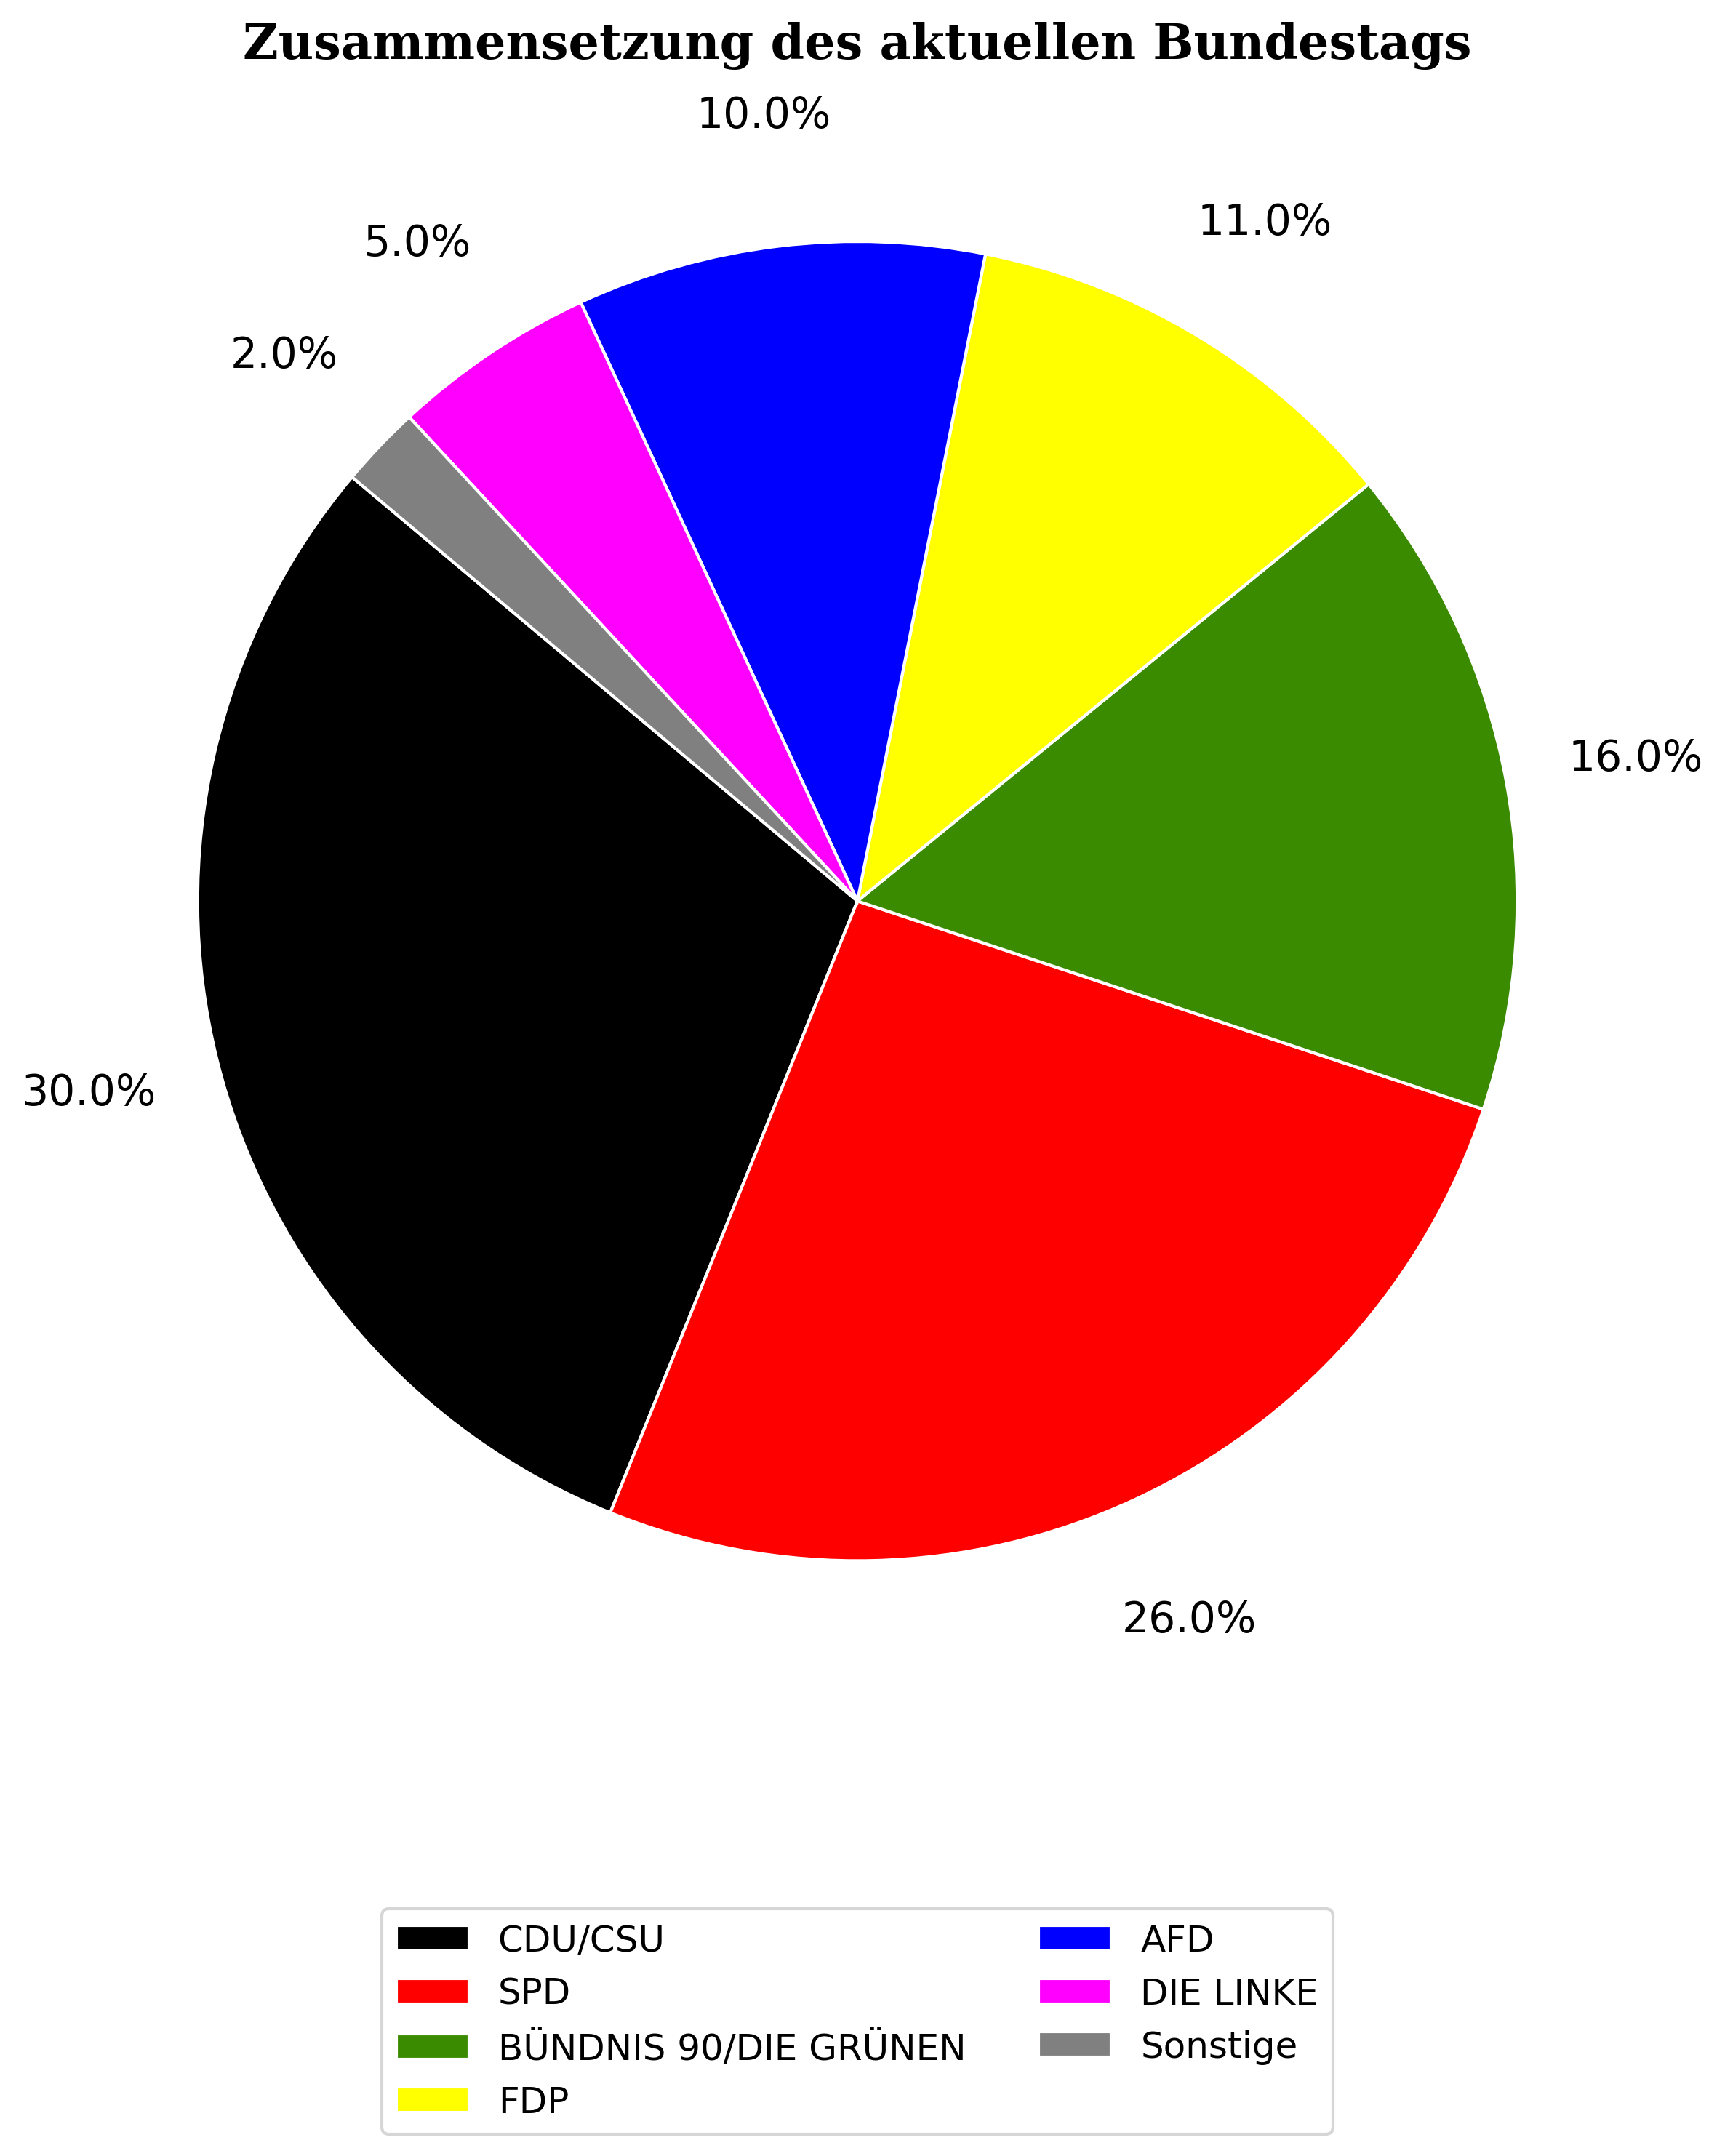

In [362]:
# Neuer Datensatz
data = {
    'CDU/CSU': 30,
    'SPD': 26,
    'BÜNDNIS 90/DIE GRÜNEN': 16,
    'FDP': 11,
    'AFD': 10,
    'DIE LINKE': 5,
    'Sonstige': 2
}

# Erstelle einen DataFrame aus dem neuen Datensatz
partei_counts_new = pd.Series(data)

# Farben für die spezifischen Parteien im neuen Datensatz
colors_new = {
    'CDU/CSU': 'black',  # Schwarz
    'SPD': '#FF0000',  # Rot
    'BÜNDNIS 90/DIE GRÜNEN': '#3A8B00',  # Grün (HKS 60)
    'FDP': 'yellow',  # Gelb
    'AFD': 'blue',  # Blau
    'DIE LINKE': 'magenta',  # Magenta
    'Sonstige': 'grey'  # Grau
}

# Erstelle ein Tortendiagramm für den neuen Datensatz
plt.figure(figsize=(10, 10), dpi=300)
wedges, _, autotexts = plt.pie(partei_counts_new, labels=None,
                               colors=[colors_new[party] for party in partei_counts_new.index],
                               autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'white'},
                               textprops={'fontsize': 14}, pctdistance=1.2)  # Prozentzahlen außerhalb des Tortendiagramms

# Ändere die Schriftfarbe der Prozentzahlen in Schwarz
for autotext in autotexts:
    autotext.set_color('black')

# Füge eine Legende unterhalb hinzu und ändere den Titel zu "Zusammensetzung nach Parteien"
plt.legend(wedges, partei_counts_new.index, title="", loc="upper center",
           bbox_to_anchor=(0.5, -0.1), fontsize=12, title_fontsize='13', facecolor='white', ncol=2)

# Setze den Titel des Plots
plt.title('Zusammensetzung des aktuellen Bundestags', fontsize=16, fontweight='bold', family='serif', color='black')

# Verwende tight_layout, um das Layout zu optimieren und sicherzustellen, dass der Titel sichtbar ist
plt.tight_layout()

plt.show()


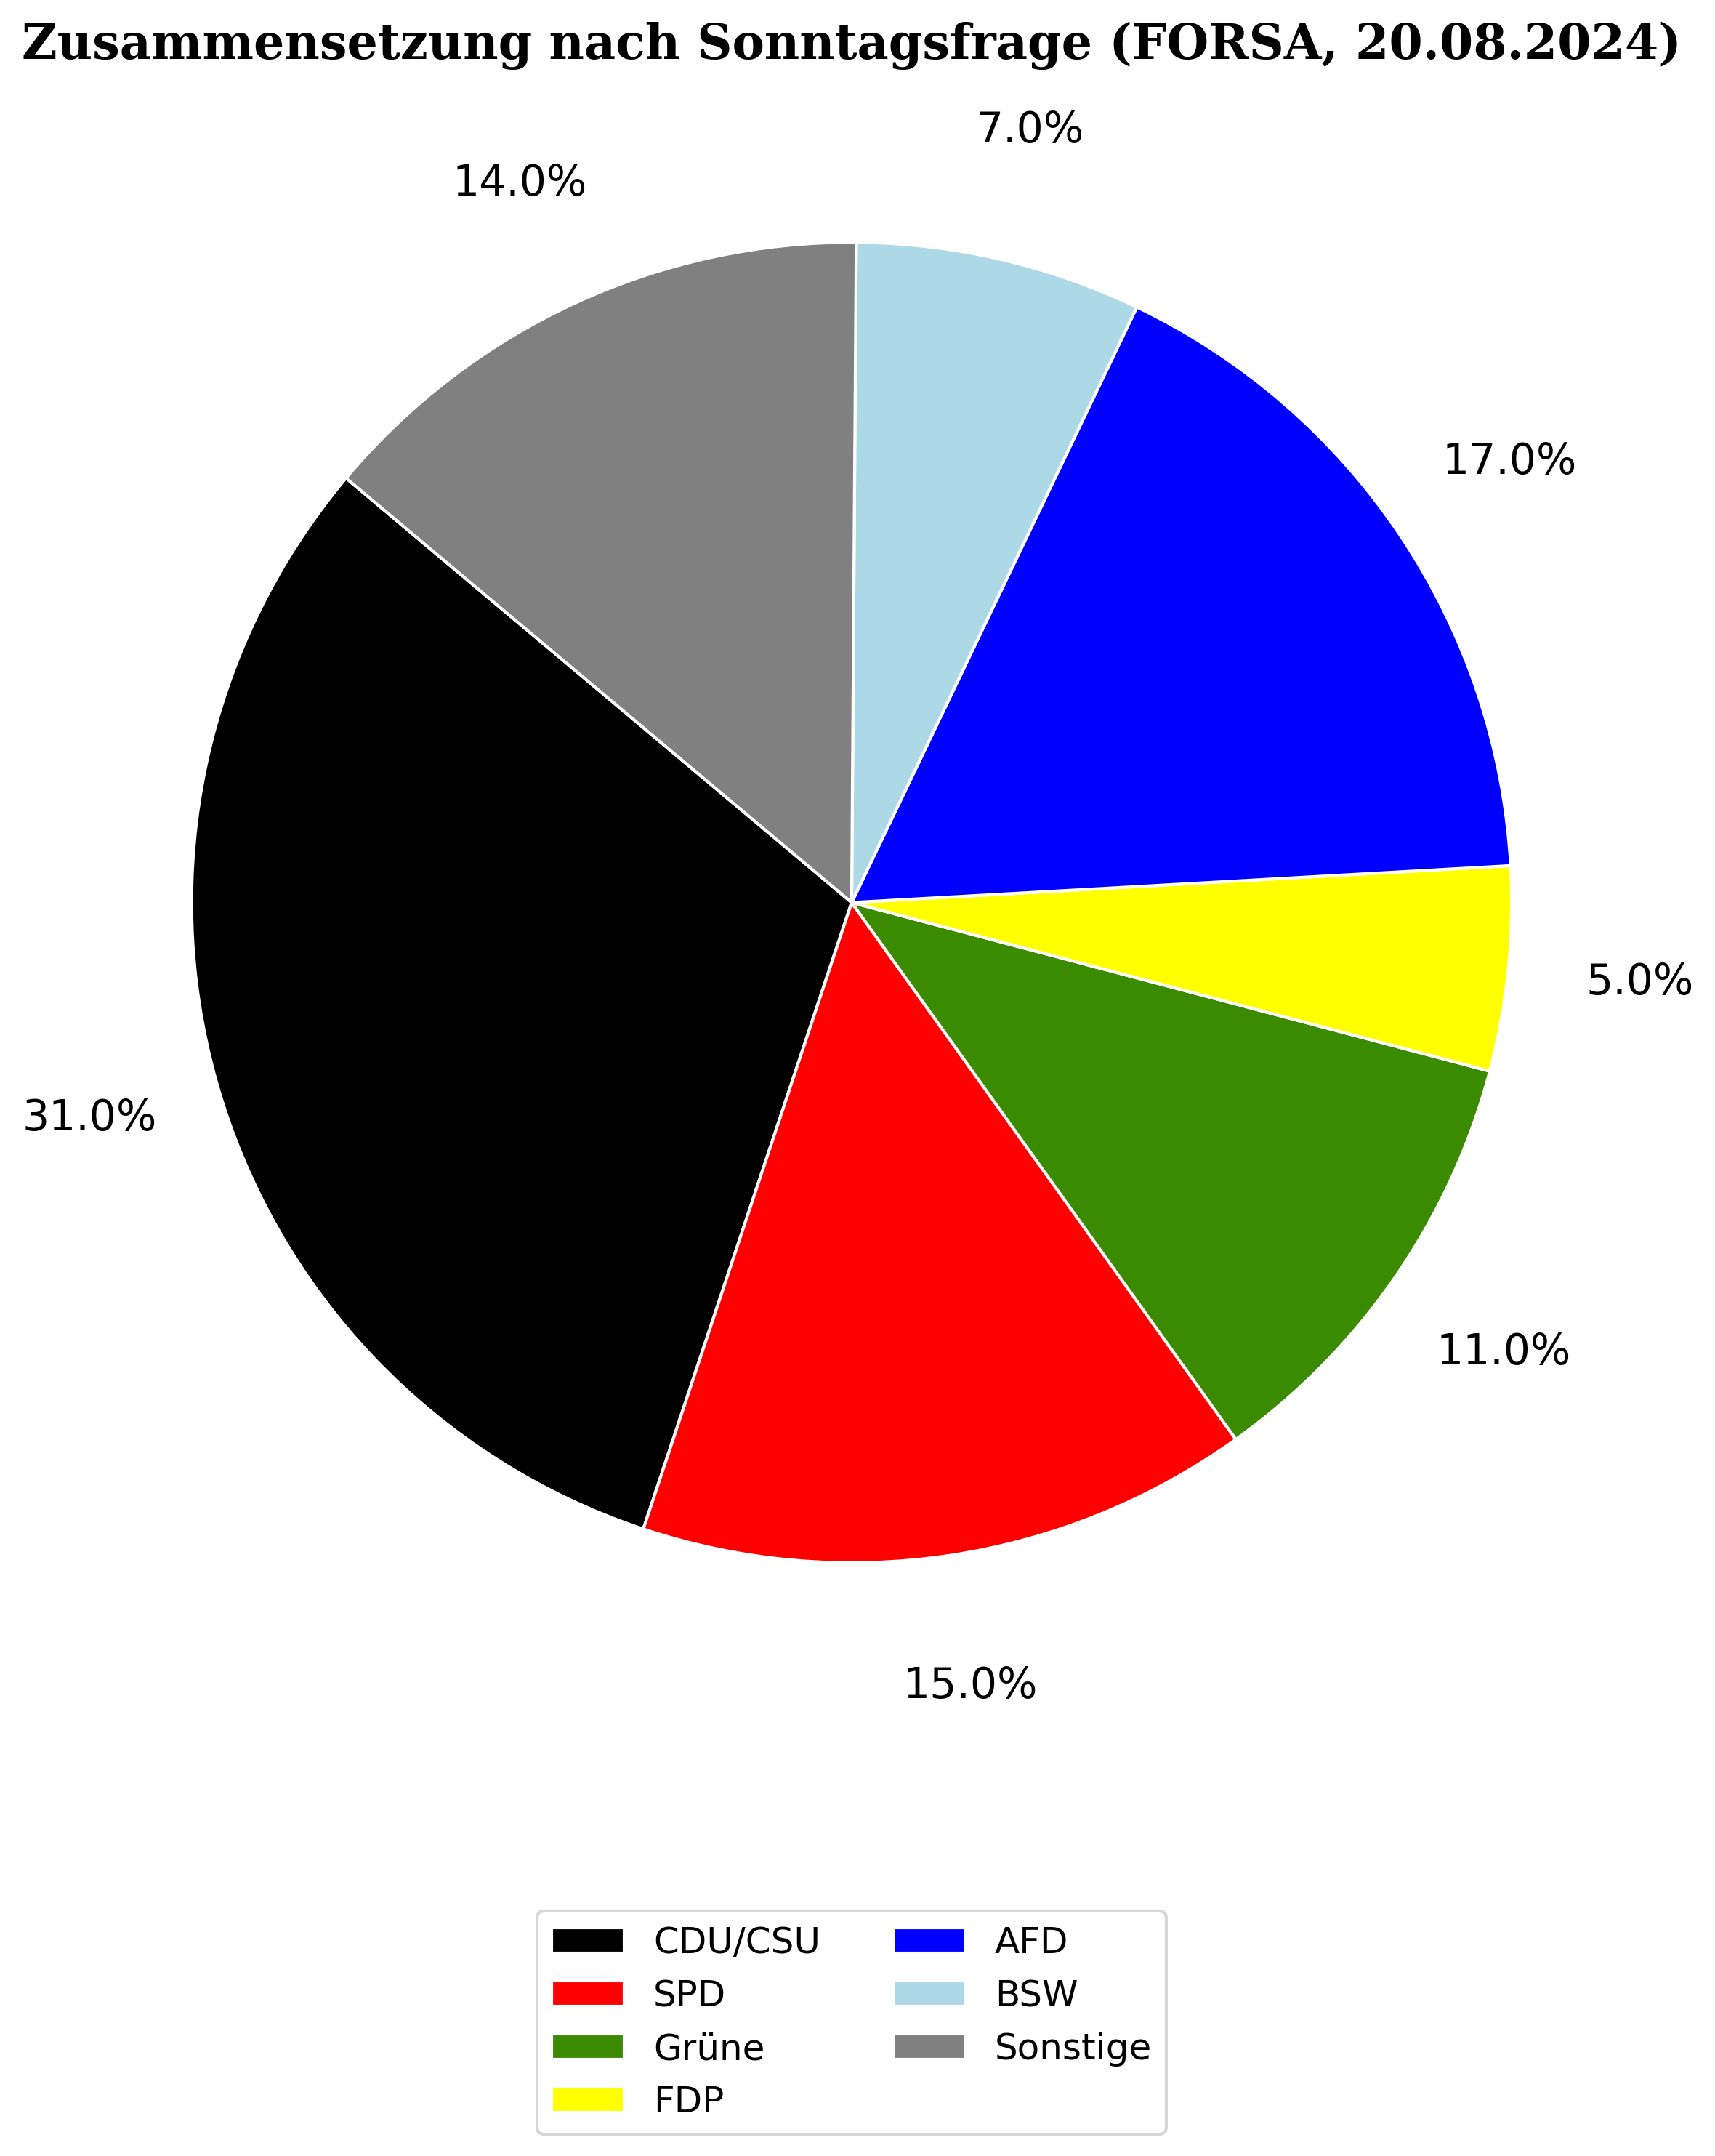

In [432]:
import matplotlib.pyplot as plt
import pandas as pd

# Neuer Datensatz
data = {
    'CDU/CSU': 31,
    'SPD': 15,
    'Grüne': 11,
    'FDP': 5,
    'AFD': 17,
    'BSW': 7,
    'Sonstige': 14
}

# Erstelle einen DataFrame aus dem neuen Datensatz
partei_counts_new = pd.Series(data)

# Farben für die spezifischen Parteien im neuen Datensatz
colors_new = {
    'CDU/CSU': 'black',  # Schwarz
    'SPD': '#FF0000',  # Rot
    'Grüne': '#3A8B00',  # Grün (HKS 60)
    'FDP': 'yellow',  # Gelb
    'AFD': 'blue',  # Blau
    'BSW': '#ADD8E6',  # Hellblau für BSW
    'Sonstige': 'grey'  # Grau
}

# Erstelle ein Tortendiagramm für den neuen Datensatz
plt.figure(figsize=(10, 10), dpi=300)
wedges, _, autotexts = plt.pie(partei_counts_new, labels=None,
                               colors=[colors_new[party] for party in partei_counts_new.index],
                               autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'white'},
                               textprops={'fontsize': 14}, pctdistance=1.2)  # Prozentzahlen außerhalb des Tortendiagramms

# Ändere die Schriftfarbe der Prozentzahlen in Schwarz
for autotext in autotexts:
    autotext.set_color('black')

# Füge eine Legende unterhalb hinzu
plt.legend(wedges, partei_counts_new.index, title="", loc="upper center",
           bbox_to_anchor=(0.5, -0.1), fontsize=12, title_fontsize='13', facecolor='white', ncol=2)

# Setze den Titel des Plots
plt.title('Zusammensetzung nach Sonntagsfrage (FORSA, 20.08.2024)', fontsize=16, fontweight='bold', family='serif', color='black')

# Verwende tight_layout, um das Layout zu optimieren und sicherzustellen, dass der Titel sichtbar ist
plt.tight_layout()

plt.show()


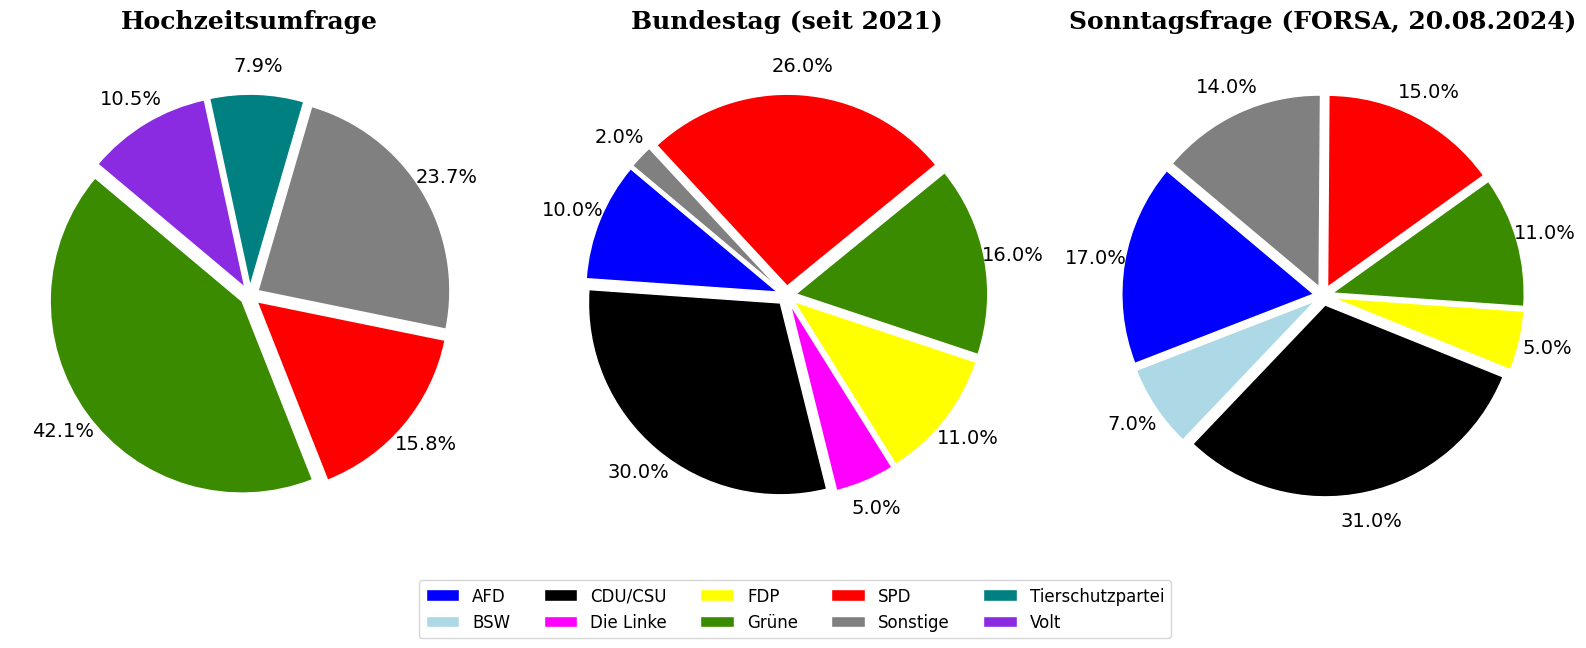

In [452]:
import pandas as pd
import matplotlib.pyplot as plt

# Zuerst vereinheitlichen wir die Parteibezeichnungen und definieren die Daten
data_hochzeitsumfrage = {
    'Tierschutzpartei': 7.9,
    'Volt': 10.5,
    'SPD': 15.8,
    'Grüne': 42.1,  # Vereinheitlicht auf "Grüne"
    'Sonstige': 23.7
}

data_bundestag = {
    'CDU/CSU': 30,
    'SPD': 26,
    'Grüne': 16,  # Vereinheitlicht auf "Grüne"
    'FDP': 11,
    'AFD': 10,
    'Die Linke': 5,
    'Sonstige': 2
}

data_forsa = {
    'CDU/CSU': 31,
    'SPD': 15,
    'Grüne': 11,  # Vereinheitlicht auf "Grüne"
    'FDP': 5,
    'AFD': 17,
    'BSW': 7,
    'Sonstige': 14
}

# Erstelle einen DataFrame für jeden Datensatz
df_hochzeitsumfrage = pd.Series(data_hochzeitsumfrage, name='Hochzeitsumfrage')
df_bundestag = pd.Series(data_bundestag, name='Bundestag')
df_forsa = pd.Series(data_forsa, name='FORSA')

# Erstelle einen kombinierten DataFrame
df_combined = pd.DataFrame({
    'Hochzeitsumfrage': df_hochzeitsumfrage,
    'Bundestag': df_bundestag,
    'FORSA': df_forsa
}).fillna(0)

# Farben für die spezifischen Parteien im neuen Datensatz
colors_combined = {
    'CDU/CSU': 'black',  # Schwarz
    'SPD': '#FF0000',  # Rot
    'Grüne': '#3A8B00',  # Grün (HKS 60)
    'FDP': 'yellow',  # Gelb
    'AFD': 'blue',  # Blau
    'Die Linke': 'magenta',  # Magenta
    'BSW': '#ADD8E6',  # Hellblau für BSW
    'Tierschutzpartei': '#008080',  # Petrolgrün
    'Volt': '#8A2BE2',  # Violett
    'Sonstige': 'grey'  # Grau
}

# Funktion zur Anzeige von Prozenten ohne 0.0%
def func(pct, allvalues):
    absolute = int(round(pct / 100. * sum(allvalues)))
    return f'{pct:.1f}%' if pct > 0 else ''

# Erstelle den Multiplot
fig, axes = plt.subplots(1, 3, figsize=(16, 7))

# Definiere den Explosionsfaktor für jede Partei (hier wird jede Partei leicht hervorgehoben)
explode = [0.05] * len(df_combined.index)

# Plot 1: Hochzeitsumfrage
wedges, _, autotexts = axes[0].pie(df_combined['Hochzeitsumfrage'], labels=None,
                                   colors=[colors_combined[party] for party in df_combined.index],
                                   autopct=lambda pct: func(pct, df_combined['Hochzeitsumfrage']),
                                   startangle=140, wedgeprops={'edgecolor': 'white'},
                                   textprops={'fontsize': 14}, pctdistance=1.15, explode=explode)
for autotext in autotexts:
    autotext.set_color('black')
axes[0].set_title('Hochzeitsumfrage', fontsize=18, fontweight='bold', family='serif', color='black', pad=20)

# Plot 2: Bundestag
wedges, _, autotexts = axes[1].pie(df_combined['Bundestag'], labels=None,
                                   colors=[colors_combined[party] for party in df_combined.index],
                                   autopct=lambda pct: func(pct, df_combined['Bundestag']),
                                   startangle=140, wedgeprops={'edgecolor': 'white'},
                                   textprops={'fontsize': 14}, pctdistance=1.15, explode=explode)
for autotext in autotexts:
    autotext.set_color('black')
axes[1].set_title('Bundestag (seit 2021)', fontsize=18, fontweight='bold', family='serif', color='black', pad=20)

# Plot 3: FORSA Sonntagsfrage
wedges, _, autotexts = axes[2].pie(df_combined['FORSA'], labels=None,
                                   colors=[colors_combined[party] for party in df_combined.index],
                                   autopct=lambda pct: func(pct, df_combined['FORSA']),
                                   startangle=140, wedgeprops={'edgecolor': 'white'},
                                   textprops={'fontsize': 14}, pctdistance=1.15, explode=explode)
for autotext in autotexts:
    autotext.set_color('black')
axes[2].set_title('Sonntagsfrage (FORSA, 20.08.2024)', fontsize=18, fontweight='bold', family='serif', color='black', pad=20)

# Gemeinsame Legende für alle Subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(wedges, df_combined.index, loc='lower center', bbox_to_anchor=(0.5, -0.001), ncol=5, fontsize=12, title_fontsize='13', facecolor='white')

plt.tight_layout()
plt.show()


# 4. Brautpaar-Fragen (Mehrere Antworten möglich)

## Fragen:

Wen kennst du länger?

Wer ist der größere Sportler?

Wer kommt eher zu spät?

Wer macht mehr Unsinn?

Wer ist lustiger?

Wer wird an der Hochzeit wohl betrunkener sein?

Wer würde eher in einem Horrorfilm überleben?

Wer verbringt mehr Zeit auf der Toilette?

Wer kann besser mit Geld umgehen?

Wer ist vernünftiger?

Wer ist abenteuerlustiger?

Wer wünschst sich mehr einen Hund?

Wer fährt besser Fahrrad nach dem Biergartenbesuch?

Wer hat mehr Narben?

Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers?

Wer verbringt mehr Zeit am Handy?

Wer ist romantischer?

<Figure size 1400x1200 with 0 Axes>

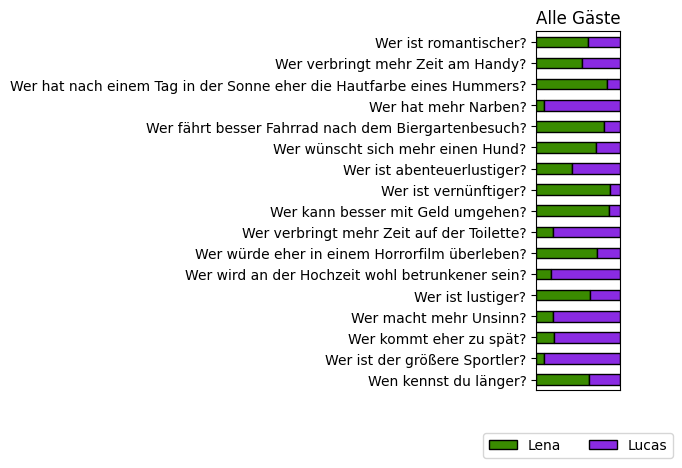

In [387]:
# Definiere die relevanten Fragen und ihre entsprechenden Spaltennamen für Lena und Lucas
questions = {
    "Wen kennst du länger?": ["Wen kennst du länger? (Lena)", "Wen kennst du länger? (Lucas)"],
    "Wer ist der größere Sportler?": ["Wer ist der größere Sportler? (Lena)", "Wer ist der größere Sportler? (Lucas)"],
    "Wer kommt eher zu spät?": ["Wer kommt eher zu spät? (Lena)", "Wer kommt eher zu spät? (Lucas)"],
    "Wer macht mehr Unsinn?": ["Wer macht mehr Unsinn? (Lena)", "Wer macht mehr Unsinn? (Lucas)"],
    "Wer ist lustiger?": ["Wer ist lustiger? (Lena)", "Wer ist lustiger? (Lucas)"],
    "Wer wird an der Hochzeit wohl betrunkener sein?": ["Wer wird an der Hochzeit wohl betrunkener sein? (Lena)", "Wer wird an der Hochzeit wohl betrunkener sein? (Lucas)"],
    "Wer würde eher in einem Horrorfilm überleben?": ["Wer würde eher in einem Horrorfilm überleben? (Lena)", "Wer würde eher in einem Horrorfilm überleben? (Lucas)"],
    "Wer verbringt mehr Zeit auf der Toilette?": ["Wer verbringt mehr Zeit auf der Toilette? (Lena)", "Wer verbringt mehr Zeit auf der Toilette? (Lucas)"],
    "Wer kann besser mit Geld umgehen?": ["Wer kann besser mit Geld umgehen? (Lena)", "Wer kann besser mit Geld umgehen? (Lucas)"],
    "Wer ist vernünftiger?": ["Wer ist vernünftiger? (Lena)", "Wer ist vernünftiger? (Lucas)"],
    "Wer ist abenteuerlustiger?": ["Wer ist abenteuerlustiger? (Lena)", "Wer ist abenteuerlustiger? (Lucas)"],
    "Wer wünscht sich mehr einen Hund?": ["Wer wünschst sich mehr einen Hund? (Lena)", "Wer wünschst sich mehr einen Hund? (Lucas)"],
    "Wer fährt besser Fahrrad nach dem Biergartenbesuch?": ["Wer fährt besser Fahrrad nach dem Biergartenbesuch? (Lena)", "Wer fährt besser Fahrrad nach dem Biergartenbesuch? (Lucas)"],
    "Wer hat mehr Narben?": ["Wer hat mehr Narben? (Lena)", "Wer hat mehr Narben? (Lucas)"],
    "Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers?": ["Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lena)", "Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lucas)"],
    "Wer verbringt mehr Zeit am Handy?": ["Wer verbringt mehr Zeit am Handy? (Lena)", "Wer verbringt mehr Zeit am Handy? (Lucas)"],
    "Wer ist romantischer?": ["Wer ist romantischer? (Lena)", "Wer ist romantischer? (Lucas)"]
}

# Farben für die Balken
colors = {'Lena': '#3A8B00', 'Lucas': '#8A2BE2'}  # Grün für Lena, Violett für Lucas

# Berechne die Prozente für jede Frage
percentages = {}
for question, columns in questions.items():
    # Konvertiere die Spalten zu numerischen Werten, ignoriere Fehlerhafte
    lena_count = pd.to_numeric(df[columns[0]], errors='coerce').sum()
    lucas_count = pd.to_numeric(df[columns[1]], errors='coerce').sum()
    total_count = lena_count + lucas_count
    percentages[question] = [lena_count / total_count * 100, lucas_count / total_count * 100]

# Konvertiere die Ergebnisse in ein DataFrame
results_df = pd.DataFrame(percentages, index=['Lena', 'Lucas']).T

# Erstelle den gestapelten Balkendiagramm
plt.figure(figsize=(14, 12))  # Vergrößere die Breite des Plots
results_df.plot(kind='barh', stacked=True, color=[colors['Lena'], colors['Lucas']], edgecolor='black')

# Anpassungen an der Darstellung
plt.title('Alle Gäste')
plt.xlabel('')  # Entferne X-Achsentitel
plt.ylabel('')  # Entferne Y-Achsentitel
plt.xticks([])  # Entferne die X-Achsenbeschriftungen
plt.xlim(0, 100)

# Legende unterhalb des Plots platzieren
plt.legend(['Lena', 'Lucas'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.grid(axis='x', linestyle='--', alpha=0.7)

# Zeige den Plot
plt.tight_layout()
plt.show()

<Figure size 1400x1200 with 0 Axes>

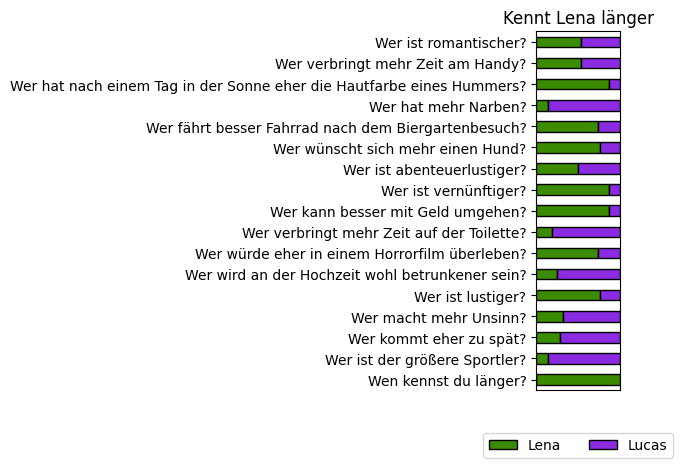

In [386]:
# Filtere den Datensatz nach den Zeilen, bei denen "Wen kennst du länger? (Lena)" eine 1 hat
df_lena = df[(df["Wen kennst du länger? (Lena)"] == 1) & (df["Wen kennst du länger? (Lucas)"] == 0)]

questions = {
    "Wen kennst du länger?": ["Wen kennst du länger? (Lena)", "Wen kennst du länger? (Lucas)"],
    "Wer ist der größere Sportler?": ["Wer ist der größere Sportler? (Lena)", "Wer ist der größere Sportler? (Lucas)"],
    "Wer kommt eher zu spät?": ["Wer kommt eher zu spät? (Lena)", "Wer kommt eher zu spät? (Lucas)"],
    "Wer macht mehr Unsinn?": ["Wer macht mehr Unsinn? (Lena)", "Wer macht mehr Unsinn? (Lucas)"],
    "Wer ist lustiger?": ["Wer ist lustiger? (Lena)", "Wer ist lustiger? (Lucas)"],
    "Wer wird an der Hochzeit wohl betrunkener sein?": ["Wer wird an der Hochzeit wohl betrunkener sein? (Lena)", "Wer wird an der Hochzeit wohl betrunkener sein? (Lucas)"],
    "Wer würde eher in einem Horrorfilm überleben?": ["Wer würde eher in einem Horrorfilm überleben? (Lena)", "Wer würde eher in einem Horrorfilm überleben? (Lucas)"],
    "Wer verbringt mehr Zeit auf der Toilette?": ["Wer verbringt mehr Zeit auf der Toilette? (Lena)", "Wer verbringt mehr Zeit auf der Toilette? (Lucas)"],
    "Wer kann besser mit Geld umgehen?": ["Wer kann besser mit Geld umgehen? (Lena)", "Wer kann besser mit Geld umgehen? (Lucas)"],
    "Wer ist vernünftiger?": ["Wer ist vernünftiger? (Lena)", "Wer ist vernünftiger? (Lucas)"],
    "Wer ist abenteuerlustiger?": ["Wer ist abenteuerlustiger? (Lena)", "Wer ist abenteuerlustiger? (Lucas)"],
    "Wer wünscht sich mehr einen Hund?": ["Wer wünschst sich mehr einen Hund? (Lena)", "Wer wünschst sich mehr einen Hund? (Lucas)"],
    "Wer fährt besser Fahrrad nach dem Biergartenbesuch?": ["Wer fährt besser Fahrrad nach dem Biergartenbesuch? (Lena)", "Wer fährt besser Fahrrad nach dem Biergartenbesuch? (Lucas)"],
    "Wer hat mehr Narben?": ["Wer hat mehr Narben? (Lena)", "Wer hat mehr Narben? (Lucas)"],
    "Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers?": ["Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lena)", "Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lucas)"],
    "Wer verbringt mehr Zeit am Handy?": ["Wer verbringt mehr Zeit am Handy? (Lena)", "Wer verbringt mehr Zeit am Handy? (Lucas)"],
    "Wer ist romantischer?": ["Wer ist romantischer? (Lena)", "Wer ist romantischer? (Lucas)"]
}

# Farben für die Balken
colors = {'Lena': '#3A8B00', 'Lucas': '#8A2BE2'}  # Grün für Lena, Violett für Lucas

# Berechne die Prozente für jede Frage basierend auf df_lena
percentages = {}
for question, columns in questions.items():
    # Konvertiere die Spalten zu numerischen Werten, ignoriere Fehlerhafte
    lena_count = pd.to_numeric(df_lena[columns[0]], errors='coerce').sum()
    lucas_count = pd.to_numeric(df_lena[columns[1]], errors='coerce').sum()
    total_count = lena_count + lucas_count
    percentages[question] = [lena_count / total_count * 100, lucas_count / total_count * 100]

# Konvertiere die Ergebnisse in ein DataFrame
results_df = pd.DataFrame(percentages, index=['Lena', 'Lucas']).T

# Erstelle den gestapelten Balkendiagramm
plt.figure(figsize=(14, 12))  # Vergrößere die Breite des Plots
results_df.plot(kind='barh', stacked=True, color=[colors['Lena'], colors['Lucas']], edgecolor='black')

# Anpassungen an der Darstellung
plt.title('Kennt Lena länger')
plt.xlabel('')  # Entferne X-Achsentitel
plt.ylabel('')  # Entferne Y-Achsentitel
plt.xticks([])  # Entferne die X-Achsenbeschriftungen
plt.xlim(0, 100)

# Legende unterhalb des Plots platzieren
plt.legend(['Lena', 'Lucas'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.grid(axis='x', linestyle='--', alpha=0.7)

# Zeige den Plot
plt.tight_layout()
plt.show()


<Figure size 1400x1200 with 0 Axes>

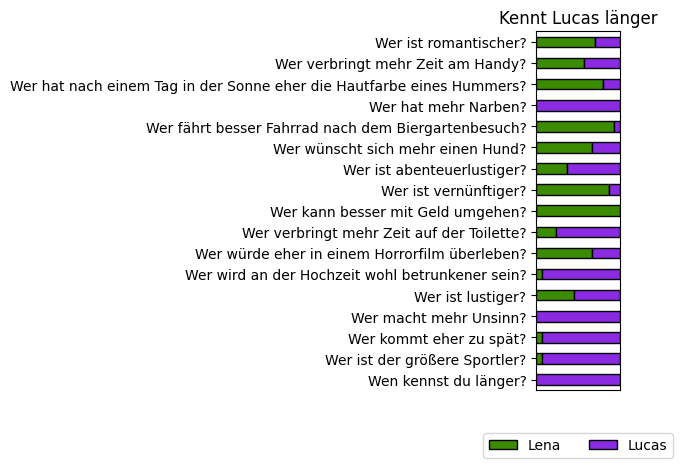

In [385]:
# Filtere den Datensatz nach den Zeilen, bei denen "Wen kennst du länger? (Lena)" eine 1 hat
df_lucas = df[(df["Wen kennst du länger? (Lucas)"] == 1) & (df["Wen kennst du länger? (Lena)"] == 0)]

questions = {
    "Wen kennst du länger?": ["Wen kennst du länger? (Lena)", "Wen kennst du länger? (Lucas)"],
    "Wer ist der größere Sportler?": ["Wer ist der größere Sportler? (Lena)", "Wer ist der größere Sportler? (Lucas)"],
    "Wer kommt eher zu spät?": ["Wer kommt eher zu spät? (Lena)", "Wer kommt eher zu spät? (Lucas)"],
    "Wer macht mehr Unsinn?": ["Wer macht mehr Unsinn? (Lena)", "Wer macht mehr Unsinn? (Lucas)"],
    "Wer ist lustiger?": ["Wer ist lustiger? (Lena)", "Wer ist lustiger? (Lucas)"],
    "Wer wird an der Hochzeit wohl betrunkener sein?": ["Wer wird an der Hochzeit wohl betrunkener sein? (Lena)", "Wer wird an der Hochzeit wohl betrunkener sein? (Lucas)"],
    "Wer würde eher in einem Horrorfilm überleben?": ["Wer würde eher in einem Horrorfilm überleben? (Lena)", "Wer würde eher in einem Horrorfilm überleben? (Lucas)"],
    "Wer verbringt mehr Zeit auf der Toilette?": ["Wer verbringt mehr Zeit auf der Toilette? (Lena)", "Wer verbringt mehr Zeit auf der Toilette? (Lucas)"],
    "Wer kann besser mit Geld umgehen?": ["Wer kann besser mit Geld umgehen? (Lena)", "Wer kann besser mit Geld umgehen? (Lucas)"],
    "Wer ist vernünftiger?": ["Wer ist vernünftiger? (Lena)", "Wer ist vernünftiger? (Lucas)"],
    "Wer ist abenteuerlustiger?": ["Wer ist abenteuerlustiger? (Lena)", "Wer ist abenteuerlustiger? (Lucas)"],
    "Wer wünscht sich mehr einen Hund?": ["Wer wünschst sich mehr einen Hund? (Lena)", "Wer wünschst sich mehr einen Hund? (Lucas)"],
    "Wer fährt besser Fahrrad nach dem Biergartenbesuch?": ["Wer fährt besser Fahrrad nach dem Biergartenbesuch? (Lena)", "Wer fährt besser Fahrrad nach dem Biergartenbesuch? (Lucas)"],
    "Wer hat mehr Narben?": ["Wer hat mehr Narben? (Lena)", "Wer hat mehr Narben? (Lucas)"],
    "Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers?": ["Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lena)", "Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lucas)"],
    "Wer verbringt mehr Zeit am Handy?": ["Wer verbringt mehr Zeit am Handy? (Lena)", "Wer verbringt mehr Zeit am Handy? (Lucas)"],
    "Wer ist romantischer?": ["Wer ist romantischer? (Lena)", "Wer ist romantischer? (Lucas)"]
}

# Farben für die Balken
colors = {'Lena': '#3A8B00', 'Lucas': '#8A2BE2'}  # Grün für Lena, Violett für Lucas

# Berechne die Prozente für jede Frage basierend auf df_lena
percentages = {}
for question, columns in questions.items():
    # Konvertiere die Spalten zu numerischen Werten, ignoriere Fehlerhafte
    lena_count = pd.to_numeric(df_lucas[columns[0]], errors='coerce').sum()
    lucas_count = pd.to_numeric(df_lucas[columns[1]], errors='coerce').sum()
    total_count = lena_count + lucas_count
    percentages[question] = [lena_count / total_count * 100, lucas_count / total_count * 100]

# Konvertiere die Ergebnisse in ein DataFrame
results_df = pd.DataFrame(percentages, index=['Lena', 'Lucas']).T

# Erstelle den gestapelten Balkendiagramm
plt.figure(figsize=(14, 12))  # Vergrößere die Breite des Plots
results_df.plot(kind='barh', stacked=True, color=[colors['Lena'], colors['Lucas']], edgecolor='black')

# Anpassungen an der Darstellung
plt.title('Kennt Lucas länger')
plt.xlabel('')  # Entferne X-Achsentitel
plt.ylabel('')  # Entferne Y-Achsentitel
plt.xticks([])  # Entferne die X-Achsenbeschriftungen
plt.xlim(0, 100)

# Legende unterhalb des Plots platzieren
plt.legend(['Lena', 'Lucas'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.grid(axis='x', linestyle='--', alpha=0.7)

# Zeige den Plot
plt.tight_layout()
plt.show()


<Figure size 1400x1200 with 0 Axes>

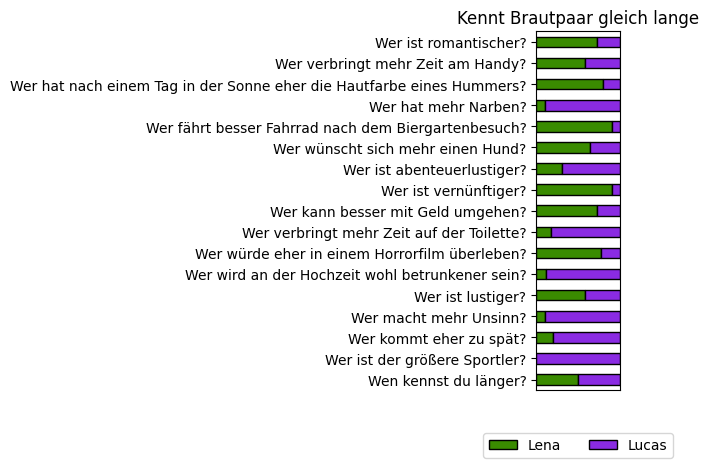

In [384]:
# Filtere den Datensatz nach den Zeilen, bei denen "Wen kennst du länger? (Lena)" eine 1 hat
df_equal = df[(df["Wen kennst du länger? (Lucas)"] == 1) & (df["Wen kennst du länger? (Lena)"] == 1)]

questions = {
    "Wen kennst du länger?": ["Wen kennst du länger? (Lena)", "Wen kennst du länger? (Lucas)"],
    "Wer ist der größere Sportler?": ["Wer ist der größere Sportler? (Lena)", "Wer ist der größere Sportler? (Lucas)"],
    "Wer kommt eher zu spät?": ["Wer kommt eher zu spät? (Lena)", "Wer kommt eher zu spät? (Lucas)"],
    "Wer macht mehr Unsinn?": ["Wer macht mehr Unsinn? (Lena)", "Wer macht mehr Unsinn? (Lucas)"],
    "Wer ist lustiger?": ["Wer ist lustiger? (Lena)", "Wer ist lustiger? (Lucas)"],
    "Wer wird an der Hochzeit wohl betrunkener sein?": ["Wer wird an der Hochzeit wohl betrunkener sein? (Lena)", "Wer wird an der Hochzeit wohl betrunkener sein? (Lucas)"],
    "Wer würde eher in einem Horrorfilm überleben?": ["Wer würde eher in einem Horrorfilm überleben? (Lena)", "Wer würde eher in einem Horrorfilm überleben? (Lucas)"],
    "Wer verbringt mehr Zeit auf der Toilette?": ["Wer verbringt mehr Zeit auf der Toilette? (Lena)", "Wer verbringt mehr Zeit auf der Toilette? (Lucas)"],
    "Wer kann besser mit Geld umgehen?": ["Wer kann besser mit Geld umgehen? (Lena)", "Wer kann besser mit Geld umgehen? (Lucas)"],
    "Wer ist vernünftiger?": ["Wer ist vernünftiger? (Lena)", "Wer ist vernünftiger? (Lucas)"],
    "Wer ist abenteuerlustiger?": ["Wer ist abenteuerlustiger? (Lena)", "Wer ist abenteuerlustiger? (Lucas)"],
    "Wer wünscht sich mehr einen Hund?": ["Wer wünschst sich mehr einen Hund? (Lena)", "Wer wünschst sich mehr einen Hund? (Lucas)"],
    "Wer fährt besser Fahrrad nach dem Biergartenbesuch?": ["Wer fährt besser Fahrrad nach dem Biergartenbesuch? (Lena)", "Wer fährt besser Fahrrad nach dem Biergartenbesuch? (Lucas)"],
    "Wer hat mehr Narben?": ["Wer hat mehr Narben? (Lena)", "Wer hat mehr Narben? (Lucas)"],
    "Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers?": ["Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lena)", "Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lucas)"],
    "Wer verbringt mehr Zeit am Handy?": ["Wer verbringt mehr Zeit am Handy? (Lena)", "Wer verbringt mehr Zeit am Handy? (Lucas)"],
    "Wer ist romantischer?": ["Wer ist romantischer? (Lena)", "Wer ist romantischer? (Lucas)"]
}

# Farben für die Balken
colors = {'Lena': '#3A8B00', 'Lucas': '#8A2BE2'}  # Grün für Lena, Violett für Lucas

# Berechne die Prozente für jede Frage basierend auf df_lena
percentages = {}
for question, columns in questions.items():
    # Konvertiere die Spalten zu numerischen Werten, ignoriere Fehlerhafte
    lena_count = pd.to_numeric(df_equal[columns[0]], errors='coerce').sum()
    lucas_count = pd.to_numeric(df_equal[columns[1]], errors='coerce').sum()
    total_count = lena_count + lucas_count
    percentages[question] = [lena_count / total_count * 100, lucas_count / total_count * 100]

# Konvertiere die Ergebnisse in ein DataFrame
results_df = pd.DataFrame(percentages, index=['Lena', 'Lucas']).T

# Erstelle den gestapelten Balkendiagramm
plt.figure(figsize=(14, 12))  # Vergrößere die Breite des Plots
results_df.plot(kind='barh', stacked=True, color=[colors['Lena'], colors['Lucas']], edgecolor='black')

# Anpassungen an der Darstellung
plt.title('Kennt Brautpaar gleich lange')
plt.xlabel('')  # Entferne X-Achsentitel
plt.ylabel('')  # Entferne Y-Achsentitel
plt.xticks([])  # Entferne die X-Achsenbeschriftungen
plt.xlim(0, 100)

# Legende unterhalb des Plots platzieren
plt.legend(['Lena', 'Lucas'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.grid(axis='x', linestyle='--', alpha=0.7)

# Zeige den Plot
plt.tight_layout()
plt.show()


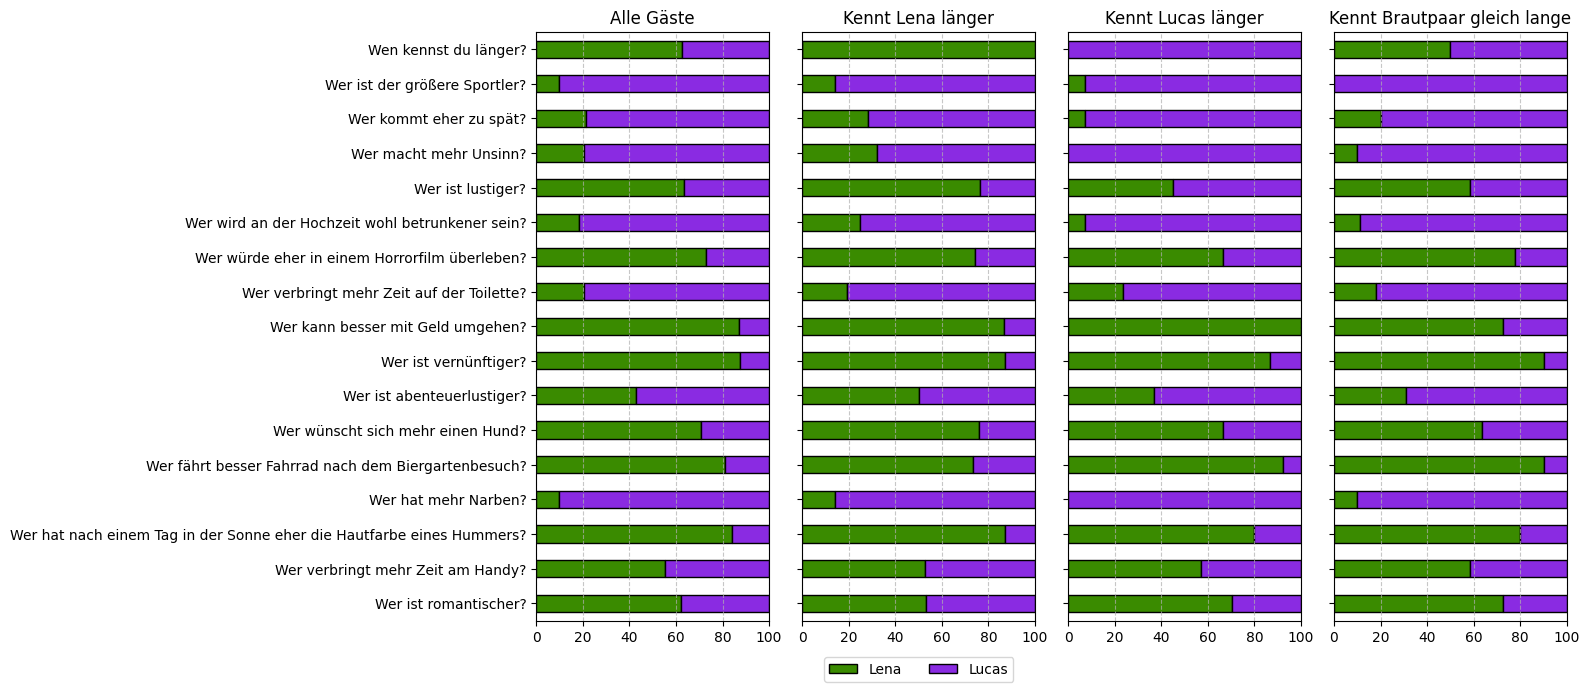

In [421]:
# Definiere die Fragen und ihre Spalten für Lena und Lucas
questions = {
    "Wer ist romantischer?": ["Wer ist romantischer? (Lena)", "Wer ist romantischer? (Lucas)"],
    "Wer verbringt mehr Zeit am Handy?": ["Wer verbringt mehr Zeit am Handy? (Lena)", "Wer verbringt mehr Zeit am Handy? (Lucas)"],
    "Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers?": ["Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lena)", "Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lucas)"],
    "Wer hat mehr Narben?": ["Wer hat mehr Narben? (Lena)", "Wer hat mehr Narben? (Lucas)"],
    "Wer fährt besser Fahrrad nach dem Biergartenbesuch?": ["Wer fährt besser Fahrrad nach dem Biergartenbesuch? (Lena)", "Wer fährt besser Fahrrad nach dem Biergartenbesuch? (Lucas)"],
    "Wer wünscht sich mehr einen Hund?": ["Wer wünschst sich mehr einen Hund? (Lena)", "Wer wünschst sich mehr einen Hund? (Lucas)"],
    "Wer ist abenteuerlustiger?": ["Wer ist abenteuerlustiger? (Lena)", "Wer ist abenteuerlustiger? (Lucas)"],
    "Wer ist vernünftiger?": ["Wer ist vernünftiger? (Lena)", "Wer ist vernünftiger? (Lucas)"],
    "Wer kann besser mit Geld umgehen?": ["Wer kann besser mit Geld umgehen? (Lena)", "Wer kann besser mit Geld umgehen? (Lucas)"],
    "Wer verbringt mehr Zeit auf der Toilette?": ["Wer verbringt mehr Zeit auf der Toilette? (Lena)", "Wer verbringt mehr Zeit auf der Toilette? (Lucas)"],
    "Wer würde eher in einem Horrorfilm überleben?": ["Wer würde eher in einem Horrorfilm überleben? (Lena)", "Wer würde eher in einem Horrorfilm überleben? (Lucas)"],
    "Wer wird an der Hochzeit wohl betrunkener sein?": ["Wer wird an der Hochzeit wohl betrunkener sein? (Lena)", "Wer wird an der Hochzeit wohl betrunkener sein? (Lucas)"],
    "Wer ist lustiger?": ["Wer ist lustiger? (Lena)", "Wer ist lustiger? (Lucas)"],
    "Wer macht mehr Unsinn?": ["Wer macht mehr Unsinn? (Lena)", "Wer macht mehr Unsinn? (Lucas)"],
    "Wer kommt eher zu spät?": ["Wer kommt eher zu spät? (Lena)", "Wer kommt eher zu spät? (Lucas)"],
    "Wer ist der größere Sportler?": ["Wer ist der größere Sportler? (Lena)", "Wer ist der größere Sportler? (Lucas)"],
    "Wen kennst du länger?": ["Wen kennst du länger? (Lena)", "Wen kennst du länger? (Lucas)"]
}

# Farben für die Balken
colors = {'Lena': '#3A8B00', 'Lucas': '#8A2BE2'}  # Grün für Lena, Violett für Lucas

# Erstelle den Plot
fig, axes = plt.subplots(1, 4, figsize=(16, 7), sharey=True)

# Plot 1: Alle Gäste
df_all = df
percentages = {}
for question, columns in questions.items():
    lena_count = pd.to_numeric(df_all[columns[0]], errors='coerce').sum()
    lucas_count = pd.to_numeric(df_all[columns[1]], errors='coerce').sum()
    total_count = lena_count + lucas_count
    percentages[question] = [lena_count / total_count * 100, lucas_count / total_count * 100]
results_df = pd.DataFrame(percentages, index=['Lena', 'Lucas']).T
results_df.plot(kind='barh', stacked=True, color=[colors['Lena'], colors['Lucas']], edgecolor='black', ax=axes[0])
axes[0].set_title('Alle Gäste')
axes[0].set_yticklabels(results_df.index)  # Setze die Y-Achsenbeschriftungen
axes[0].get_legend().remove()  # Entferne die Legende

# Plot 2: Kennt Lena länger
df_lena = df[(df["Wen kennst du länger? (Lena)"] == 1) & (df["Wen kennst du länger? (Lucas)"] == 0)]
percentages = {}
for question, columns in questions.items():
    lena_count = pd.to_numeric(df_lena[columns[0]], errors='coerce').sum()
    lucas_count = pd.to_numeric(df_lena[columns[1]], errors='coerce').sum()
    total_count = lena_count + lucas_count
    percentages[question] = [lena_count / total_count * 100, lucas_count / total_count * 100]
results_df = pd.DataFrame(percentages, index=['Lena', 'Lucas']).T
results_df.plot(kind='barh', stacked=True, color=[colors['Lena'], colors['Lucas']], edgecolor='black', ax=axes[1])
axes[1].set_title('Kennt Lena länger')
axes[1].set_ylabel('')  # Entferne Y-Achsentitel
axes[1].set_yticklabels([])  # Entferne Y-Achsenbeschriftungen

# Plot 3: Kennt Lucas länger
df_lucas = df[(df["Wen kennst du länger? (Lucas)"] == 1) & (df["Wen kennst du länger? (Lena)"] == 0)]
percentages = {}
for question, columns in questions.items():
    lena_count = pd.to_numeric(df_lucas[columns[0]], errors='coerce').sum()
    lucas_count = pd.to_numeric(df_lucas[columns[1]], errors='coerce').sum()
    total_count = lena_count + lucas_count
    percentages[question] = [lena_count / total_count * 100, lucas_count / total_count * 100]
results_df = pd.DataFrame(percentages, index=['Lena', 'Lucas']).T
results_df.plot(kind='barh', stacked=True, color=[colors['Lena'], colors['Lucas']], edgecolor='black', ax=axes[2])
axes[2].set_title('Kennt Lucas länger')
axes[2].set_ylabel('')  # Entferne Y-Achsentitel
axes[2].set_yticklabels([])  # Entferne Y-Achsenbeschriftungen
axes[2].get_legend().remove()  # Entferne die Legende

# Plot 4: Kennt Brautpaar gleich lange
df_equal = df[(df["Wen kennst du länger? (Lucas)"] == 1) & (df["Wen kennst du länger? (Lena)"] == 1)]
percentages = {}
for question, columns in questions.items():
    lena_count = pd.to_numeric(df_equal[columns[0]], errors='coerce').sum()
    lucas_count = pd.to_numeric(df_equal[columns[1]], errors='coerce').sum()
    total_count = lena_count + lucas_count
    percentages[question] = [lena_count / total_count * 100, lucas_count / total_count * 100]
results_df = pd.DataFrame(percentages, index=['Lena', 'Lucas']).T
results_df.plot(kind='barh', stacked=True, color=[colors['Lena'], colors['Lucas']], edgecolor='black', ax=axes[3])
axes[3].set_title('Kennt Brautpaar gleich lange')
axes[3].set_ylabel('')  # Entferne Y-Achsentitel
axes[3].set_yticklabels([])  # Entferne Y-Achsenbeschriftungen
axes[3].get_legend().remove()  # Entferne die Legende

# Gemeinsame Anpassungen
for ax in axes:
    ax.set_xlabel('')
    ax.set_xlim(0, 100)
    ax.grid(axis='x', linestyle='--', alpha=0.7)

# Nur die Y-Achsenbeschriftungen im ersten Plot beibehalten
axes[0].set_yticklabels(questions.keys(), rotation=0, ha='right')

# Legende für den zweiten Plot unterhalb platzieren
axes[1].legend(['Lena', 'Lucas'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.tight_layout()
plt.show()

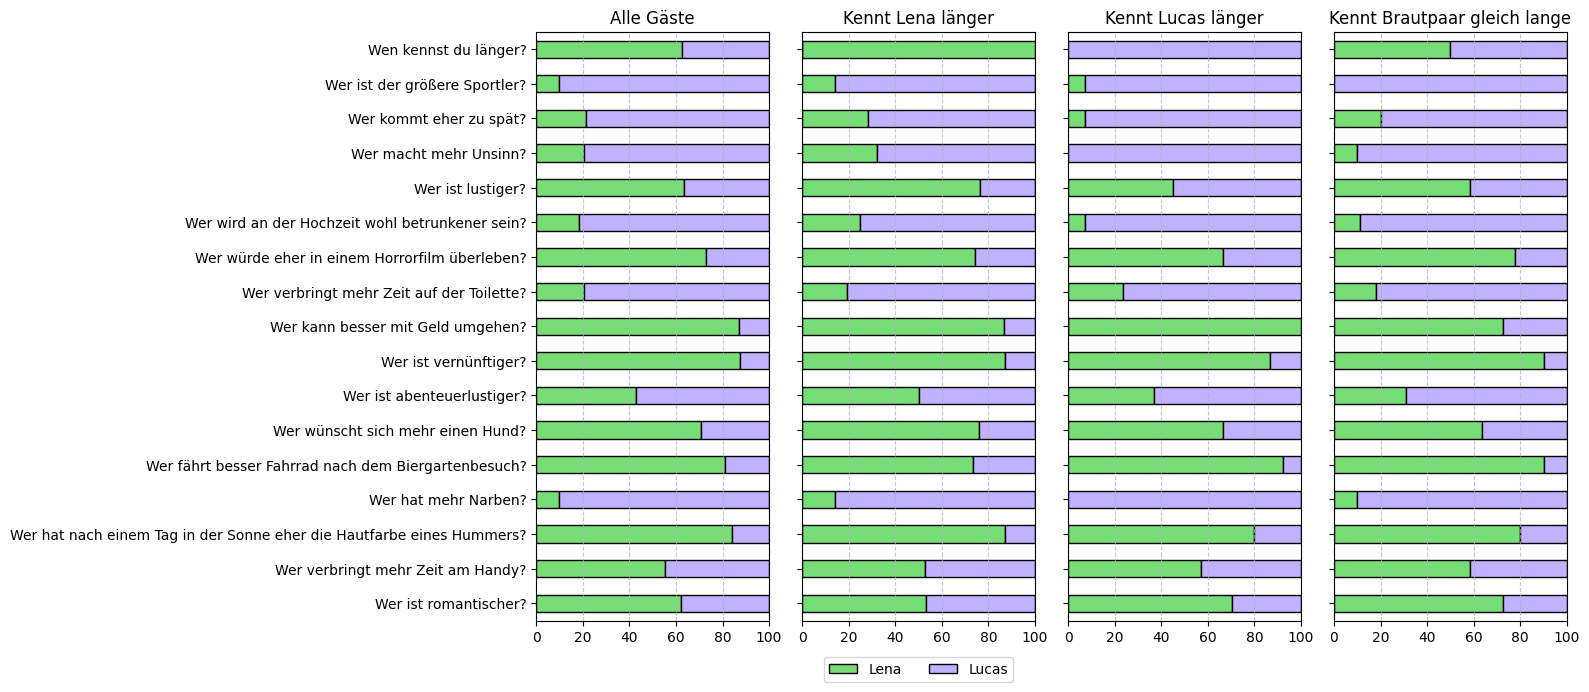

In [453]:
# Definiere die Fragen und ihre Spalten für Lena und Lucas
questions = {
    "Wer ist romantischer?": ["Wer ist romantischer? (Lena)", "Wer ist romantischer? (Lucas)"],
    "Wer verbringt mehr Zeit am Handy?": ["Wer verbringt mehr Zeit am Handy? (Lena)", "Wer verbringt mehr Zeit am Handy? (Lucas)"],
    "Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers?": ["Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lena)", "Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lucas)"],
    "Wer hat mehr Narben?": ["Wer hat mehr Narben? (Lena)", "Wer hat mehr Narben? (Lucas)"],
    "Wer fährt besser Fahrrad nach dem Biergartenbesuch?": ["Wer fährt besser Fahrrad nach dem Biergartenbesuch? (Lena)", "Wer fährt besser Fahrrad nach dem Biergartenbesuch? (Lucas)"],
    "Wer wünscht sich mehr einen Hund?": ["Wer wünschst sich mehr einen Hund? (Lena)", "Wer wünschst sich mehr einen Hund? (Lucas)"],
    "Wer ist abenteuerlustiger?": ["Wer ist abenteuerlustiger? (Lena)", "Wer ist abenteuerlustiger? (Lucas)"],
    "Wer ist vernünftiger?": ["Wer ist vernünftiger? (Lena)", "Wer ist vernünftiger? (Lucas)"],
    "Wer kann besser mit Geld umgehen?": ["Wer kann besser mit Geld umgehen? (Lena)", "Wer kann besser mit Geld umgehen? (Lucas)"],
    "Wer verbringt mehr Zeit auf der Toilette?": ["Wer verbringt mehr Zeit auf der Toilette? (Lena)", "Wer verbringt mehr Zeit auf der Toilette? (Lucas)"],
    "Wer würde eher in einem Horrorfilm überleben?": ["Wer würde eher in einem Horrorfilm überleben? (Lena)", "Wer würde eher in einem Horrorfilm überleben? (Lucas)"],
    "Wer wird an der Hochzeit wohl betrunkener sein?": ["Wer wird an der Hochzeit wohl betrunkener sein? (Lena)", "Wer wird an der Hochzeit wohl betrunkener sein? (Lucas)"],
    "Wer ist lustiger?": ["Wer ist lustiger? (Lena)", "Wer ist lustiger? (Lucas)"],
    "Wer macht mehr Unsinn?": ["Wer macht mehr Unsinn? (Lena)", "Wer macht mehr Unsinn? (Lucas)"],
    "Wer kommt eher zu spät?": ["Wer kommt eher zu spät? (Lena)", "Wer kommt eher zu spät? (Lucas)"],
    "Wer ist der größere Sportler?": ["Wer ist der größere Sportler? (Lena)", "Wer ist der größere Sportler? (Lucas)"],
    "Wen kennst du länger?": ["Wen kennst du länger? (Lena)", "Wen kennst du länger? (Lucas)"]
}

# Farben für die Balken
colors = {'Lena': '#77dd77', 'Lucas': '#c1b2ff'}  # Pastellgrün für Lena, Pastellviolett für Lucas

# Erstelle den Plot
fig, axes = plt.subplots(1, 4, figsize=(16, 7), sharey=True)

# Plot 1: Alle Gäste
df_all = df
percentages = {}
for question, columns in questions.items():
    lena_count = pd.to_numeric(df_all[columns[0]], errors='coerce').sum()
    lucas_count = pd.to_numeric(df_all[columns[1]], errors='coerce').sum()
    total_count = lena_count + lucas_count
    percentages[question] = [lena_count / total_count * 100, lucas_count / total_count * 100]
results_df = pd.DataFrame(percentages, index=['Lena', 'Lucas']).T
results_df.plot(kind='barh', stacked=True, color=[colors['Lena'], colors['Lucas']], edgecolor='black', ax=axes[0])
axes[0].set_title('Alle Gäste')
axes[0].set_yticklabels(results_df.index)  # Setze die Y-Achsenbeschriftungen
axes[0].get_legend().remove()  # Entferne die Legende

# Plot 2: Kennt Lena länger
df_lena = df[(df["Wen kennst du länger? (Lena)"] == 1) & (df["Wen kennst du länger? (Lucas)"] == 0)]
percentages = {}
for question, columns in questions.items():
    lena_count = pd.to_numeric(df_lena[columns[0]], errors='coerce').sum()
    lucas_count = pd.to_numeric(df_lena[columns[1]], errors='coerce').sum()
    total_count = lena_count + lucas_count
    percentages[question] = [lena_count / total_count * 100, lucas_count / total_count * 100]
results_df = pd.DataFrame(percentages, index=['Lena', 'Lucas']).T
results_df.plot(kind='barh', stacked=True, color=[colors['Lena'], colors['Lucas']], edgecolor='black', ax=axes[1])
axes[1].set_title('Kennt Lena länger')
axes[1].set_ylabel('')  # Entferne Y-Achsentitel
axes[1].set_yticklabels([])  # Entferne Y-Achsenbeschriftungen

# Plot 3: Kennt Lucas länger
df_lucas = df[(df["Wen kennst du länger? (Lucas)"] == 1) & (df["Wen kennst du länger? (Lena)"] == 0)]
percentages = {}
for question, columns in questions.items():
    lena_count = pd.to_numeric(df_lucas[columns[0]], errors='coerce').sum()
    lucas_count = pd.to_numeric(df_lucas[columns[1]], errors='coerce').sum()
    total_count = lena_count + lucas_count
    percentages[question] = [lena_count / total_count * 100, lucas_count / total_count * 100]
results_df = pd.DataFrame(percentages, index=['Lena', 'Lucas']).T
results_df.plot(kind='barh', stacked=True, color=[colors['Lena'], colors['Lucas']], edgecolor='black', ax=axes[2])
axes[2].set_title('Kennt Lucas länger')
axes[2].set_ylabel('')  # Entferne Y-Achsentitel
axes[2].set_yticklabels([])  # Entferne Y-Achsenbeschriftungen
axes[2].get_legend().remove()  # Entferne die Legende

# Plot 4: Kennt Brautpaar gleich lange
df_equal = df[(df["Wen kennst du länger? (Lucas)"] == 1) & (df["Wen kennst du länger? (Lena)"] == 1)]
percentages = {}
for question, columns in questions.items():
    lena_count = pd.to_numeric(df_equal[columns[0]], errors='coerce').sum()
    lucas_count = pd.to_numeric(df_equal[columns[1]], errors='coerce').sum()
    total_count = lena_count + lucas_count
    percentages[question] = [lena_count / total_count * 100, lucas_count / total_count * 100]
results_df = pd.DataFrame(percentages, index=['Lena', 'Lucas']).T
results_df.plot(kind='barh', stacked=True, color=[colors['Lena'], colors['Lucas']], edgecolor='black', ax=axes[3])
axes[3].set_title('Kennt Brautpaar gleich lange')
axes[3].set_ylabel('')  # Entferne Y-Achsentitel
axes[3].set_yticklabels([])  # Entferne Y-Achsenbeschriftungen
axes[3].get_legend().remove()  # Entferne die Legende

# Gemeinsame Anpassungen
for ax in axes:
    ax.set_xlabel('')
    ax.set_xlim(0, 100)
    ax.grid(axis='x', linestyle='--', alpha=0.7)

# Nur die Y-Achsenbeschriftungen im ersten Plot beibehalten
axes[0].set_yticklabels(questions.keys(), rotation=0, ha='right')

# Legende für den zweiten Plot unterhalb platzieren
axes[1].legend(['Lena', 'Lucas'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.tight_layout()
plt.show()

Welchen Nachnamen soll das Brautpaar wählen, wenn es nach dir geht?


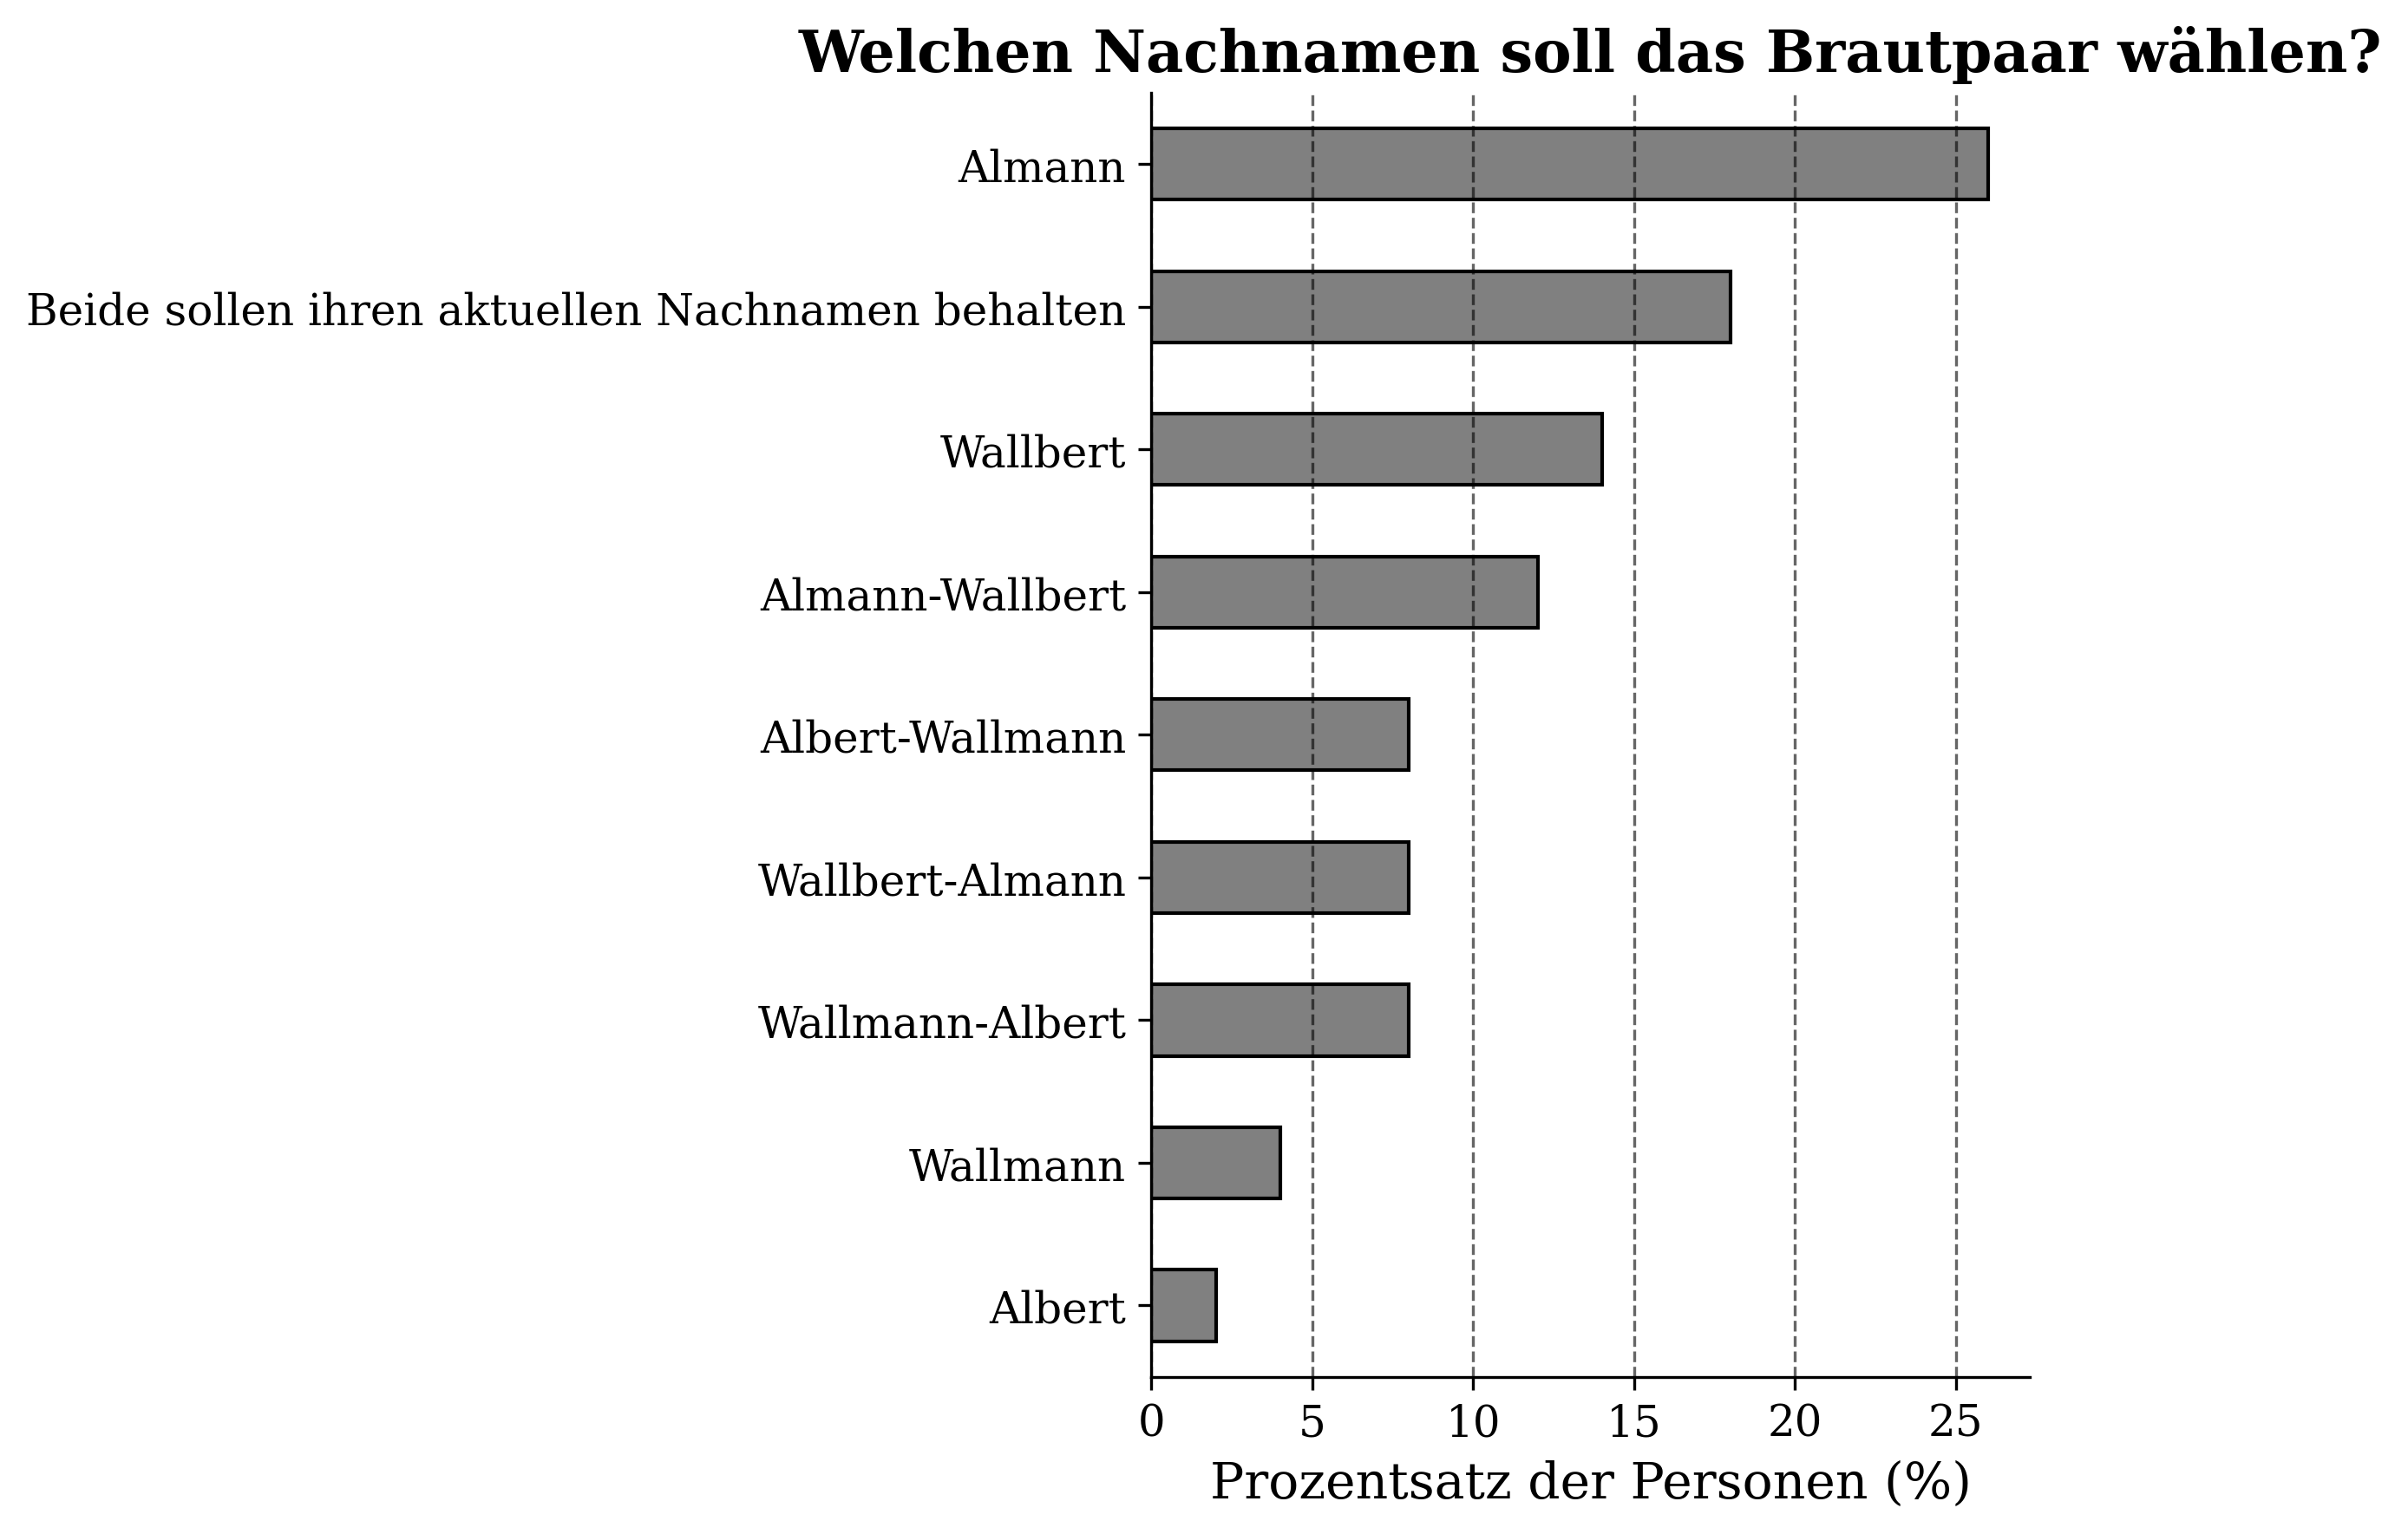

In [455]:
import pandas as pd
import matplotlib.pyplot as plt

# Berechne die Häufigkeit der Antworten in Prozent
nachnamen_counts = df["Welchen Nachnamen soll das Brautpaar wählen, wenn es nach dir geht?"].value_counts(normalize=True) * 100

# Optional: Ersetze ein Label, falls erforderlich (z.B., 'Alter Name' durch 'Neuer Name')
# nachnamen_counts.index = nachnamen_counts.index.str.replace('Alter Name', 'Neuer Name')

# Kehre die Reihenfolge um
nachnamen_counts = nachnamen_counts.iloc[::-1]

# Erstelle ein Balkendiagramm der Nachnamenwahl in Prozent mit invertierten Achsen und umgekehrter Reihenfolge
plt.figure(figsize=(8, 6), dpi=300)
nachnamen_counts.plot(kind='barh', color='gray', edgecolor='black')  # 'barh' für horizontales Balkendiagramm
plt.title('Welchen Nachnamen soll das Brautpaar wählen?', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Prozentsatz der Personen (%)', fontsize=14, family='serif')
plt.ylabel('', fontsize=14, family='serif')
plt.xticks(fontsize=12, family='serif')  # X-Achsen-Ticks
plt.yticks(fontsize=12, family='serif')  # Y-Achsen-Beschriftungen
plt.grid(axis='x', linestyle='--', alpha=0.6, color='black')  # Gitterlinien entlang der X-Achse
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()
